## Traffic Sign Classification

To implement the traffic sign classification, we are going to use the dataset expose for the German Traffic Sign Benchmark competition. Details about the competition could be found [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news).

### Global environment specific configuration settings

To make sure the code is able to run across multiple environments with different constraints, we are going to define fine grained configuration controls. The config dictionary below is a single place where configuration values are specieid. This should be modified to change the default environment specific assumptions.

In [1]:
config = {
    "dataset": "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip", # URI for training set.
    "batches": 5, # Number of batches to divide the dataset into.
    "local_cache_path": "./", # File system path to cache the downloaded images.
    "data_dir": "traffic_signs_data", # Directory to keep raw un-processed data.
    "batch_size": 1536, # No. of images to feed with each batch.
    "augmented_images_in_thousands": 70,
    "preprocessed_data_dir": "preprocessed_data" #Directory to hold the pre-processed training, validation and test data.
}

### Getting the data

The INI benchmarks website hosts the data used for GTSRB comptetion [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news). The dataset consist of 39,209 images for training the model and 12,630 images for the testing purpose. Instead of using the original dataset hosted on the website, we are going to use the dataset available [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This is the same dataset with some pre-processing already done. There are few things we get by using this:

- The images are resize to 32x32 pixels.
- The images are orgnized into train, validation and test set.

The code cell below would help us to download this dataset if not available and keep it ready for the analysis.

In [2]:
"""
Download the data from the web and cache it on the local device.
"""

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

# Define the base path to save the dataset.
base_dir = config["local_cache_path"]
data_dir = base_dir + config["data_dir"]

# Define the dataset file names,
raw_data_file = "traffic-signs-data.zip"


class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

# Utility to download the data if not already present.
def cache(target_file, cache_dir, download_uri, description=''):
    '''
        If cache hit - return
        If cache misss - Download the data and cache locally.
        @param target_file: The file to cache.
        @param cache_dir: The target directory to keep the cached files.
        @param download_uri: URI to download the file if not present.
        @param description: To display the progress message.
    '''
    path = cache_dir + target_file

    if not isfile(path):
        description = description or target_file
        try:
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc=description) as pbar:
                urlretrieve(download_uri, path, pbar.hook)
        except Exception as e:
            print("Issue downloading the file: {}".format(e.message))

def unzip(file_to_unzip, target_dir, cache_dir):
    '''
        If the target directory is not present, unzip the file into a target directory.
    '''
    path = cache_dir + target_dir
    file_path = cache_dir + file_to_unzip

    if not isdir(path):
        with zipfile.ZipFile(file_path) as zipf:
            zipf.extractall(path)
            zipf.close()

# Get the raw dataset.
cache(raw_data_file, base_dir, config["dataset"])

# Unzip the dataset to extract the training, validation and test set.
unzip(raw_data_file, data_dir, base_dir)

### Loading the training and validation set.

Let us load the training and validation set for us to do the data analysis and visualizations.


In [2]:
import utils

train_set, valid_set = utils.load_train_and_validation_set(config["local_cache_path"], config["data_dir"])
test_set = utils.load_test_set(config["local_cache_path"], config["data_dir"])

train_features = train_set["features"]
train_labels = train_set["labels"]

valid_features = valid_set["features"]
valid_labels = valid_set["labels"]

test_features = test_set["features"]
test_labels = test_set["labels"]

print("Total images for training: {}".format(train_labels.shape[0]))
print("Total images for validation: {}".format(valid_labels.shape[0]))
print("Total images for testing: {}".format(test_labels.shape[0]))

Total images for training: 34799
Total images for validation: 4410
Total images for testing: 12630


### Data Analysis and Visulizations

Exploratory Data Analysis is one of the very important step in the process of solving any machine learning problem. In the code cells that follow, we are going to analyze important aspects of our dataset to gain the better understanding.

#### Training and Validation set - Class Distribution

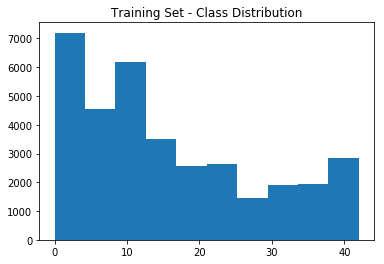

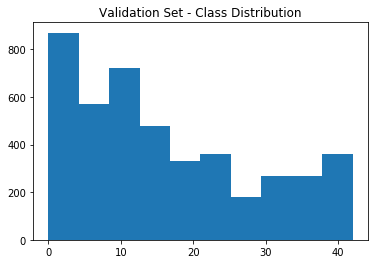

In [3]:
%matplotlib inline

utils.plot_class_distirbution(train_labels, "Training Set - Class Distribution")
utils.plot_class_distirbution(valid_labels, "Validation Set - Class Distribution")

Looking at the graphs above, we can make following observation:

- The training set and the validation set distribution is similar
- All the classes are covered / represented in the validation set.


#### Class Descriptions:

Let us load the class descriptions for each of the classes represented in the dataset, to get a view of what traffic signs have been covered.

In [4]:
import pandas as pd

label_ids = list(range(43))
label_desc = utils.load_label_names()
label_ids_desc = list(zip(label_ids, label_desc))

pd.DataFrame(label_ids_desc, columns=["Class ID", "Description"])

Class ID                                        Description
0          0                               Speed limit (20km/h)
1          1                               Speed limit (30km/h)
2          2                               Speed limit (50km/h)
3          3                               Speed limit (60km/h)
4          4                               Speed limit (70km/h)
5          5                               Speed limit (80km/h)
6          6                        End of speed limit (80km/h)
7          7                              Speed limit (100km/h)
8          8                              Speed limit (120km/h)
9          9                                         No passing
10        10       No passing for vehicles over 3.5 metric tons
11        11              Right-of-way at the next intersection
12        12                                      Priority road
13        13                                              Yield
14        14                                               Stop
15        15                                        No vehicles
16        16           Vehicles over 3.5 metric tons prohibited
17        17                                           No entry
18        18                                    General caution
19        19                        Dangerous curve to the left
20        20                       Dangerous curve to the right
21        21                                       Double curve
22        22                                         Bumpy road
23        23                                      Slippery road
24        24                          Road narrows on the right
25        25                                          Road work
26        26                                    Traffic signals
27        27                                        Pedestrians
28        28                                  Children crossing
29        29                                  Bicycles crossing
30        30                                 Beware of ice/snow
31        31                              Wild animals crossing
32        32                End of all speed and passing limits
33        33                                   Turn right ahead
34        34                                    Turn left ahead
35        35                                         Ahead only
36        36                               Go straight or right
37        37                                Go straight or left
38        38                                         Keep right
39        39                                          Keep left
40        40                               Roundabout mandatory
41        41                                  End of no passing
42        42  End of no passing by vehicles over 3.5 metric ...

#### Display Sample of Traffic Signs

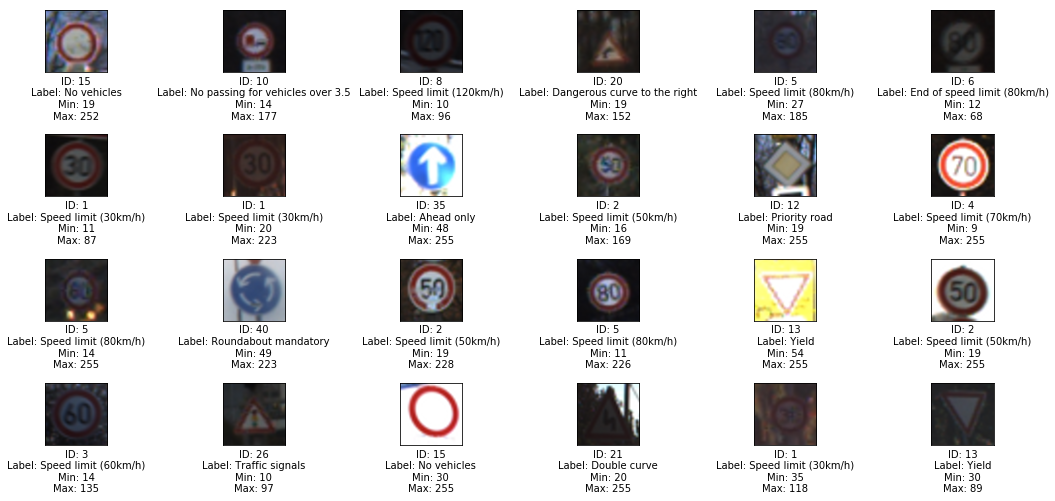

In [6]:
# Display some randomly sampled images from the training set with relevant metadata.
utils.display_sample_images(train_features, train_labels, label_desc)

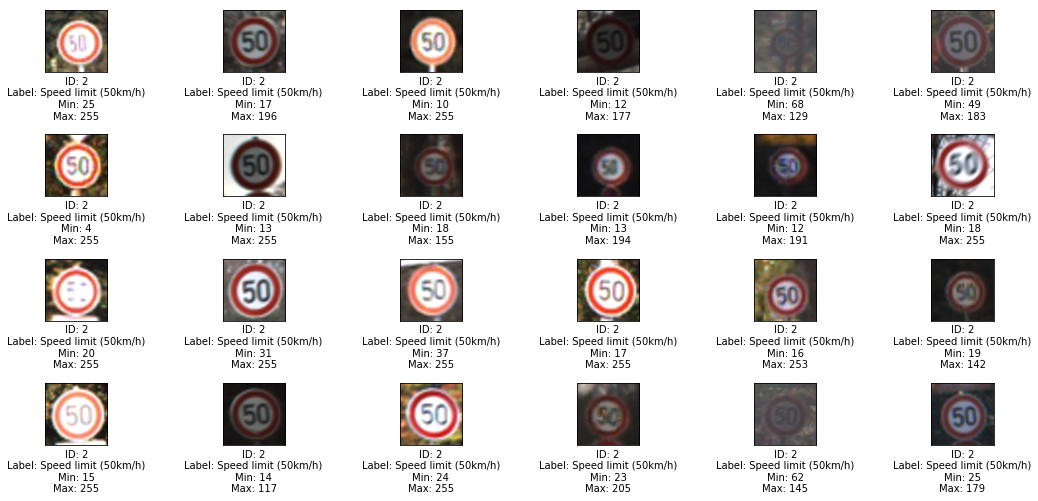

In [8]:
import numpy as np

sampled_labels_idx = np.argwhere(train_labels == 2).flatten()

sampled_images = train_features[sampled_labels_idx]
sampled_labels = train_labels[sampled_labels_idx]

utils.display_sample_images(sampled_images, sampled_labels, label_desc)

#### Observations:

As can be seen above, we have images of 32x32 each, where the min pixel value is 0 and max is 255. There are 3 color channels with one byte size each (8 bits to hold values between 0 to 255) and hence each image is 32x32x3 bytes in size. 

Some of the images shown above belong to the same class, and as we can see, even though they represent the same traffic sign, they look quite different from each other. Some images are very clear and bright, while others are very dull, some are distorted and damaged, while others suffer from sun glare. Our machine learning models needs to learn the general pattern such a way that these variations doesn't play the important role to predict the outcome.

#### One-hot encoding:

Before we build the network, we will one-hot encode the labels to make sure each label is a binary vector where the index corresponding to the label ID is 1 and rest of the elements on the vector are 0. 

In [27]:
# One hot encode the label data.
one_hot_encoded_training_labels = utils.one_hot_encode(train_labels)
one_hot_encoded_validation_labels = utils.one_hot_encode(valid_labels)

### Building Neural Network

To be able to build the fully working nueral network, we are going to break the overall process into multiple building blocks:

1. Implementing the input data tensors (placeholders for features, labels and dropout probability)
2. Defining the layers (both convolution and fully connected layers)
3. Composing the convolution nueral network with defined layers and input tensors.


#### Input data tensors:

As a first step in the network building process, we are going to first implment the input data primitives. We are going to start with the single dropout parameter for all the layers.

In [28]:
import tensorflow as tf

def nn_input_data_tensors(image_shape, n_classes=43):
    '''
        Given the input image shape, define the tensors for:
        - Set/Batch of image input with name x
        - Set/Batch of labels with the name y
        - Probability to keep with the name keep_prob.
    '''
    x = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], image_shape[2]), name="x")
    y = tf.placeholder(tf.float32, shape=(None, n_classes), name = "y")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    return (x, y, keep_prob)

#### Define convolutional, fully connected and output layers:

Since the convolutional model would consist of bunch of convolutional max pooled layers followed by full connected layers for classification, we are going to define both these layers.

In [29]:
def conv_maxpool_layer(x_tensor,  filter_depth, patch_shape, conv_stride, pool_patch_shape, pool_stride, conv_padding="SAME", pool_padding="SAME", activation_func=tf.nn.relu):
    '''
    :param x_tensor - The input tensor to the convolution layer.
    :param patch_shape - Shape of the convolution patch in the form of tuple.
    :param filter_depth - Number of output filters for the convolution layer.
    :param conv_stride - The stride for both width and height dimensions.
    :param pool_patch_shape - The shape of the patch for the max pool layer.
    :param pool_stride - The stride factor of the pooling patch in both the dimenstions.
    '''
    # Unpack the individual elements from the shape tuple.
    n_elements, image_w, image_h, image_channels = x_tensor.shape
    patch_w, patch_h = patch_shape
    patch_stride_w, patch_stride_h = conv_stride
    pool_patch_w, pool_patch_h = pool_patch_shape
    pool_stride_w, pool_stride_h = pool_stride
    
    # Create the weights and biases for the convolution layer.
    weight = tf.Variable(tf.truncated_normal([patch_w, patch_h, image_channels.value, filter_depth], stddev=0.1), name="conv_weight")
    bias = tf.Variable(tf.zeros([filter_depth], name="conv_bias"))
    
    print("Convolution layer - Input Image: {},  Weights: {}".format((x_tensor.shape), weight))
    # Create the convolution and maxpool layers.
    conv_layer = tf.nn.conv2d(x_tensor, weight, [1, patch_stride_w, patch_stride_h, 1], conv_padding)
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = activation_func(conv_layer)
    conv_layer = tf.nn.max_pool(conv_layer, [1, pool_patch_w, pool_patch_h, 1], [1, pool_stride_w, pool_stride_h, 1], pool_padding)
    
    return conv_layer


def flatten(x_tensor):
    '''
        Flatten the output of convolution layer for the fully connected layer.
    '''
    n_elements, ip_w, ip_h, ip_d = x_tensor.shape
    return tf.reshape(x_tensor, shape=(-1, ip_w.value * ip_h.value * ip_d.value))


def fully_connected_layer(x_tensor, num_outputs, activation_func=tf.nn.relu):
    '''
        Fully connected layer with the num_output neurons.
    '''
    n_elements, features = x_tensor.shape
    
    # Define the weights and bias for the fully connected layer.
    weights_hidden = tf.Variable(tf.truncated_normal([features.value, num_outputs], stddev=0.1))
    bias_hidden = tf.Variable(tf.zeros(num_outputs))
    
    print("Fully connected layer weights: {}".format(weights_hidden))
    
    # Perform the linear operation of XW+B.
    hidden_output = tf.add(tf.matmul(x_tensor, weights_hidden), bias_hidden)
    hidden_output = activation_func(hidden_output)

    return hidden_output


def output_layer(x_tensor, n_classes):
    '''
        Given the input features (x_tensor) and n_classes, implement the
        output layer and return logits.
    '''
    n_elements, features = x_tensor.shape
    
    # Define the weights and bias for the fully connected layer.
    weights_output = tf.Variable(tf.truncated_normal([features.value, n_classes], stddev=0.1))
    bias_output = tf.Variable(tf.zeros(n_classes))
    
    print("Output layer weights: {}".format(weights_output))

    # Perform the linear operation of XW+B.
    output = tf.add(tf.matmul(x_tensor, weights_output), bias_output)
    return tf.identity(output, name="logits")

#### Define optimizer and evaluaror:

#### Optimize:

In [30]:
def optimize(logits, y):
    '''
    Given the output logits and true labels, compute the cost (objective function)
    and define the optimizer to minimize the cost (objective function)
    '''
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

    return (cost, optimizer)

#### Evaluate:

In [31]:
def evaluate(logits, y):
    '''
    Given the final output in the form of logits and the true labels,
    evaluate the performance.
    '''
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    return accuracy


### Initial Model - LeNet Architecture

Before we dive deeper into building the solution, it is always important to start from some base line and build on top. For this project, we are going to use LeNet architecture as a base line model. The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, 'Gradient-Based Learning Applied to Document Recognition'. In the code cell that follows, we are going to compose the LeNet5 architecture as was proposed in the paper.

In [12]:
def lenet5(x):
    '''
    Given the input image data in the form of X tensor, compose
    the LeNet5 architecture from the building blocks.
    '''
    x_tensor = x
    
    # Convolution layer 1.
    conv_num_outputs = 6
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, activation_func=tf.nn.tanh, conv_padding="VALID")
    
    # Convolution layer 2.
    conv_num_outputs_second = 16
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(conv_output,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides, activation_func=tf.nn.tanh, conv_padding="VALID")

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    flattened = flatten(conv_output)
    
    # Fully connected layer 1.
    fc_hidden_layer_depth = 120
    fully_connected_output = fully_connected_layer(flattened, num_outputs=fc_hidden_layer_depth)

    final_output = output_layer(fully_connected_output, n_classes=43)

    # TODO: return output
    return final_output

def train_lenet5(train_features, train_labels, valid_features, valid_labels):
    '''
    Train the lenet5 architecture using the given input and validation data.
    '''
    tf.reset_default_graph()

    x, y, keep_prob = nn_input_data_tensors((32, 32, 3))
    logits = lenet5(x)
    cost, optimizer = optimize(logits, y)
    accuracy = evaluate(logits, y)

    epochs = 100
    batch_size = 1536

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(1, epochs+1):
            for batch in range(20):
                batch_start = batch * batch_size
                batch_end = batch_start + batch_size
                sess.run(optimizer, feed_dict={x: train_features[batch_start:batch_end], y: train_labels[batch_start:batch_end], keep_prob : 1.0 })
                cost_result = sess.run(cost, feed_dict={x: train_features[batch_start:batch_end], y: train_labels[batch_start:batch_end], keep_prob: 1.0})
                validation_accuracy = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
                print("Epoch: {}, Batch {} - Loss: {}, Validation Accuracy: {}".format(epoch,  batch, cost_result, validation_accuracy))
                
train_lenet5(train_features, one_hot_encoded_training_labels, valid_features, one_hot_encoded_validation_labels)

Convolution layer - Input Image: (?, 32, 32, 3),  Weights: <tf.Variable 'conv_weight:0' shape=(5, 5, 3, 6) dtype=float32_ref>
Convolution layer - Input Image: (?, 14, 14, 6),  Weights: <tf.Variable 'conv_weight_1:0' shape=(5, 5, 6, 16) dtype=float32_ref>
Fully connected layer weights: <tf.Variable 'Variable_2:0' shape=(400, 120) dtype=float32_ref>
Output layer weights: <tf.Variable 'Variable_4:0' shape=(120, 43) dtype=float32_ref>
Epoch: 1, Batch 0 - Loss: 3.2820026874542236, Validation Accuracy: 0.011791382916271687
Epoch: 1, Batch 1 - Loss: 3.3711531162261963, Validation Accuracy: 0.013605441898107529
Epoch: 1, Batch 2 - Loss: 3.0775949954986572, Validation Accuracy: 0.03333333507180214
Epoch: 1, Batch 3 - Loss: 3.987501859664917, Validation Accuracy: 0.04512471705675125
Epoch: 1, Batch 4 - Loss: 3.694152593612671, Validation Accuracy: 0.05238095298409462
Epoch: 1, Batch 5 - Loss: 4.341301441192627, Validation Accuracy: 0.0585034005343914
Epoch: 1, Batch 6 - Loss: 4.52366828918457, V

Epoch: 5, Batch 10 - Loss: 2.9898388385772705, Validation Accuracy: 0.2013605386018753
Epoch: 5, Batch 11 - Loss: 2.7361104488372803, Validation Accuracy: 0.2133786827325821
Epoch: 5, Batch 12 - Loss: 2.697617769241333, Validation Accuracy: 0.20997732877731323
Epoch: 5, Batch 13 - Loss: 3.6670122146606445, Validation Accuracy: 0.19092971086502075
Epoch: 5, Batch 14 - Loss: 2.555424213409424, Validation Accuracy: 0.17913831770420074
Epoch: 5, Batch 15 - Loss: 2.7765886783599854, Validation Accuracy: 0.17278911173343658
Epoch: 5, Batch 16 - Loss: 4.18101167678833, Validation Accuracy: 0.17142857611179352
Epoch: 5, Batch 17 - Loss: 3.262387990951538, Validation Accuracy: 0.16802720725536346
Epoch: 5, Batch 18 - Loss: 1.6805981397628784, Validation Accuracy: 0.1637188196182251
Epoch: 5, Batch 19 - Loss: 3.534876585006714, Validation Accuracy: 0.16712018847465515
Epoch: 6, Batch 0 - Loss: 4.105606555938721, Validation Accuracy: 0.16825397312641144
Epoch: 6, Batch 1 - Loss: 3.360920667648315

Epoch: 10, Batch 6 - Loss: 3.46701979637146, Validation Accuracy: 0.2775510251522064
Epoch: 10, Batch 7 - Loss: 2.909682512283325, Validation Accuracy: 0.27551019191741943
Epoch: 10, Batch 8 - Loss: 3.021197557449341, Validation Accuracy: 0.281632661819458
Epoch: 10, Batch 9 - Loss: 1.8839656114578247, Validation Accuracy: 0.2916099727153778
Epoch: 10, Batch 10 - Loss: 2.7470109462738037, Validation Accuracy: 0.30113378167152405
Epoch: 10, Batch 11 - Loss: 2.184579849243164, Validation Accuracy: 0.3142857253551483
Epoch: 10, Batch 12 - Loss: 1.8946808576583862, Validation Accuracy: 0.32585033774375916
Epoch: 10, Batch 13 - Loss: 2.6708993911743164, Validation Accuracy: 0.3285714387893677
Epoch: 10, Batch 14 - Loss: 1.454806923866272, Validation Accuracy: 0.3226757347583771
Epoch: 10, Batch 15 - Loss: 1.6817936897277832, Validation Accuracy: 0.32199546694755554
Epoch: 10, Batch 16 - Loss: 3.4617631435394287, Validation Accuracy: 0.31292515993118286
Epoch: 10, Batch 17 - Loss: 2.65554022

Epoch: 15, Batch 0 - Loss: 2.699144124984741, Validation Accuracy: 0.38367345929145813
Epoch: 15, Batch 1 - Loss: 2.6879148483276367, Validation Accuracy: 0.3945578336715698
Epoch: 15, Batch 2 - Loss: 2.0424296855926514, Validation Accuracy: 0.40748298168182373
Epoch: 15, Batch 3 - Loss: 2.5906505584716797, Validation Accuracy: 0.4195011258125305
Epoch: 15, Batch 4 - Loss: 2.2731800079345703, Validation Accuracy: 0.43492063879966736
Epoch: 15, Batch 5 - Loss: 1.3094226121902466, Validation Accuracy: 0.43718820810317993
Epoch: 15, Batch 6 - Loss: 2.546269655227661, Validation Accuracy: 0.41632652282714844
Epoch: 15, Batch 7 - Loss: 1.6261805295944214, Validation Accuracy: 0.38934239745140076
Epoch: 15, Batch 8 - Loss: 1.8601082563400269, Validation Accuracy: 0.36780044436454773
Epoch: 15, Batch 9 - Loss: 1.756759762763977, Validation Accuracy: 0.3648526072502136
Epoch: 15, Batch 10 - Loss: 2.7187583446502686, Validation Accuracy: 0.36575964093208313
Epoch: 15, Batch 11 - Loss: 1.8234199

Epoch: 19, Batch 14 - Loss: 0.4555770456790924, Validation Accuracy: 0.4911564588546753
Epoch: 19, Batch 15 - Loss: 1.4460097551345825, Validation Accuracy: 0.4920634925365448
Epoch: 19, Batch 16 - Loss: 2.606348752975464, Validation Accuracy: 0.4941042959690094
Epoch: 19, Batch 17 - Loss: 1.3578773736953735, Validation Accuracy: 0.4977324306964874
Epoch: 19, Batch 18 - Loss: 0.2538813054561615, Validation Accuracy: 0.5047619342803955
Epoch: 19, Batch 19 - Loss: 1.1340526342391968, Validation Accuracy: 0.5106576085090637
Epoch: 20, Batch 0 - Loss: 2.0729033946990967, Validation Accuracy: 0.516099750995636
Epoch: 20, Batch 1 - Loss: 2.1106526851654053, Validation Accuracy: 0.5165532827377319
Epoch: 20, Batch 2 - Loss: 1.7412647008895874, Validation Accuracy: 0.5176870822906494
Epoch: 20, Batch 3 - Loss: 1.9062724113464355, Validation Accuracy: 0.5176870822906494
Epoch: 20, Batch 4 - Loss: 1.9004865884780884, Validation Accuracy: 0.518367350101471
Epoch: 20, Batch 5 - Loss: 1.28676974773

Epoch: 24, Batch 8 - Loss: 1.6333856582641602, Validation Accuracy: 0.5945578217506409
Epoch: 24, Batch 9 - Loss: 0.4149225950241089, Validation Accuracy: 0.597732424736023
Epoch: 24, Batch 10 - Loss: 1.3627537488937378, Validation Accuracy: 0.5981859564781189
Epoch: 24, Batch 11 - Loss: 0.6281061172485352, Validation Accuracy: 0.597732424736023
Epoch: 24, Batch 12 - Loss: 0.3273485600948334, Validation Accuracy: 0.5984126925468445
Epoch: 24, Batch 13 - Loss: 1.1471108198165894, Validation Accuracy: 0.595464825630188
Epoch: 24, Batch 14 - Loss: 0.2770244777202606, Validation Accuracy: 0.5965986251831055
Epoch: 24, Batch 15 - Loss: 1.2165035009384155, Validation Accuracy: 0.5959183573722839
Epoch: 24, Batch 16 - Loss: 2.015583038330078, Validation Accuracy: 0.5988662242889404
Epoch: 24, Batch 17 - Loss: 0.9521682858467102, Validation Accuracy: 0.6015872955322266
Epoch: 24, Batch 18 - Loss: 0.18816955387592316, Validation Accuracy: 0.6011337637901306
Epoch: 24, Batch 19 - Loss: 0.6182577

Epoch: 29, Batch 2 - Loss: 0.9970895648002625, Validation Accuracy: 0.6498866081237793
Epoch: 29, Batch 3 - Loss: 1.0585139989852905, Validation Accuracy: 0.6526077389717102
Epoch: 29, Batch 4 - Loss: 1.2454925775527954, Validation Accuracy: 0.6564626097679138
Epoch: 29, Batch 5 - Loss: 0.7998766303062439, Validation Accuracy: 0.6526077389717102
Epoch: 29, Batch 6 - Loss: 1.5346359014511108, Validation Accuracy: 0.6448979377746582
Epoch: 29, Batch 7 - Loss: 0.7896528244018555, Validation Accuracy: 0.6417233347892761
Epoch: 29, Batch 8 - Loss: 1.4939404726028442, Validation Accuracy: 0.6521542072296143
Epoch: 29, Batch 9 - Loss: 0.3829232156276703, Validation Accuracy: 0.6575963497161865
Epoch: 29, Batch 10 - Loss: 1.204648494720459, Validation Accuracy: 0.6560090780258179
Epoch: 29, Batch 11 - Loss: 0.4834935963153839, Validation Accuracy: 0.6553288102149963
Epoch: 29, Batch 12 - Loss: 0.2816157341003418, Validation Accuracy: 0.6573696136474609
Epoch: 29, Batch 13 - Loss: 0.82566553354

Epoch: 33, Batch 16 - Loss: 1.4562875032424927, Validation Accuracy: 0.6739228963851929
Epoch: 33, Batch 17 - Loss: 0.6316202878952026, Validation Accuracy: 0.680272102355957
Epoch: 33, Batch 18 - Loss: 0.14360523223876953, Validation Accuracy: 0.6870748400688171
Epoch: 33, Batch 19 - Loss: 0.3450624942779541, Validation Accuracy: 0.6852607727050781
Epoch: 34, Batch 0 - Loss: 1.008773922920227, Validation Accuracy: 0.680272102355957
Epoch: 34, Batch 1 - Loss: 1.2652729749679565, Validation Accuracy: 0.6816326379776001
Epoch: 34, Batch 2 - Loss: 0.8319471478462219, Validation Accuracy: 0.6814059019088745
Epoch: 34, Batch 3 - Loss: 0.8644281029701233, Validation Accuracy: 0.6811791658401489
Epoch: 34, Batch 4 - Loss: 1.0162745714187622, Validation Accuracy: 0.6814059019088745
Epoch: 34, Batch 5 - Loss: 0.635219395160675, Validation Accuracy: 0.6777777671813965
Epoch: 34, Batch 6 - Loss: 1.3513704538345337, Validation Accuracy: 0.6798185706138611
Epoch: 34, Batch 7 - Loss: 0.6936256289482

Epoch: 38, Batch 10 - Loss: 0.8423013091087341, Validation Accuracy: 0.7190476059913635
Epoch: 38, Batch 11 - Loss: 0.3259603679180145, Validation Accuracy: 0.7199546694755554
Epoch: 38, Batch 12 - Loss: 0.17146271467208862, Validation Accuracy: 0.717913806438446
Epoch: 38, Batch 13 - Loss: 0.5340457558631897, Validation Accuracy: 0.7140589356422424
Epoch: 38, Batch 14 - Loss: 0.1398642361164093, Validation Accuracy: 0.7120181322097778
Epoch: 38, Batch 15 - Loss: 0.7388224601745605, Validation Accuracy: 0.7104308605194092
Epoch: 38, Batch 16 - Loss: 1.0838531255722046, Validation Accuracy: 0.7088435292243958
Epoch: 38, Batch 17 - Loss: 0.47582507133483887, Validation Accuracy: 0.7088435292243958
Epoch: 38, Batch 18 - Loss: 0.11768299341201782, Validation Accuracy: 0.7074829936027527
Epoch: 38, Batch 19 - Loss: 0.2685244083404541, Validation Accuracy: 0.7056689262390137
Epoch: 39, Batch 0 - Loss: 0.8104017376899719, Validation Accuracy: 0.7104308605194092
Epoch: 39, Batch 1 - Loss: 1.00

Epoch: 43, Batch 4 - Loss: 0.7307209968566895, Validation Accuracy: 0.722449004650116
Epoch: 43, Batch 5 - Loss: 0.48363518714904785, Validation Accuracy: 0.7285714149475098
Epoch: 43, Batch 6 - Loss: 0.8999693989753723, Validation Accuracy: 0.7290249466896057
Epoch: 43, Batch 7 - Loss: 0.4421811103820801, Validation Accuracy: 0.7306122183799744
Epoch: 43, Batch 8 - Loss: 1.0284136533737183, Validation Accuracy: 0.7317460179328918
Epoch: 43, Batch 9 - Loss: 0.2190619558095932, Validation Accuracy: 0.7337868213653564
Epoch: 43, Batch 10 - Loss: 0.7402819991111755, Validation Accuracy: 0.7356008887290955
Epoch: 43, Batch 11 - Loss: 0.2753930985927582, Validation Accuracy: 0.7337868213653564
Epoch: 43, Batch 12 - Loss: 0.15730436146259308, Validation Accuracy: 0.7324262857437134
Epoch: 43, Batch 13 - Loss: 0.424474835395813, Validation Accuracy: 0.7315192818641663
Epoch: 43, Batch 14 - Loss: 0.13793233036994934, Validation Accuracy: 0.7274376153945923
Epoch: 43, Batch 15 - Loss: 0.6202393

Epoch: 47, Batch 18 - Loss: 0.09730461239814758, Validation Accuracy: 0.7446712255477905
Epoch: 47, Batch 19 - Loss: 0.2001354843378067, Validation Accuracy: 0.7453514933586121
Epoch: 48, Batch 0 - Loss: 0.6353984475135803, Validation Accuracy: 0.7405895590782166
Epoch: 48, Batch 1 - Loss: 0.7929668426513672, Validation Accuracy: 0.739909291267395
Epoch: 48, Batch 2 - Loss: 0.4354560077190399, Validation Accuracy: 0.7374149560928345
Epoch: 48, Batch 3 - Loss: 0.49722591042518616, Validation Accuracy: 0.7349206209182739
Epoch: 48, Batch 4 - Loss: 0.6502280235290527, Validation Accuracy: 0.7374149560928345
Epoch: 48, Batch 5 - Loss: 0.3639492988586426, Validation Accuracy: 0.7405895590782166
Epoch: 48, Batch 6 - Loss: 0.7719774842262268, Validation Accuracy: 0.739909291267395
Epoch: 48, Batch 7 - Loss: 0.41258230805397034, Validation Accuracy: 0.7419500946998596
Epoch: 48, Batch 8 - Loss: 0.7675338387489319, Validation Accuracy: 0.7428571581840515
Epoch: 48, Batch 9 - Loss: 0.17861968278

Epoch: 52, Batch 12 - Loss: 0.22605694830417633, Validation Accuracy: 0.6852607727050781
Epoch: 52, Batch 13 - Loss: 0.49304747581481934, Validation Accuracy: 0.6814059019088745
Epoch: 52, Batch 14 - Loss: 0.20170815289020538, Validation Accuracy: 0.698639452457428
Epoch: 52, Batch 15 - Loss: 0.8277677893638611, Validation Accuracy: 0.7122448682785034
Epoch: 52, Batch 16 - Loss: 1.040413498878479, Validation Accuracy: 0.7226757407188416
Epoch: 52, Batch 17 - Loss: 0.5103921890258789, Validation Accuracy: 0.7233560085296631
Epoch: 52, Batch 18 - Loss: 0.14295530319213867, Validation Accuracy: 0.7253968119621277
Epoch: 52, Batch 19 - Loss: 0.23874664306640625, Validation Accuracy: 0.7235827445983887
Epoch: 53, Batch 0 - Loss: 0.679060697555542, Validation Accuracy: 0.7160997986793518
Epoch: 53, Batch 1 - Loss: 0.868349015712738, Validation Accuracy: 0.7106575965881348
Epoch: 53, Batch 2 - Loss: 0.5747818946838379, Validation Accuracy: 0.7077097296714783
Epoch: 53, Batch 3 - Loss: 0.57085

Epoch: 57, Batch 6 - Loss: 0.5538857579231262, Validation Accuracy: 0.7643991112709045
Epoch: 57, Batch 7 - Loss: 0.3045543134212494, Validation Accuracy: 0.7666666507720947
Epoch: 57, Batch 8 - Loss: 0.7059842944145203, Validation Accuracy: 0.7678004503250122
Epoch: 57, Batch 9 - Loss: 0.16017849743366241, Validation Accuracy: 0.7666666507720947
Epoch: 57, Batch 10 - Loss: 0.5055727362632751, Validation Accuracy: 0.7687074542045593
Epoch: 57, Batch 11 - Loss: 0.17999649047851562, Validation Accuracy: 0.7659863829612732
Epoch: 57, Batch 12 - Loss: 0.11170181632041931, Validation Accuracy: 0.7689342498779297
Epoch: 57, Batch 13 - Loss: 0.2885543406009674, Validation Accuracy: 0.7653061151504517
Epoch: 57, Batch 14 - Loss: 0.0863964781165123, Validation Accuracy: 0.7653061151504517
Epoch: 57, Batch 15 - Loss: 0.3914162814617157, Validation Accuracy: 0.7648525834083557
Epoch: 57, Batch 16 - Loss: 0.6150232553482056, Validation Accuracy: 0.7646258473396301
Epoch: 57, Batch 17 - Loss: 0.277

Epoch: 62, Batch 0 - Loss: 0.3984491527080536, Validation Accuracy: 0.7641723155975342
Epoch: 62, Batch 1 - Loss: 0.5169949531555176, Validation Accuracy: 0.7625850439071655
Epoch: 62, Batch 2 - Loss: 0.3085038959980011, Validation Accuracy: 0.7632653117179871
Epoch: 62, Batch 3 - Loss: 0.2958844006061554, Validation Accuracy: 0.7666666507720947
Epoch: 62, Batch 4 - Loss: 0.385053426027298, Validation Accuracy: 0.7687074542045593
Epoch: 62, Batch 5 - Loss: 0.25663796067237854, Validation Accuracy: 0.7709750533103943
Epoch: 62, Batch 6 - Loss: 0.4584505259990692, Validation Accuracy: 0.7709750533103943
Epoch: 62, Batch 7 - Loss: 0.249579057097435, Validation Accuracy: 0.7693877816200256
Epoch: 62, Batch 8 - Loss: 0.6294609904289246, Validation Accuracy: 0.7705215215682983
Epoch: 62, Batch 9 - Loss: 0.13720503449440002, Validation Accuracy: 0.7696145176887512
Epoch: 62, Batch 10 - Loss: 0.42082080245018005, Validation Accuracy: 0.7718820571899414
Epoch: 62, Batch 11 - Loss: 0.15129029750

Epoch: 66, Batch 14 - Loss: 0.06441161781549454, Validation Accuracy: 0.7736961245536804
Epoch: 66, Batch 15 - Loss: 0.3218514621257782, Validation Accuracy: 0.7684807181358337
Epoch: 66, Batch 16 - Loss: 0.47254976630210876, Validation Accuracy: 0.7682539820671082
Epoch: 66, Batch 17 - Loss: 0.204759418964386, Validation Accuracy: 0.7689342498779297
Epoch: 66, Batch 18 - Loss: 0.06598536670207977, Validation Accuracy: 0.7691609859466553
Epoch: 66, Batch 19 - Loss: 0.12290797382593155, Validation Accuracy: 0.7700680494308472
Epoch: 67, Batch 0 - Loss: 0.34708595275878906, Validation Accuracy: 0.7714285850524902
Epoch: 67, Batch 1 - Loss: 0.4592342674732208, Validation Accuracy: 0.7696145176887512
Epoch: 67, Batch 2 - Loss: 0.2642829716205597, Validation Accuracy: 0.7716553211212158
Epoch: 67, Batch 3 - Loss: 0.26080796122550964, Validation Accuracy: 0.7721088528633118
Epoch: 67, Batch 4 - Loss: 0.34861281514167786, Validation Accuracy: 0.7712017893791199
Epoch: 67, Batch 5 - Loss: 0.24

Epoch: 71, Batch 8 - Loss: 0.5325841307640076, Validation Accuracy: 0.7766439914703369
Epoch: 71, Batch 9 - Loss: 0.11062844842672348, Validation Accuracy: 0.779365062713623
Epoch: 71, Batch 10 - Loss: 0.3201260268688202, Validation Accuracy: 0.779818594455719
Epoch: 71, Batch 11 - Loss: 0.12292762845754623, Validation Accuracy: 0.779365062713623
Epoch: 71, Batch 12 - Loss: 0.07353662699460983, Validation Accuracy: 0.7782312631607056
Epoch: 71, Batch 13 - Loss: 0.20785725116729736, Validation Accuracy: 0.7773242592811584
Epoch: 71, Batch 14 - Loss: 0.0548403263092041, Validation Accuracy: 0.7755101919174194
Epoch: 71, Batch 15 - Loss: 0.2881529629230499, Validation Accuracy: 0.7752834558486938
Epoch: 71, Batch 16 - Loss: 0.40201154351234436, Validation Accuracy: 0.7755101919174194
Epoch: 71, Batch 17 - Loss: 0.1859961301088333, Validation Accuracy: 0.776190459728241
Epoch: 71, Batch 18 - Loss: 0.057584408670663834, Validation Accuracy: 0.776190459728241
Epoch: 71, Batch 19 - Loss: 0.10

Epoch: 76, Batch 2 - Loss: 0.23262536525726318, Validation Accuracy: 0.783446729183197
Epoch: 76, Batch 3 - Loss: 0.18432104587554932, Validation Accuracy: 0.7789115905761719
Epoch: 76, Batch 4 - Loss: 0.3354635238647461, Validation Accuracy: 0.7784580588340759
Epoch: 76, Batch 5 - Loss: 0.18797338008880615, Validation Accuracy: 0.7818593978881836
Epoch: 76, Batch 6 - Loss: 0.3430097997188568, Validation Accuracy: 0.7825396656990051
Epoch: 76, Batch 7 - Loss: 0.19533812999725342, Validation Accuracy: 0.7791383266448975
Epoch: 76, Batch 8 - Loss: 0.47562524676322937, Validation Accuracy: 0.7841269969940186
Epoch: 76, Batch 9 - Loss: 0.10548284649848938, Validation Accuracy: 0.781632661819458
Epoch: 76, Batch 10 - Loss: 0.29712262749671936, Validation Accuracy: 0.776190459728241
Epoch: 76, Batch 11 - Loss: 0.11896588653326035, Validation Accuracy: 0.7718820571899414
Epoch: 76, Batch 12 - Loss: 0.058091308921575546, Validation Accuracy: 0.7684807181358337
Epoch: 76, Batch 13 - Loss: 0.201

Epoch: 80, Batch 16 - Loss: 0.444814532995224, Validation Accuracy: 0.7802721261978149
Epoch: 80, Batch 17 - Loss: 0.18096934258937836, Validation Accuracy: 0.7848072648048401
Epoch: 80, Batch 18 - Loss: 0.05705065652728081, Validation Accuracy: 0.7836734652519226
Epoch: 80, Batch 19 - Loss: 0.09468930959701538, Validation Accuracy: 0.7832199335098267
Epoch: 81, Batch 0 - Loss: 0.30495306849479675, Validation Accuracy: 0.7832199335098267
Epoch: 81, Batch 1 - Loss: 0.3971809148788452, Validation Accuracy: 0.7811791300773621
Epoch: 81, Batch 2 - Loss: 0.2227533608675003, Validation Accuracy: 0.7804988622665405
Epoch: 81, Batch 3 - Loss: 0.1804574728012085, Validation Accuracy: 0.7782312631607056
Epoch: 81, Batch 4 - Loss: 0.303720623254776, Validation Accuracy: 0.7750566601753235
Epoch: 81, Batch 5 - Loss: 0.23103974759578705, Validation Accuracy: 0.7693877816200256
Epoch: 81, Batch 6 - Loss: 0.36722370982170105, Validation Accuracy: 0.7759637236595154
Epoch: 81, Batch 7 - Loss: 0.209384

Epoch: 85, Batch 10 - Loss: 0.29643067717552185, Validation Accuracy: 0.7861678004264832
Epoch: 85, Batch 11 - Loss: 0.095411516726017, Validation Accuracy: 0.7854875326156616
Epoch: 85, Batch 12 - Loss: 0.05506102740764618, Validation Accuracy: 0.7848072648048401
Epoch: 85, Batch 13 - Loss: 0.15651924908161163, Validation Accuracy: 0.7827664613723755
Epoch: 85, Batch 14 - Loss: 0.038866814225912094, Validation Accuracy: 0.7777777910232544
Epoch: 85, Batch 15 - Loss: 0.2616548240184784, Validation Accuracy: 0.781632661819458
Epoch: 85, Batch 16 - Loss: 0.32145336270332336, Validation Accuracy: 0.7859410643577576
Epoch: 85, Batch 17 - Loss: 0.13670474290847778, Validation Accuracy: 0.7870748043060303
Epoch: 85, Batch 18 - Loss: 0.04755030572414398, Validation Accuracy: 0.7904762029647827
Epoch: 85, Batch 19 - Loss: 0.09116163849830627, Validation Accuracy: 0.7900226712226868
Epoch: 86, Batch 0 - Loss: 0.25236383080482483, Validation Accuracy: 0.7913832068443298
Epoch: 86, Batch 1 - Loss

Epoch: 90, Batch 4 - Loss: 0.21893425285816193, Validation Accuracy: 0.7850340008735657
Epoch: 90, Batch 5 - Loss: 0.17391405999660492, Validation Accuracy: 0.7870748043060303
Epoch: 90, Batch 6 - Loss: 0.2621366083621979, Validation Accuracy: 0.7870748043060303
Epoch: 90, Batch 7 - Loss: 0.1639653742313385, Validation Accuracy: 0.7888888716697693
Epoch: 90, Batch 8 - Loss: 0.42900046706199646, Validation Accuracy: 0.7895691394805908
Epoch: 90, Batch 9 - Loss: 0.08656512945890427, Validation Accuracy: 0.7909297347068787
Epoch: 90, Batch 10 - Loss: 0.23715801537036896, Validation Accuracy: 0.7918367385864258
Epoch: 90, Batch 11 - Loss: 0.08884770423173904, Validation Accuracy: 0.7897959351539612
Epoch: 90, Batch 12 - Loss: 0.0547521747648716, Validation Accuracy: 0.7900226712226868
Epoch: 90, Batch 13 - Loss: 0.14242689311504364, Validation Accuracy: 0.7873015999794006
Epoch: 90, Batch 14 - Loss: 0.038762662559747696, Validation Accuracy: 0.7870748043060303
Epoch: 90, Batch 15 - Loss: 0

Epoch: 94, Batch 18 - Loss: 0.037999119609594345, Validation Accuracy: 0.7975056767463684
Epoch: 94, Batch 19 - Loss: 0.07285130769014359, Validation Accuracy: 0.7970521450042725
Epoch: 95, Batch 0 - Loss: 0.2052912712097168, Validation Accuracy: 0.7986394762992859
Epoch: 95, Batch 1 - Loss: 0.2681022584438324, Validation Accuracy: 0.800000011920929
Epoch: 95, Batch 2 - Loss: 0.13900455832481384, Validation Accuracy: 0.7972789406776428
Epoch: 95, Batch 3 - Loss: 0.13320468366146088, Validation Accuracy: 0.7938775420188904
Epoch: 95, Batch 4 - Loss: 0.21588434278964996, Validation Accuracy: 0.7947846055030823
Epoch: 95, Batch 5 - Loss: 0.1533656120300293, Validation Accuracy: 0.7963718771934509
Epoch: 95, Batch 6 - Loss: 0.23180723190307617, Validation Accuracy: 0.7963718771934509
Epoch: 95, Batch 7 - Loss: 0.14028456807136536, Validation Accuracy: 0.7943310737609863
Epoch: 95, Batch 8 - Loss: 0.30878570675849915, Validation Accuracy: 0.7936508059501648
Epoch: 95, Batch 9 - Loss: 0.0831

Epoch: 99, Batch 12 - Loss: 0.058632563799619675, Validation Accuracy: 0.7943310737609863
Epoch: 99, Batch 13 - Loss: 0.12577490508556366, Validation Accuracy: 0.7936508059501648
Epoch: 99, Batch 14 - Loss: 0.03761584684252739, Validation Accuracy: 0.7929705381393433
Epoch: 99, Batch 15 - Loss: 0.20522864162921906, Validation Accuracy: 0.7920634746551514
Epoch: 99, Batch 16 - Loss: 0.25072813034057617, Validation Accuracy: 0.7941043376922607
Epoch: 99, Batch 17 - Loss: 0.10689010471105576, Validation Accuracy: 0.7956916093826294
Epoch: 99, Batch 18 - Loss: 0.034158993512392044, Validation Accuracy: 0.7943310737609863
Epoch: 99, Batch 19 - Loss: 0.06195374205708504, Validation Accuracy: 0.7970521450042725
Epoch: 100, Batch 0 - Loss: 0.16897308826446533, Validation Accuracy: 0.7945578098297119
Epoch: 100, Batch 1 - Loss: 0.25152671337127686, Validation Accuracy: 0.7952380776405334
Epoch: 100, Batch 2 - Loss: 0.15988905727863312, Validation Accuracy: 0.7947846055030823
Epoch: 100, Batch 3

#### Observations:

The LeNet5 architecture was super fast as far training time is concerned. It also gave us pretty good accuracy of 0.8 from the get go. The LeNet5 architecture was objectively designed and architected to recognize hand written digits, which is quite different from the traffic signs recognition. We are going to improve upon this base model to increase the accuracy of the solution. To be able to do so, we will perform the following:

1. Data pre-processing
2. Deeper convolutional models
3. Regularization using drop outs.
4. Data augmentation.

###  Data Pre-Processing:

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Define the data generator
shift_rotation_generator = ImageDataGenerator(
                                    width_shift_range=0.10,
                                    height_shift_range=0.10,
                                    rotation_range=30,
                                    shear_range=np.deg2rad(15),
                                    zoom_range = 0.2,
                                    data_format="channels_last"
                                    )

shift_rotation_generator.fit(train_features)


extended_features = np.empty((0, 32, 32, 3), dtype="uint8")
extended_labels = np.empty((0,), dtype="uint8")

batch = 0
max_batch = config["augmented_images_in_thousands"]

for X_batch, y_batch in shift_rotation_generator.flow(train_features, train_labels, batch_size=1024):
    print ("Running Batch: {}".format(batch))
    extended_features = np.append(extended_features, X_batch.astype("uint8"), axis=0)
    extended_labels = np.append(extended_labels, y_batch.astype("uint8"), axis=0)
    batch = batch + 1
    if batch >= max_batch:
        break

Using TensorFlow backend.


Running Batch: 0
Running Batch: 1
Running Batch: 2
Running Batch: 3
Running Batch: 4
Running Batch: 5
Running Batch: 6
Running Batch: 7
Running Batch: 8
Running Batch: 9
Running Batch: 10
Running Batch: 11
Running Batch: 12
Running Batch: 13
Running Batch: 14
Running Batch: 15
Running Batch: 16
Running Batch: 17
Running Batch: 18
Running Batch: 19
Running Batch: 20
Running Batch: 21
Running Batch: 22
Running Batch: 23
Running Batch: 24
Running Batch: 25
Running Batch: 26
Running Batch: 27
Running Batch: 28
Running Batch: 29
Running Batch: 30
Running Batch: 31
Running Batch: 32
Running Batch: 33
Running Batch: 34
Running Batch: 35
Running Batch: 36
Running Batch: 37
Running Batch: 38
Running Batch: 39
Running Batch: 40
Running Batch: 41
Running Batch: 42
Running Batch: 43
Running Batch: 44
Running Batch: 45
Running Batch: 46
Running Batch: 47
Running Batch: 48
Running Batch: 49
Running Batch: 50
Running Batch: 51
Running Batch: 52
Running Batch: 53
Running Batch: 54
Running Batch: 55
Ru

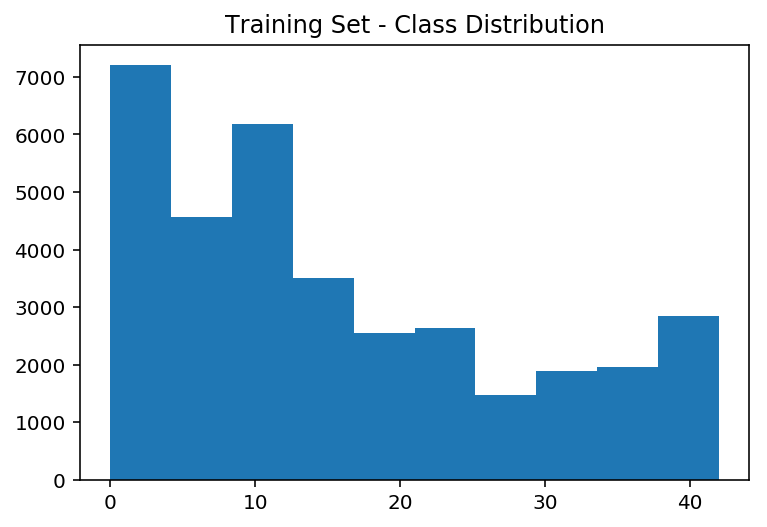

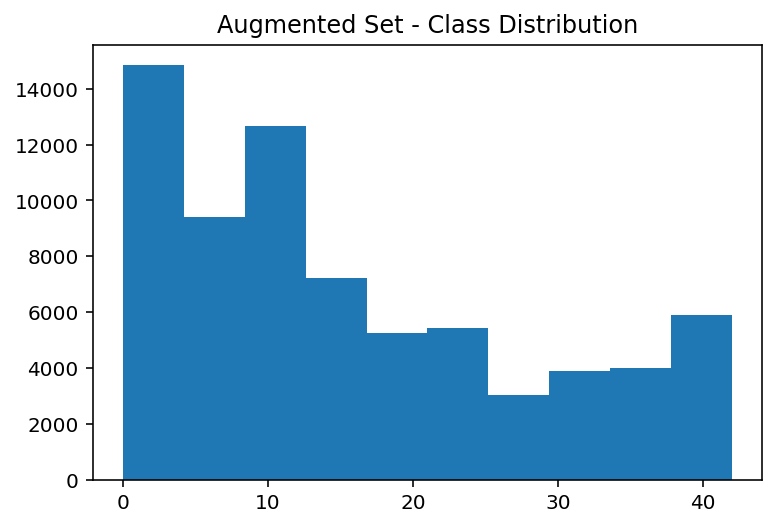

In [34]:
utils.plot_class_distirbution(train_labels, "Training Set - Class Distribution")
utils.plot_class_distirbution(extended_labels, "Augmented Set - Class Distribution")

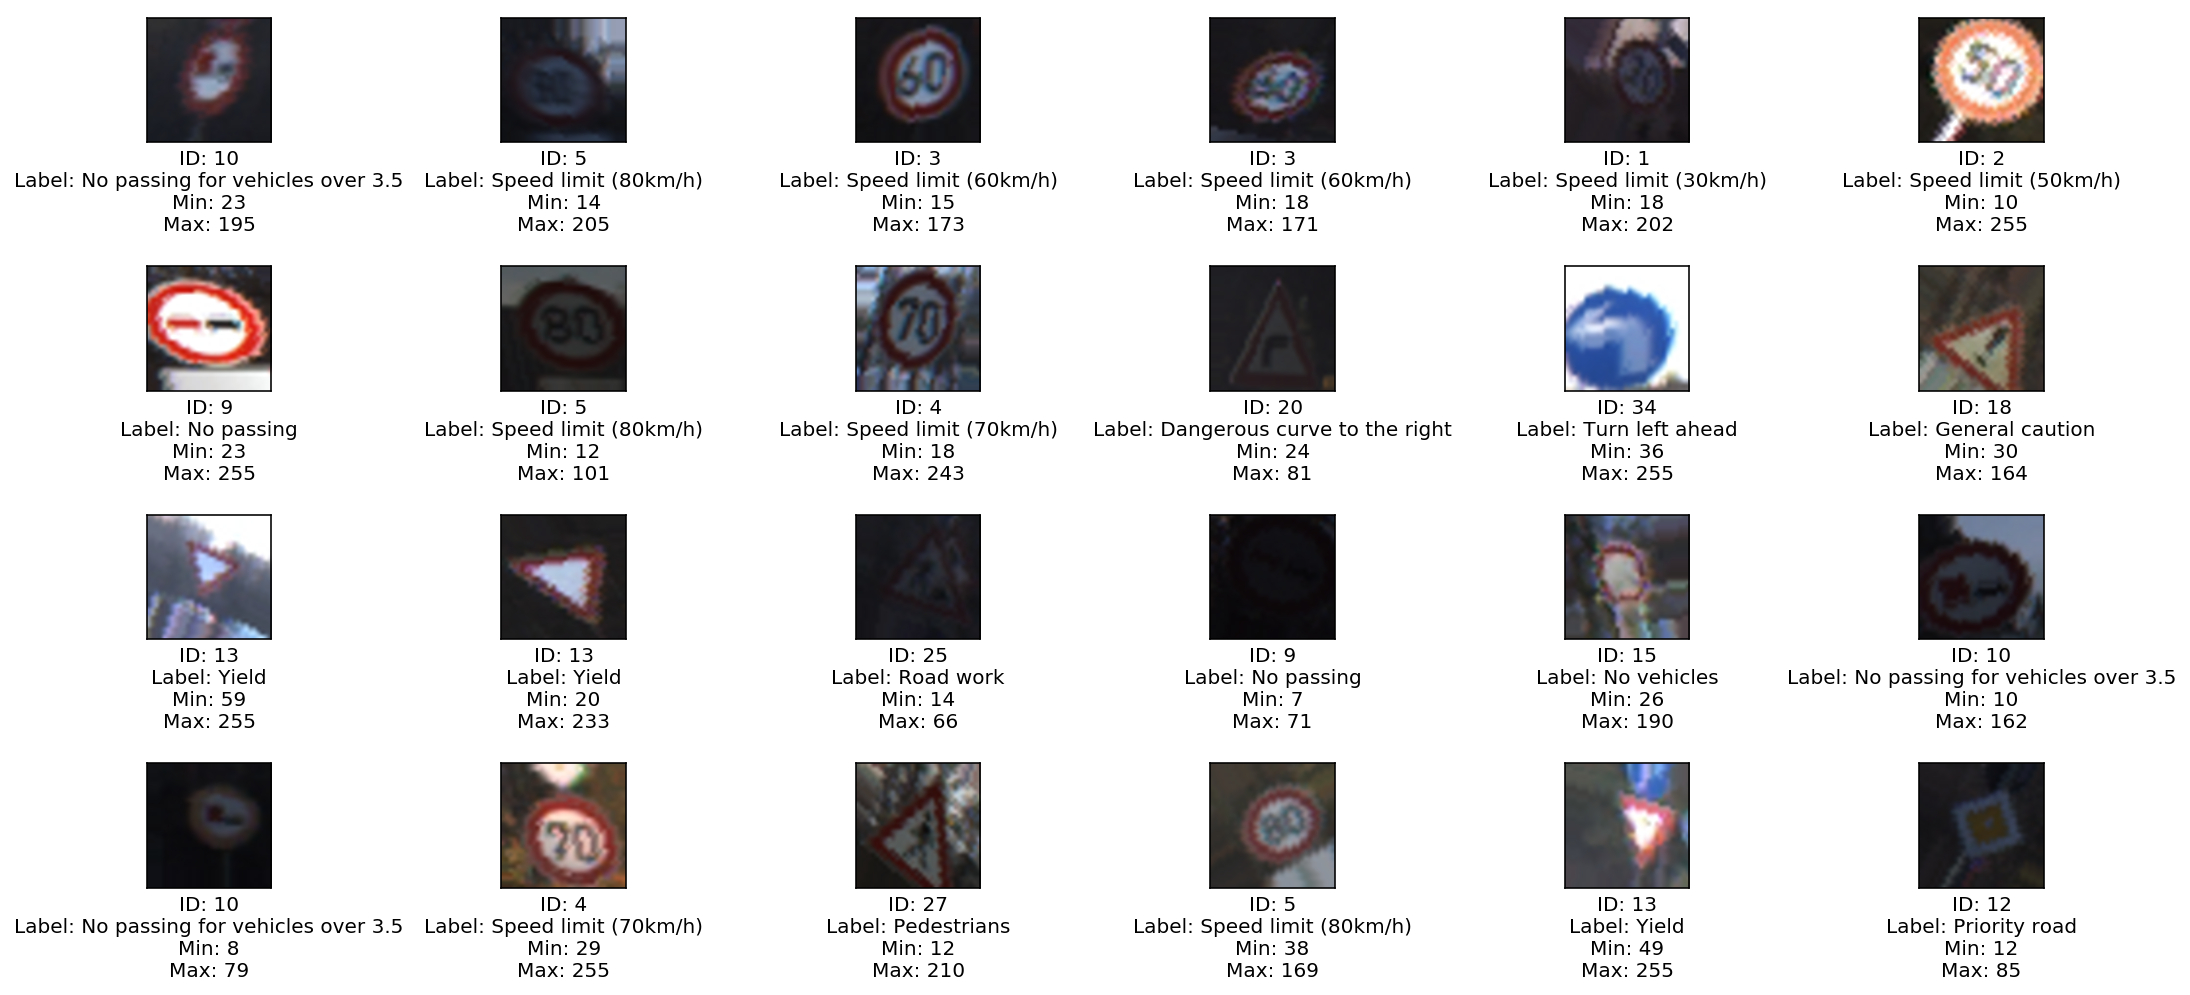

In [35]:
utils.display_sample_images(extended_features, extended_labels, label_desc)

In [36]:
train_features = np.append(train_features, extended_features, axis=0)
train_labels = np.append(train_labels, extended_labels, axis=0)

print("Train Features: {}, Train Labels: {}".format(train_features.shape, train_labels.shape))

Train Features: (106445, 32, 32, 3), Train Labels: (106445,)


In [37]:
one_hot_encoded_training_labels = utils.one_hot_encode(train_labels)

#### Grey Scaling:

As we may notice, some traffic signs have different colors than the others. While images for classes like 'Keep Left', 'Ahead Only' are primarily represented in blue, the other classes like 'Yield' and 'Speed Limit' are primarily represented in red. Though colors may be somewhat helpful for the human eye, it may not be very useful for building the models. For the model to be reliable, we want the models to learn the general patterns that define the traffic sign, rather than basing their predictions based on the colors. To make our models independent of the colors, we are going to convery the RGB images into gray scale images. This also has the added advantage of lesser memory foot print. While the RGB image would need 32x32x3 bytes each, the gray scale images would be stored in 32x32 bytes, a reduction of x3.

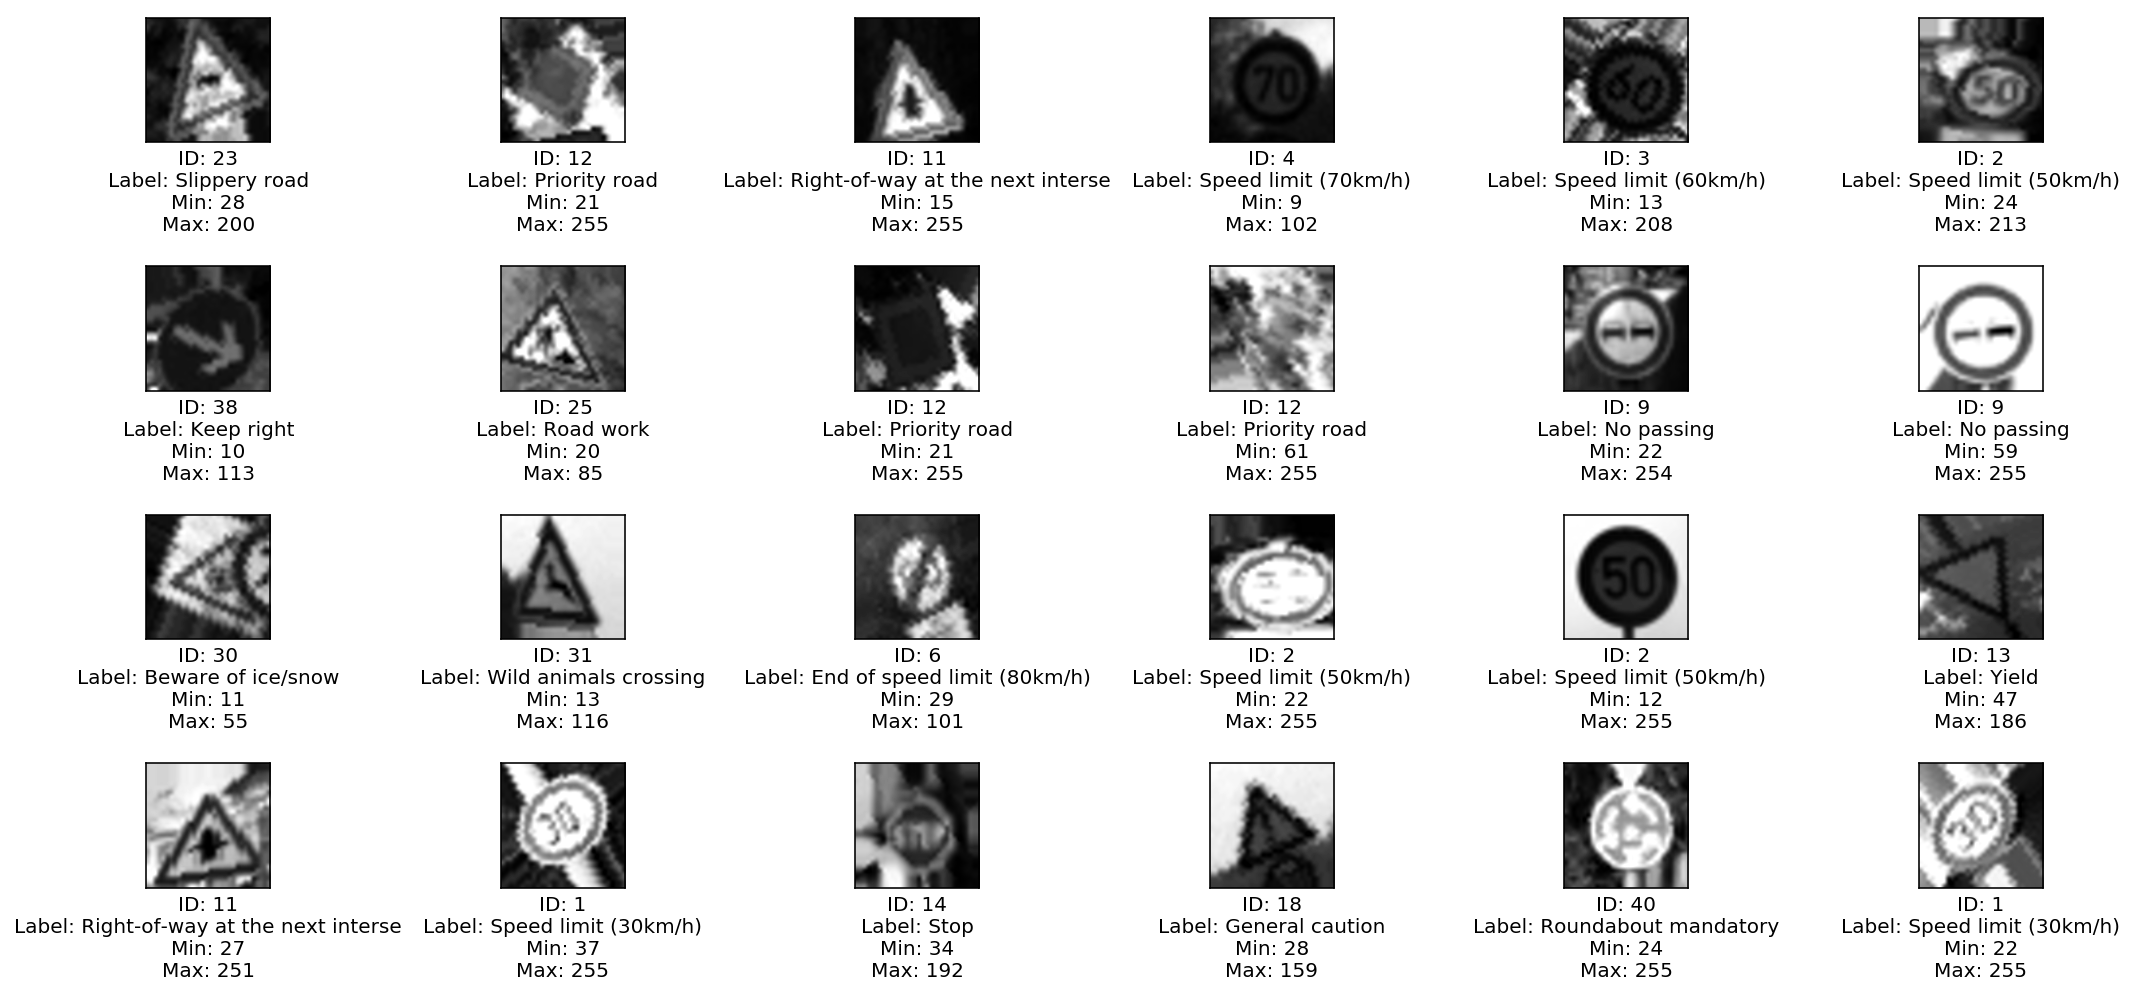

In [38]:
# Convert RGB images to grey scale and display the sample images.
train_features_grayscaled = utils.to_grayscale(train_features)
validation_features_grayscaled = utils.to_grayscale(valid_features)

utils.display_sample_images(train_features_grayscaled, train_labels, label_desc, is_gray=True)

In [39]:
train_features_grayscaled = utils.adaptive_histograms(train_features_grayscaled, add_blur=True)
validation_features_grayscaled = utils.adaptive_histograms(validation_features_grayscaled, add_blur=True)
print("Training and validation data processed.")

Training and validation data processed.


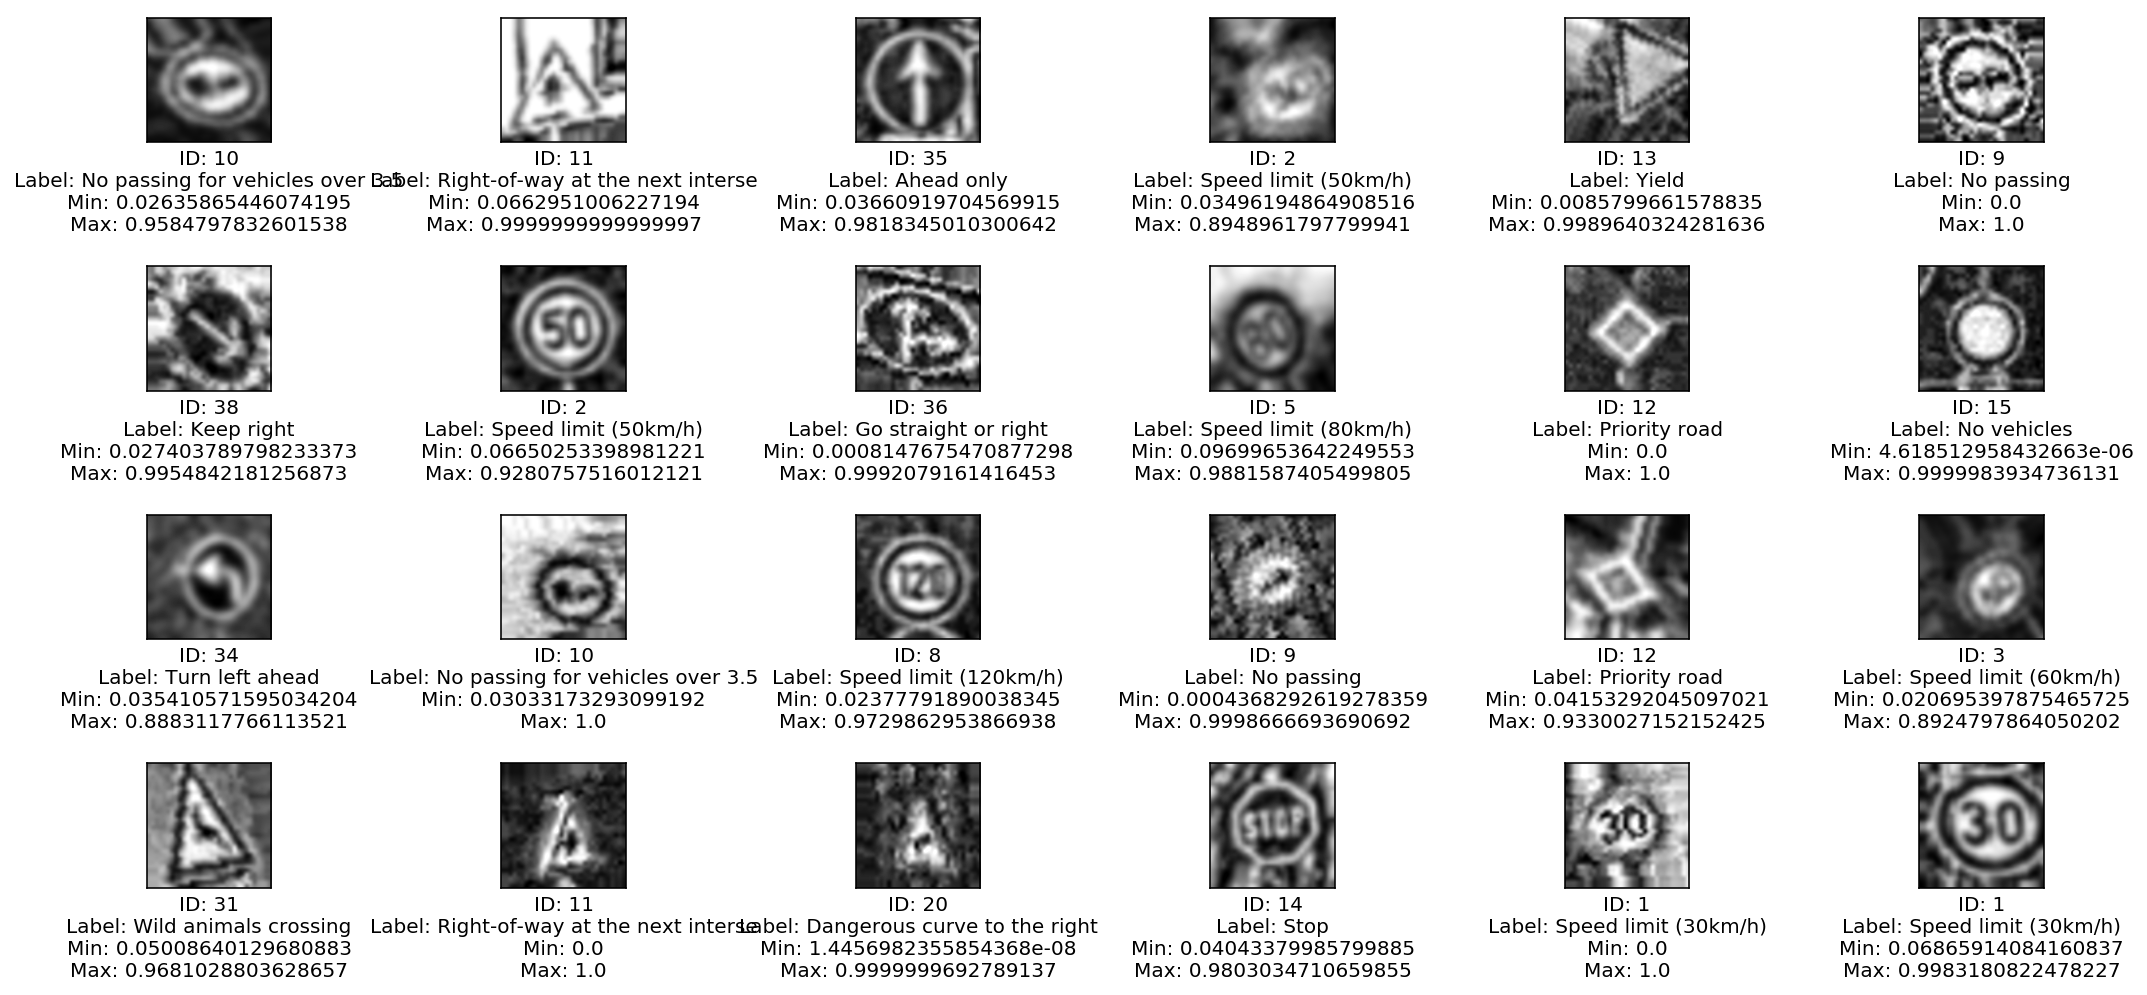

In [40]:
utils.display_sample_images(train_features_grayscaled, train_labels, label_desc, is_gray=True)

#### Normalization:

We are going to do a sample / image wise normalization. This is important to capture the relative intensity of each of the pixel.

In [41]:
# Normalize the gray scaled image.
training_features_normalized_grayscled = utils.normalize(train_features_grayscaled)
validation_features_normalized_grayscaled = utils.normalize(validation_features_grayscaled)

#### Data Ordering:

It is important to have the random order of the data. Let us confirm if the data is already in random order by printing top 20 labels. 

In [22]:
print(train_labels[:20])

[41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]


#### Random Ordering:

As we can see, the data is not randomly ordered. We will first shuffle the data for randomization. This may be necessary if we later decide to train on the batches rather than on the full dataset at a time.

In [42]:
training_features_normalized_grayscled, one_hot_encoded_training_labels = utils.shuffle(training_features_normalized_grayscled, one_hot_encoded_training_labels)


#### Persisting pre-processed data:

After all the pre-processing, we are going to persist the data so we can load it later and proceed from this point onward.

In [43]:
utils.save_preprocessed_training_data(config, training_features_normalized_grayscled, one_hot_encoded_training_labels)
utils.save_preprocessed_validation_data(config, validation_features_normalized_grayscaled, one_hot_encoded_validation_labels)

### Checkpoint - Resume from pre-processed data

We will reload the pre-processed data that we saved. This would ensure we don't have to repeat the data pre-processing work every time we run the entire codebase.

In [45]:
import utils
import sklearn
import numpy as np
import pandas as pd
from matplotlib.pyplot import plot as plt
%matplotlib inline

# Load the pre-processed training and validation set.
train_set_features, train_set_labels = utils.load_preprocessed_training_data(config)
valid_set_features, valid_set_labels = utils.load_preprocessed_validation_data(config)

# Make sure we have been able to load the appropriate dataset.
assert train_set_features.shape[0] == train_set_labels.shape[0] == 106445
assert valid_set_features.shape[0] == valid_set_labels.shape[0] == 4410

#### Compose the convolutional neural network:

Given we have the input tensors and layers defined, its time to compose the complete nueral network architecture using these building blocls.

In [46]:
def conv_net(x, prob_keep):
    '''
    Given the input data and the drop out rate, implement the 
    convolutional neural net with convolution, fully connected hidden layers
    and an outout layer.
    '''
    x_tensor = x
    
    # Convolution layer 1.
    conv_num_outputs = 32
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_output = tf.nn.dropout(conv_output, keep_prob=0.9)
    
    # Convolution layer 2.
    conv_num_outputs_second = 64
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(conv_output,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_output = tf.nn.dropout(conv_output, keep_prob=0.8)
    
    # Convolution layer 3.
    conv_num_outputs_second = 128
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [2, 2]
    pool_strides = [2, 2]
    conv_output = conv_maxpool_layer(conv_output,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_output = tf.nn.dropout(conv_output, keep_prob=keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    flattened = flatten(conv_output)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    
    # Fully connected layer 1.
    fc_hidden_layer_depth = 256
    fully_connected_output = fully_connected_layer(flattened, num_outputs=fc_hidden_layer_depth)
    fully_connected_output = tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)

    # Fully connected layer 2.
    fc_hidden_layer_depth = 256
    fully_connected_output = fully_connected_layer(fully_connected_output, num_outputs=fc_hidden_layer_depth)
    fully_connected_output = tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)
    
    # TODO: Apply an Output Layer
    # Set this to the number of classes
    # Function Definition from Above:
    final_output = output_layer(fully_connected_output, n_classes=43)
    
    # TODO: return output
    return final_output

In [48]:
# As described in the seminal paper by Pierre Sermanet and Yann LeCun 
# (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

def multiscale_conv_net(x, prob_keep):
    '''
    Given the input data and the drop out rate, implement the 
    convolutional neural net with convolution, fully connected hidden layers
    and an outout layer.
    '''
    x_tensor = x
    
    # Convolution layer 1.
    conv_num_outputs = 32
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [3, 3]
    pool_strides = [2, 2]
    conv_output_1 = conv_maxpool_layer(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Convolution layer 2.
    conv_num_outputs_second = 64
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [3, 3]
    pool_strides = [2, 2]
    conv_output_2 = conv_maxpool_layer(conv_output_1,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Convolution layer 3.
    conv_num_outputs_second = 128
    conv_ksize = [5, 5]
    conv_strides = [1, 1]
    pool_ksize = [3, 3]
    pool_strides = [2, 2]
    conv_output_3 = conv_maxpool_layer(conv_output_2,conv_num_outputs_second, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_output_3_final = tf.nn.dropout(conv_output_3, keep_prob=keep_prob)

    conv_output_1_final = tf.nn.max_pool(conv_output_1, [1, 4, 4, 1], [1, 2, 2, 1], "SAME")
    conv_output_2_final = tf.nn.max_pool(conv_output_2, [1, 4, 4, 1], [1, 2, 2, 1], "SAME")
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    flattened_1 = flatten(conv_output_1_final)
    flattened_2 = flatten(conv_output_2_final)
    flattened_3 = flatten(conv_output_3_final)
    
    print("Conv layer 1 shape: {} - {}".format(conv_output_1.shape, flattened_1.shape))
    print("Conv layer 2 shape: {} - {}".format(conv_output_2.shape, flattened_2.shape))
    print("Conv layer 3 shape: {} - {}".format(conv_output_3.shape, flattened_3.shape))
    
    flattened = tf.concat([flattened_3, flattened_2, flattened_1], axis=1)
    
    print("Multi scaling flattened layer - shape: {}".format(flattened.shape))
    
    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    
    # Fully connected layer 1.
    fc_hidden_layer_depth = 512
    fully_connected_output = fully_connected_layer(flattened, num_outputs=fc_hidden_layer_depth)
    fully_connected_output = tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)

    # Fully connected layer 2.
    fc_hidden_layer_depth = 192
    fully_connected_output = fully_connected_layer(fully_connected_output, num_outputs=fc_hidden_layer_depth)
    fully_connected_output = tf.nn.dropout(fully_connected_output, keep_prob=keep_prob)
    
    # TODO: Apply an Output Layer
    # Set this to the number of classes
    # Function Definition from Above:
    final_output = output_layer(fully_connected_output, n_classes=43)
    
    # TODO: return output
    return final_output

#### Reshaping the input data:

The tensorflow convolutional libs expect the input data to be 3 dimensional - Width, Height and Depth (Channels). After graysclaing the input image, we now have a 2D image of 32x32 each. To be able to use the standard tensorflow APIs, we are going to reshape the data into 32x32x1 dimensions.

In [49]:
train_set_features = train_set_features.reshape((-1, 32, 32, 1))
valid_set_features = valid_set_features.reshape((-1, 32, 32, 1))

### Training the model:

Since we have everything defined and implemented, we will start training the model on the training set and monitor the performance on the validation set.

In [50]:
import math

x, y, keep_prob = nn_input_data_tensors((32, 32, 1))
logits = conv_net(x, keep_prob)
cost, optimizer = optimize(logits, y)
accuracy = evaluate(logits, y)
save_model_path = "./gtsrb_model/"
epochs = 200
batch_size = 2048
num_batches = math.ceil(train_set_features.shape[0] / float(batch_size))
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(1, epochs+1):
        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = batch_start + batch_size
            sess.run(optimizer, feed_dict={x: train_set_features[batch_start:batch_end], y: train_set_labels[batch_start:batch_end], keep_prob : 0.6 })
            cost_result = sess.run(cost, feed_dict={x: train_set_features[batch_start:batch_end], y: train_set_labels[batch_start:batch_end], keep_prob: 1.0})
            validation_accuracy = sess.run(accuracy, feed_dict={x: valid_set_features, y: valid_set_labels, keep_prob: 1.0})
            print("Epoch: {}, Batch {} - Loss: {}, Validation Accuracy: {}".format(epoch,  batch, cost_result, validation_accuracy))
        if epoch % 25 == 0:
            print ("Saving the trained model.")
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)


Convolution layer - Input Image: (?, 32, 32, 1),  Weights: <tf.Variable 'conv_weight:0' shape=(5, 5, 1, 32) dtype=float32_ref>
Convolution layer - Input Image: (?, 16, 16, 32),  Weights: <tf.Variable 'conv_weight_1:0' shape=(5, 5, 32, 64) dtype=float32_ref>
Convolution layer - Input Image: (?, 8, 8, 64),  Weights: <tf.Variable 'conv_weight_2:0' shape=(5, 5, 64, 128) dtype=float32_ref>
Conv layer 1 shape: (?, 16, 16, 32) - (?, 2048)
Conv layer 2 shape: (?, 8, 8, 64) - (?, 1024)
Conv layer 3 shape: (?, 4, 4, 128) - (?, 2048)
Multi scaling flattened layer - shape: (?, 5120)
Fully connected layer weights: <tf.Variable 'Variable_3:0' shape=(5120, 512) dtype=float32_ref>
Fully connected layer weights: <tf.Variable 'Variable_5:0' shape=(512, 192) dtype=float32_ref>
Output layer weights: <tf.Variable 'Variable_7:0' shape=(192, 43) dtype=float32_ref>
Epoch: 1, Batch 0 - Loss: 3.6235098838806152, Validation Accuracy: 0.059183672070503235
Epoch: 1, Batch 1 - Loss: 3.618757724761963, Validation Ac

Epoch: 2, Batch 33 - Loss: 2.055119276046753, Validation Accuracy: 0.4374149739742279
Epoch: 2, Batch 34 - Loss: 2.023562431335449, Validation Accuracy: 0.42312926054000854
Epoch: 2, Batch 35 - Loss: 2.022674560546875, Validation Accuracy: 0.4521541893482208
Epoch: 2, Batch 36 - Loss: 2.006085157394409, Validation Accuracy: 0.4424036145210266
Epoch: 2, Batch 37 - Loss: 2.0350887775421143, Validation Accuracy: 0.43922901153564453
Epoch: 2, Batch 38 - Loss: 2.0237011909484863, Validation Accuracy: 0.44285714626312256
Epoch: 2, Batch 39 - Loss: 1.95438814163208, Validation Accuracy: 0.4841269850730896
Epoch: 2, Batch 40 - Loss: 1.9336285591125488, Validation Accuracy: 0.48344671726226807
Epoch: 2, Batch 41 - Loss: 1.8942177295684814, Validation Accuracy: 0.46394556760787964
Epoch: 2, Batch 42 - Loss: 1.9511408805847168, Validation Accuracy: 0.4809523820877075
Epoch: 2, Batch 43 - Loss: 1.9181597232818604, Validation Accuracy: 0.5077097415924072
Epoch: 2, Batch 44 - Loss: 1.828546881675720

Epoch: 4, Batch 24 - Loss: 1.0510179996490479, Validation Accuracy: 0.7088435292243958
Epoch: 4, Batch 25 - Loss: 1.0800096988677979, Validation Accuracy: 0.7068027257919312
Epoch: 4, Batch 26 - Loss: 1.094090223312378, Validation Accuracy: 0.6920635104179382
Epoch: 4, Batch 27 - Loss: 1.0656566619873047, Validation Accuracy: 0.7009070515632629
Epoch: 4, Batch 28 - Loss: 1.0731068849563599, Validation Accuracy: 0.7029478549957275
Epoch: 4, Batch 29 - Loss: 1.0722416639328003, Validation Accuracy: 0.7158730030059814
Epoch: 4, Batch 30 - Loss: 1.0992779731750488, Validation Accuracy: 0.7108843326568604
Epoch: 4, Batch 31 - Loss: 1.0603238344192505, Validation Accuracy: 0.7242630124092102
Epoch: 4, Batch 32 - Loss: 1.0304341316223145, Validation Accuracy: 0.7251700758934021
Epoch: 4, Batch 33 - Loss: 1.0314677953720093, Validation Accuracy: 0.7210884094238281
Epoch: 4, Batch 34 - Loss: 1.0122910737991333, Validation Accuracy: 0.7297052145004272
Epoch: 4, Batch 35 - Loss: 0.987800836563110

Epoch: 6, Batch 15 - Loss: 0.6665998697280884, Validation Accuracy: 0.8326530456542969
Epoch: 6, Batch 16 - Loss: 0.6936162710189819, Validation Accuracy: 0.8387755155563354
Epoch: 6, Batch 17 - Loss: 0.6596893072128296, Validation Accuracy: 0.8306122422218323
Epoch: 6, Batch 18 - Loss: 0.6435922384262085, Validation Accuracy: 0.8451247215270996
Epoch: 6, Batch 19 - Loss: 0.6504483222961426, Validation Accuracy: 0.8492063283920288
Epoch: 6, Batch 20 - Loss: 0.6625428795814514, Validation Accuracy: 0.8451247215270996
Epoch: 6, Batch 21 - Loss: 0.6317805051803589, Validation Accuracy: 0.8405895829200745
Epoch: 6, Batch 22 - Loss: 0.6321468353271484, Validation Accuracy: 0.8380952477455139
Epoch: 6, Batch 23 - Loss: 0.6293206214904785, Validation Accuracy: 0.839455783367157
Epoch: 6, Batch 24 - Loss: 0.6002710461616516, Validation Accuracy: 0.8451247215270996
Epoch: 6, Batch 25 - Loss: 0.6246805191040039, Validation Accuracy: 0.8489795923233032
Epoch: 6, Batch 26 - Loss: 0.626281499862670

Epoch: 8, Batch 6 - Loss: 0.48972076177597046, Validation Accuracy: 0.8875283598899841
Epoch: 8, Batch 7 - Loss: 0.44365236163139343, Validation Accuracy: 0.8997732400894165
Epoch: 8, Batch 8 - Loss: 0.48055681586265564, Validation Accuracy: 0.902721107006073
Epoch: 8, Batch 9 - Loss: 0.42291927337646484, Validation Accuracy: 0.902721107006073
Epoch: 8, Batch 10 - Loss: 0.4799741804599762, Validation Accuracy: 0.8961451053619385
Epoch: 8, Batch 11 - Loss: 0.4056287109851837, Validation Accuracy: 0.8970521688461304
Epoch: 8, Batch 12 - Loss: 0.4660876393318176, Validation Accuracy: 0.9031745791435242
Epoch: 8, Batch 13 - Loss: 0.472900927066803, Validation Accuracy: 0.9099773168563843
Epoch: 8, Batch 14 - Loss: 0.47795599699020386, Validation Accuracy: 0.9018140435218811
Epoch: 8, Batch 15 - Loss: 0.4494205117225647, Validation Accuracy: 0.9056689143180847
Epoch: 8, Batch 16 - Loss: 0.4619152247905731, Validation Accuracy: 0.9086167812347412
Epoch: 8, Batch 17 - Loss: 0.4458390176296234

Epoch: 9, Batch 49 - Loss: 0.3205174207687378, Validation Accuracy: 0.9405895471572876
Epoch: 9, Batch 50 - Loss: 0.30865219235420227, Validation Accuracy: 0.9328798055648804
Epoch: 9, Batch 51 - Loss: 0.3622976243495941, Validation Accuracy: 0.9251700639724731
Epoch: 10, Batch 0 - Loss: 0.32909098267555237, Validation Accuracy: 0.9260770678520203
Epoch: 10, Batch 1 - Loss: 0.348419189453125, Validation Accuracy: 0.9276643991470337
Epoch: 10, Batch 2 - Loss: 0.33424103260040283, Validation Accuracy: 0.9308390021324158
Epoch: 10, Batch 3 - Loss: 0.33475592732429504, Validation Accuracy: 0.9297052025794983
Epoch: 10, Batch 4 - Loss: 0.33300262689590454, Validation Accuracy: 0.9294784665107727
Epoch: 10, Batch 5 - Loss: 0.34357786178588867, Validation Accuracy: 0.9258503317832947
Epoch: 10, Batch 6 - Loss: 0.3268035650253296, Validation Accuracy: 0.9267573952674866
Epoch: 10, Batch 7 - Loss: 0.3214198052883148, Validation Accuracy: 0.9278911352157593
Epoch: 10, Batch 8 - Loss: 0.331335872

Epoch: 11, Batch 39 - Loss: 0.26361656188964844, Validation Accuracy: 0.9446712136268616
Epoch: 11, Batch 40 - Loss: 0.25418975949287415, Validation Accuracy: 0.9469387531280518
Epoch: 11, Batch 41 - Loss: 0.2228149026632309, Validation Accuracy: 0.9430838823318481
Epoch: 11, Batch 42 - Loss: 0.24951483309268951, Validation Accuracy: 0.9485260844230652
Epoch: 11, Batch 43 - Loss: 0.24807463586330414, Validation Accuracy: 0.9487528204917908
Epoch: 11, Batch 44 - Loss: 0.21232560276985168, Validation Accuracy: 0.9480725526809692
Epoch: 11, Batch 45 - Loss: 0.2293168008327484, Validation Accuracy: 0.9460317492485046
Epoch: 11, Batch 46 - Loss: 0.24592335522174835, Validation Accuracy: 0.9448979496955872
Epoch: 11, Batch 47 - Loss: 0.222260519862175, Validation Accuracy: 0.9512471556663513
Epoch: 11, Batch 48 - Loss: 0.24597740173339844, Validation Accuracy: 0.9512471556663513
Epoch: 11, Batch 49 - Loss: 0.23335513472557068, Validation Accuracy: 0.9487528204917908
Epoch: 11, Batch 50 - Los

Epoch: 13, Batch 28 - Loss: 0.19236183166503906, Validation Accuracy: 0.9544217586517334
Epoch: 13, Batch 29 - Loss: 0.2065844088792801, Validation Accuracy: 0.956462562084198
Epoch: 13, Batch 30 - Loss: 0.2077184021472931, Validation Accuracy: 0.9596371650695801
Epoch: 13, Batch 31 - Loss: 0.2146262377500534, Validation Accuracy: 0.956916093826294
Epoch: 13, Batch 32 - Loss: 0.1928103119134903, Validation Accuracy: 0.9532879590988159
Epoch: 13, Batch 33 - Loss: 0.2085031270980835, Validation Accuracy: 0.9507936239242554
Epoch: 13, Batch 34 - Loss: 0.1776133030653, Validation Accuracy: 0.9512471556663513
Epoch: 13, Batch 35 - Loss: 0.19397976994514465, Validation Accuracy: 0.9532879590988159
Epoch: 13, Batch 36 - Loss: 0.19564901292324066, Validation Accuracy: 0.9562358260154724
Epoch: 13, Batch 37 - Loss: 0.1983242630958557, Validation Accuracy: 0.9580498933792114
Epoch: 13, Batch 38 - Loss: 0.20243987441062927, Validation Accuracy: 0.9553288221359253
Epoch: 13, Batch 39 - Loss: 0.195

Epoch: 15, Batch 17 - Loss: 0.16691090166568756, Validation Accuracy: 0.9580498933792114
Epoch: 15, Batch 18 - Loss: 0.1655551791191101, Validation Accuracy: 0.9532879590988159
Epoch: 15, Batch 19 - Loss: 0.16620010137557983, Validation Accuracy: 0.958276629447937
Epoch: 15, Batch 20 - Loss: 0.16359315812587738, Validation Accuracy: 0.9628117680549622
Epoch: 15, Batch 21 - Loss: 0.16632576286792755, Validation Accuracy: 0.961904764175415
Epoch: 15, Batch 22 - Loss: 0.14915114641189575, Validation Accuracy: 0.961904764175415
Epoch: 15, Batch 23 - Loss: 0.17392681539058685, Validation Accuracy: 0.9551020264625549
Epoch: 15, Batch 24 - Loss: 0.15749242901802063, Validation Accuracy: 0.9548752903938293
Epoch: 15, Batch 25 - Loss: 0.15498347580432892, Validation Accuracy: 0.9609977602958679
Epoch: 15, Batch 26 - Loss: 0.15429985523223877, Validation Accuracy: 0.9594104290008545
Epoch: 15, Batch 27 - Loss: 0.16702771186828613, Validation Accuracy: 0.9596371650695801
Epoch: 15, Batch 28 - Los

Epoch: 17, Batch 6 - Loss: 0.1300157904624939, Validation Accuracy: 0.96417236328125
Epoch: 17, Batch 7 - Loss: 0.13474233448505402, Validation Accuracy: 0.9546485543251038
Epoch: 17, Batch 8 - Loss: 0.14069409668445587, Validation Accuracy: 0.960090696811676
Epoch: 17, Batch 9 - Loss: 0.11526080965995789, Validation Accuracy: 0.9648526310920715
Epoch: 17, Batch 10 - Loss: 0.1462687849998474, Validation Accuracy: 0.9673469662666321
Epoch: 17, Batch 11 - Loss: 0.11744342744350433, Validation Accuracy: 0.9684807062149048
Epoch: 17, Batch 12 - Loss: 0.1317862868309021, Validation Accuracy: 0.9657596349716187
Epoch: 17, Batch 13 - Loss: 0.15050312876701355, Validation Accuracy: 0.9614512324333191
Epoch: 17, Batch 14 - Loss: 0.14252476394176483, Validation Accuracy: 0.962358295917511
Epoch: 17, Batch 15 - Loss: 0.11770589649677277, Validation Accuracy: 0.9657596349716187
Epoch: 17, Batch 16 - Loss: 0.1367826908826828, Validation Accuracy: 0.9662131667137146
Epoch: 17, Batch 17 - Loss: 0.128

Epoch: 18, Batch 47 - Loss: 0.11234233528375626, Validation Accuracy: 0.9678004384040833
Epoch: 18, Batch 48 - Loss: 0.11928588896989822, Validation Accuracy: 0.9675737023353577
Epoch: 18, Batch 49 - Loss: 0.0992293730378151, Validation Accuracy: 0.9682539701461792
Epoch: 18, Batch 50 - Loss: 0.10464238375425339, Validation Accuracy: 0.9673469662666321
Epoch: 18, Batch 51 - Loss: 0.11286458373069763, Validation Accuracy: 0.9687075018882751
Epoch: 19, Batch 0 - Loss: 0.11143670976161957, Validation Accuracy: 0.9700680375099182
Epoch: 19, Batch 1 - Loss: 0.12162630259990692, Validation Accuracy: 0.9691609740257263
Epoch: 19, Batch 2 - Loss: 0.1044171005487442, Validation Accuracy: 0.9657596349716187
Epoch: 19, Batch 3 - Loss: 0.11699890345335007, Validation Accuracy: 0.9675737023353577
Epoch: 19, Batch 4 - Loss: 0.11110810190439224, Validation Accuracy: 0.9673469662666321
Epoch: 19, Batch 5 - Loss: 0.11549775302410126, Validation Accuracy: 0.9662131667137146
Epoch: 19, Batch 6 - Loss: 0.

Epoch: 20, Batch 36 - Loss: 0.08838044852018356, Validation Accuracy: 0.9739229083061218
Epoch: 20, Batch 37 - Loss: 0.09261497110128403, Validation Accuracy: 0.9741496443748474
Epoch: 20, Batch 38 - Loss: 0.09382463246583939, Validation Accuracy: 0.9730158448219299
Epoch: 20, Batch 39 - Loss: 0.09537927806377411, Validation Accuracy: 0.9702947735786438
Epoch: 20, Batch 40 - Loss: 0.09764166176319122, Validation Accuracy: 0.9684807062149048
Epoch: 20, Batch 41 - Loss: 0.0795261338353157, Validation Accuracy: 0.9687075018882751
Epoch: 20, Batch 42 - Loss: 0.09167052805423737, Validation Accuracy: 0.9702947735786438
Epoch: 20, Batch 43 - Loss: 0.0893893763422966, Validation Accuracy: 0.9718821048736572
Epoch: 20, Batch 44 - Loss: 0.07688243687152863, Validation Accuracy: 0.9730158448219299
Epoch: 20, Batch 45 - Loss: 0.08258075267076492, Validation Accuracy: 0.9702947735786438
Epoch: 20, Batch 46 - Loss: 0.0877816304564476, Validation Accuracy: 0.9684807062149048
Epoch: 20, Batch 47 - Lo

Epoch: 22, Batch 25 - Loss: 0.07574760168790817, Validation Accuracy: 0.9750567078590393
Epoch: 22, Batch 26 - Loss: 0.0713118389248848, Validation Accuracy: 0.974829912185669
Epoch: 22, Batch 27 - Loss: 0.07495515793561935, Validation Accuracy: 0.9734693765640259
Epoch: 22, Batch 28 - Loss: 0.06830169260501862, Validation Accuracy: 0.9716553092002869
Epoch: 22, Batch 29 - Loss: 0.07667740434408188, Validation Accuracy: 0.9721088409423828
Epoch: 22, Batch 30 - Loss: 0.07430712878704071, Validation Accuracy: 0.9730158448219299
Epoch: 22, Batch 31 - Loss: 0.07263991236686707, Validation Accuracy: 0.9734693765640259
Epoch: 22, Batch 32 - Loss: 0.06386037915945053, Validation Accuracy: 0.9734693765640259
Epoch: 22, Batch 33 - Loss: 0.07173658162355423, Validation Accuracy: 0.9741496443748474
Epoch: 22, Batch 34 - Loss: 0.06700175255537033, Validation Accuracy: 0.9721088409423828
Epoch: 22, Batch 35 - Loss: 0.07714782655239105, Validation Accuracy: 0.9721088409423828
Epoch: 22, Batch 36 - L

Epoch: 24, Batch 14 - Loss: 0.06548493355512619, Validation Accuracy: 0.9746031761169434
Epoch: 24, Batch 15 - Loss: 0.05989610031247139, Validation Accuracy: 0.974829912185669
Epoch: 24, Batch 16 - Loss: 0.06218090280890465, Validation Accuracy: 0.974829912185669
Epoch: 24, Batch 17 - Loss: 0.0599900484085083, Validation Accuracy: 0.9743764400482178
Epoch: 24, Batch 18 - Loss: 0.06029495596885681, Validation Accuracy: 0.9725623726844788
Epoch: 24, Batch 19 - Loss: 0.06780482828617096, Validation Accuracy: 0.9718821048736572
Epoch: 24, Batch 20 - Loss: 0.06087901443243027, Validation Accuracy: 0.9757369756698608
Epoch: 24, Batch 21 - Loss: 0.06435728073120117, Validation Accuracy: 0.976190447807312
Epoch: 24, Batch 22 - Loss: 0.059409622102975845, Validation Accuracy: 0.976643979549408
Epoch: 24, Batch 23 - Loss: 0.0628446713089943, Validation Accuracy: 0.9759637117385864
Epoch: 24, Batch 24 - Loss: 0.059416767209768295, Validation Accuracy: 0.9741496443748474
Epoch: 24, Batch 25 - Los

Epoch: 26, Batch 2 - Loss: 0.05115693807601929, Validation Accuracy: 0.9718821048736572
Epoch: 26, Batch 3 - Loss: 0.06224587559700012, Validation Accuracy: 0.9716553092002869
Epoch: 26, Batch 4 - Loss: 0.05351069197058678, Validation Accuracy: 0.9721088409423828
Epoch: 26, Batch 5 - Loss: 0.05568639561533928, Validation Accuracy: 0.9734693765640259
Epoch: 26, Batch 6 - Loss: 0.05376441776752472, Validation Accuracy: 0.9734693765640259
Epoch: 26, Batch 7 - Loss: 0.04918035492300987, Validation Accuracy: 0.9757369756698608
Epoch: 26, Batch 8 - Loss: 0.052500538527965546, Validation Accuracy: 0.9770975112915039
Epoch: 26, Batch 9 - Loss: 0.04202795401215553, Validation Accuracy: 0.976190447807312
Epoch: 26, Batch 10 - Loss: 0.05418005585670471, Validation Accuracy: 0.9746031761169434
Epoch: 26, Batch 11 - Loss: 0.04952072352170944, Validation Accuracy: 0.9736961722373962
Epoch: 26, Batch 12 - Loss: 0.053919386118650436, Validation Accuracy: 0.9750567078590393
Epoch: 26, Batch 13 - Loss: 

Epoch: 27, Batch 43 - Loss: 0.044129181653261185, Validation Accuracy: 0.9786847829818726
Epoch: 27, Batch 44 - Loss: 0.03659544140100479, Validation Accuracy: 0.9759637117385864
Epoch: 27, Batch 45 - Loss: 0.044720426201820374, Validation Accuracy: 0.9732426404953003
Epoch: 27, Batch 46 - Loss: 0.04715922847390175, Validation Accuracy: 0.9725623726844788
Epoch: 27, Batch 47 - Loss: 0.05005447566509247, Validation Accuracy: 0.9730158448219299
Epoch: 27, Batch 48 - Loss: 0.048715315759181976, Validation Accuracy: 0.9736961722373962
Epoch: 27, Batch 49 - Loss: 0.03892608359456062, Validation Accuracy: 0.9732426404953003
Epoch: 27, Batch 50 - Loss: 0.03855263441801071, Validation Accuracy: 0.9770975112915039
Epoch: 27, Batch 51 - Loss: 0.03921977058053017, Validation Accuracy: 0.9782313108444214
Epoch: 28, Batch 0 - Loss: 0.04816121608018875, Validation Accuracy: 0.9768707752227783
Epoch: 28, Batch 1 - Loss: 0.050822556018829346, Validation Accuracy: 0.976190447807312
Epoch: 28, Batch 2 -

Epoch: 29, Batch 32 - Loss: 0.0351438969373703, Validation Accuracy: 0.9696145057678223
Epoch: 29, Batch 33 - Loss: 0.041417475789785385, Validation Accuracy: 0.9707483053207397
Epoch: 29, Batch 34 - Loss: 0.042229942977428436, Validation Accuracy: 0.9752834439277649
Epoch: 29, Batch 35 - Loss: 0.05188769847154617, Validation Accuracy: 0.978004515171051
Epoch: 29, Batch 36 - Loss: 0.04008299857378006, Validation Accuracy: 0.9782313108444214
Epoch: 29, Batch 37 - Loss: 0.04503632336854935, Validation Accuracy: 0.9782313108444214
Epoch: 29, Batch 38 - Loss: 0.03949715197086334, Validation Accuracy: 0.978004515171051
Epoch: 29, Batch 39 - Loss: 0.04528331011533737, Validation Accuracy: 0.9759637117385864
Epoch: 29, Batch 40 - Loss: 0.04159625619649887, Validation Accuracy: 0.9750567078590393
Epoch: 29, Batch 41 - Loss: 0.03673848882317543, Validation Accuracy: 0.9734693765640259
Epoch: 29, Batch 42 - Loss: 0.037319112569093704, Validation Accuracy: 0.9752834439277649
Epoch: 29, Batch 43 -

Epoch: 31, Batch 21 - Loss: 0.035020627081394196, Validation Accuracy: 0.9807256460189819
Epoch: 31, Batch 22 - Loss: 0.027948303148150444, Validation Accuracy: 0.9809523820877075
Epoch: 31, Batch 23 - Loss: 0.029215004295110703, Validation Accuracy: 0.978458046913147
Epoch: 31, Batch 24 - Loss: 0.02833416685461998, Validation Accuracy: 0.9777777791023254
Epoch: 31, Batch 25 - Loss: 0.03004406951367855, Validation Accuracy: 0.9773242473602295
Epoch: 31, Batch 26 - Loss: 0.027109522372484207, Validation Accuracy: 0.9786847829818726
Epoch: 31, Batch 27 - Loss: 0.029012255370616913, Validation Accuracy: 0.980272114276886
Epoch: 31, Batch 28 - Loss: 0.03238390013575554, Validation Accuracy: 0.9791383147239685
Epoch: 31, Batch 29 - Loss: 0.03223257511854172, Validation Accuracy: 0.9789115786552429
Epoch: 31, Batch 30 - Loss: 0.02887994796037674, Validation Accuracy: 0.9800453782081604
Epoch: 31, Batch 31 - Loss: 0.03242680802941322, Validation Accuracy: 0.9791383147239685
Epoch: 31, Batch 3

Epoch: 33, Batch 9 - Loss: 0.021502338349819183, Validation Accuracy: 0.9775510430335999
Epoch: 33, Batch 10 - Loss: 0.030799459666013718, Validation Accuracy: 0.9789115786552429
Epoch: 33, Batch 11 - Loss: 0.029875725507736206, Validation Accuracy: 0.9768707752227783
Epoch: 33, Batch 12 - Loss: 0.03043065406382084, Validation Accuracy: 0.9757369756698608
Epoch: 33, Batch 13 - Loss: 0.03759961202740669, Validation Accuracy: 0.9730158448219299
Epoch: 33, Batch 14 - Loss: 0.03144180029630661, Validation Accuracy: 0.9739229083061218
Epoch: 33, Batch 15 - Loss: 0.02927376516163349, Validation Accuracy: 0.9768707752227783
Epoch: 33, Batch 16 - Loss: 0.03029485046863556, Validation Accuracy: 0.978004515171051
Epoch: 33, Batch 17 - Loss: 0.02844380773603916, Validation Accuracy: 0.9793650507926941
Epoch: 33, Batch 18 - Loss: 0.02810080721974373, Validation Accuracy: 0.9791383147239685
Epoch: 33, Batch 19 - Loss: 0.02785462886095047, Validation Accuracy: 0.9782313108444214
Epoch: 33, Batch 20 

Epoch: 34, Batch 49 - Loss: 0.02525712177157402, Validation Accuracy: 0.9764172434806824
Epoch: 34, Batch 50 - Loss: 0.023866603150963783, Validation Accuracy: 0.9743764400482178
Epoch: 34, Batch 51 - Loss: 0.02942832000553608, Validation Accuracy: 0.9716553092002869
Epoch: 35, Batch 0 - Loss: 0.031018773093819618, Validation Accuracy: 0.9718821048736572
Epoch: 35, Batch 1 - Loss: 0.030920589342713356, Validation Accuracy: 0.9725623726844788
Epoch: 35, Batch 2 - Loss: 0.024445926770567894, Validation Accuracy: 0.9736961722373962
Epoch: 35, Batch 3 - Loss: 0.032407283782958984, Validation Accuracy: 0.9764172434806824
Epoch: 35, Batch 4 - Loss: 0.026183124631643295, Validation Accuracy: 0.9782313108444214
Epoch: 35, Batch 5 - Loss: 0.025664515793323517, Validation Accuracy: 0.9768707752227783
Epoch: 35, Batch 6 - Loss: 0.02725858800113201, Validation Accuracy: 0.9777777791023254
Epoch: 35, Batch 7 - Loss: 0.022950973361730576, Validation Accuracy: 0.9786847829818726
Epoch: 35, Batch 8 - 

Epoch: 36, Batch 37 - Loss: 0.024858420714735985, Validation Accuracy: 0.9804988503456116
Epoch: 36, Batch 38 - Loss: 0.027890309691429138, Validation Accuracy: 0.9773242473602295
Epoch: 36, Batch 39 - Loss: 0.027481043711304665, Validation Accuracy: 0.976643979549408
Epoch: 36, Batch 40 - Loss: 0.023689953610301018, Validation Accuracy: 0.976643979549408
Epoch: 36, Batch 41 - Loss: 0.017988651990890503, Validation Accuracy: 0.9757369756698608
Epoch: 36, Batch 42 - Loss: 0.019819006323814392, Validation Accuracy: 0.976190447807312
Epoch: 36, Batch 43 - Loss: 0.021601326763629913, Validation Accuracy: 0.9773242473602295
Epoch: 36, Batch 44 - Loss: 0.015342041850090027, Validation Accuracy: 0.9793650507926941
Epoch: 36, Batch 45 - Loss: 0.023202791810035706, Validation Accuracy: 0.980272114276886
Epoch: 36, Batch 46 - Loss: 0.023326784372329712, Validation Accuracy: 0.9809523820877075
Epoch: 36, Batch 47 - Loss: 0.022829776629805565, Validation Accuracy: 0.97981858253479
Epoch: 36, Batch

Epoch: 38, Batch 25 - Loss: 0.01859378255903721, Validation Accuracy: 0.9823129177093506
Epoch: 38, Batch 26 - Loss: 0.01594294048845768, Validation Accuracy: 0.9818593859672546
Epoch: 38, Batch 27 - Loss: 0.014682416804134846, Validation Accuracy: 0.981632649898529
Epoch: 38, Batch 28 - Loss: 0.017347201704978943, Validation Accuracy: 0.9807256460189819
Epoch: 38, Batch 29 - Loss: 0.018844494596123695, Validation Accuracy: 0.9793650507926941
Epoch: 38, Batch 30 - Loss: 0.014378405176103115, Validation Accuracy: 0.9773242473602295
Epoch: 38, Batch 31 - Loss: 0.015924230217933655, Validation Accuracy: 0.9786847829818726
Epoch: 38, Batch 32 - Loss: 0.01550354901701212, Validation Accuracy: 0.9789115786552429
Epoch: 38, Batch 33 - Loss: 0.01976870372891426, Validation Accuracy: 0.9793650507926941
Epoch: 38, Batch 34 - Loss: 0.020020008087158203, Validation Accuracy: 0.9807256460189819
Epoch: 38, Batch 35 - Loss: 0.019984623417258263, Validation Accuracy: 0.97981858253479
Epoch: 38, Batch 

Epoch: 40, Batch 13 - Loss: 0.017213359475135803, Validation Accuracy: 0.9809523820877075
Epoch: 40, Batch 14 - Loss: 0.014024659991264343, Validation Accuracy: 0.9814059138298035
Epoch: 40, Batch 15 - Loss: 0.01437478605657816, Validation Accuracy: 0.9807256460189819
Epoch: 40, Batch 16 - Loss: 0.01247295644134283, Validation Accuracy: 0.9800453782081604
Epoch: 40, Batch 17 - Loss: 0.015727106481790543, Validation Accuracy: 0.9786847829818726
Epoch: 40, Batch 18 - Loss: 0.016825340688228607, Validation Accuracy: 0.9789115786552429
Epoch: 40, Batch 19 - Loss: 0.0166799146682024, Validation Accuracy: 0.97981858253479
Epoch: 40, Batch 20 - Loss: 0.011468261480331421, Validation Accuracy: 0.9809523820877075
Epoch: 40, Batch 21 - Loss: 0.013167008757591248, Validation Accuracy: 0.9823129177093506
Epoch: 40, Batch 22 - Loss: 0.017659002915024757, Validation Accuracy: 0.9823129177093506
Epoch: 40, Batch 23 - Loss: 0.01691354438662529, Validation Accuracy: 0.982086181640625
Epoch: 40, Batch 2

Epoch: 42, Batch 1 - Loss: 0.012796160764992237, Validation Accuracy: 0.981632649898529
Epoch: 42, Batch 2 - Loss: 0.010135579854249954, Validation Accuracy: 0.980272114276886
Epoch: 42, Batch 3 - Loss: 0.011363046243786812, Validation Accuracy: 0.9789115786552429
Epoch: 42, Batch 4 - Loss: 0.012721105478703976, Validation Accuracy: 0.9789115786552429
Epoch: 42, Batch 5 - Loss: 0.011108641512691975, Validation Accuracy: 0.9800453782081604
Epoch: 42, Batch 6 - Loss: 0.01239959616214037, Validation Accuracy: 0.9791383147239685
Epoch: 42, Batch 7 - Loss: 0.012485989369452, Validation Accuracy: 0.9807256460189819
Epoch: 42, Batch 8 - Loss: 0.010151591151952744, Validation Accuracy: 0.9814059138298035
Epoch: 42, Batch 9 - Loss: 0.008295610547065735, Validation Accuracy: 0.9793650507926941
Epoch: 42, Batch 10 - Loss: 0.013963082805275917, Validation Accuracy: 0.9800453782081604
Epoch: 42, Batch 11 - Loss: 0.014704255387187004, Validation Accuracy: 0.980272114276886
Epoch: 42, Batch 12 - Loss

Epoch: 43, Batch 41 - Loss: 0.00837463978677988, Validation Accuracy: 0.9804988503456116
Epoch: 43, Batch 42 - Loss: 0.007484224624931812, Validation Accuracy: 0.9814059138298035
Epoch: 43, Batch 43 - Loss: 0.009495528414845467, Validation Accuracy: 0.980272114276886
Epoch: 43, Batch 44 - Loss: 0.00861081201583147, Validation Accuracy: 0.9811791181564331
Epoch: 43, Batch 45 - Loss: 0.01106690801680088, Validation Accuracy: 0.9825396537780762
Epoch: 43, Batch 46 - Loss: 0.012135344557464123, Validation Accuracy: 0.982086181640625
Epoch: 43, Batch 47 - Loss: 0.011052027344703674, Validation Accuracy: 0.9807256460189819
Epoch: 43, Batch 48 - Loss: 0.00952628068625927, Validation Accuracy: 0.9814059138298035
Epoch: 43, Batch 49 - Loss: 0.01022009365260601, Validation Accuracy: 0.9809523820877075
Epoch: 43, Batch 50 - Loss: 0.009424608200788498, Validation Accuracy: 0.97981858253479
Epoch: 43, Batch 51 - Loss: 0.009716339409351349, Validation Accuracy: 0.978458046913147
Epoch: 44, Batch 0 -

Epoch: 45, Batch 29 - Loss: 0.011890682391822338, Validation Accuracy: 0.9789115786552429
Epoch: 45, Batch 30 - Loss: 0.008794326335191727, Validation Accuracy: 0.9804988503456116
Epoch: 45, Batch 31 - Loss: 0.009875244460999966, Validation Accuracy: 0.9791383147239685
Epoch: 45, Batch 32 - Loss: 0.008233235217630863, Validation Accuracy: 0.9768707752227783
Epoch: 45, Batch 33 - Loss: 0.009429520927369595, Validation Accuracy: 0.9759637117385864
Epoch: 45, Batch 34 - Loss: 0.009279828518629074, Validation Accuracy: 0.9775510430335999
Epoch: 45, Batch 35 - Loss: 0.009949439205229282, Validation Accuracy: 0.9782313108444214
Epoch: 45, Batch 36 - Loss: 0.0109131233766675, Validation Accuracy: 0.978458046913147
Epoch: 45, Batch 37 - Loss: 0.009000995196402073, Validation Accuracy: 0.97981858253479
Epoch: 45, Batch 38 - Loss: 0.006571437697857618, Validation Accuracy: 0.9804988503456116
Epoch: 45, Batch 39 - Loss: 0.011010129936039448, Validation Accuracy: 0.9811791181564331
Epoch: 45, Batc

Epoch: 47, Batch 17 - Loss: 0.008996618911623955, Validation Accuracy: 0.9800453782081604
Epoch: 47, Batch 18 - Loss: 0.010000967420637608, Validation Accuracy: 0.980272114276886
Epoch: 47, Batch 19 - Loss: 0.010885782539844513, Validation Accuracy: 0.9818593859672546
Epoch: 47, Batch 20 - Loss: 0.006132056470960379, Validation Accuracy: 0.9823129177093506
Epoch: 47, Batch 21 - Loss: 0.007581766694784164, Validation Accuracy: 0.9834467172622681
Epoch: 47, Batch 22 - Loss: 0.007790076546370983, Validation Accuracy: 0.983900249004364
Epoch: 47, Batch 23 - Loss: 0.008873596787452698, Validation Accuracy: 0.9832199811935425
Epoch: 47, Batch 24 - Loss: 0.007124341558665037, Validation Accuracy: 0.981632649898529
Epoch: 47, Batch 25 - Loss: 0.009514064528048038, Validation Accuracy: 0.982086181640625
Epoch: 47, Batch 26 - Loss: 0.006543225608766079, Validation Accuracy: 0.981632649898529
Epoch: 47, Batch 27 - Loss: 0.008753755129873753, Validation Accuracy: 0.9809523820877075
Epoch: 47, Batc

Epoch: 49, Batch 5 - Loss: 0.007603769190609455, Validation Accuracy: 0.9793650507926941
Epoch: 49, Batch 6 - Loss: 0.006459963507950306, Validation Accuracy: 0.9804988503456116
Epoch: 49, Batch 7 - Loss: 0.006341112311929464, Validation Accuracy: 0.9800453782081604
Epoch: 49, Batch 8 - Loss: 0.007643309887498617, Validation Accuracy: 0.9793650507926941
Epoch: 49, Batch 9 - Loss: 0.005166174378246069, Validation Accuracy: 0.9800453782081604
Epoch: 49, Batch 10 - Loss: 0.007496512960642576, Validation Accuracy: 0.978458046913147
Epoch: 49, Batch 11 - Loss: 0.007606571540236473, Validation Accuracy: 0.9809523820877075
Epoch: 49, Batch 12 - Loss: 0.005856798496097326, Validation Accuracy: 0.980272114276886
Epoch: 49, Batch 13 - Loss: 0.010168846696615219, Validation Accuracy: 0.9811791181564331
Epoch: 49, Batch 14 - Loss: 0.00751893687993288, Validation Accuracy: 0.981632649898529
Epoch: 49, Batch 15 - Loss: 0.0071656289510428905, Validation Accuracy: 0.981632649898529
Epoch: 49, Batch 16

Epoch: 50, Batch 45 - Loss: 0.006669209338724613, Validation Accuracy: 0.9795918464660645
Epoch: 50, Batch 46 - Loss: 0.006795850116759539, Validation Accuracy: 0.9818593859672546
Epoch: 50, Batch 47 - Loss: 0.005669772624969482, Validation Accuracy: 0.9829931855201721
Epoch: 50, Batch 48 - Loss: 0.0072365691885352135, Validation Accuracy: 0.982086181640625
Epoch: 50, Batch 49 - Loss: 0.005688166711479425, Validation Accuracy: 0.9829931855201721
Epoch: 50, Batch 50 - Loss: 0.005729267373681068, Validation Accuracy: 0.9823129177093506
Epoch: 50, Batch 51 - Loss: 0.0056349909864366055, Validation Accuracy: 0.9827664494514465
Saving the trained model.
Epoch: 51, Batch 0 - Loss: 0.007089854218065739, Validation Accuracy: 0.9811791181564331
Epoch: 51, Batch 1 - Loss: 0.006874929182231426, Validation Accuracy: 0.9823129177093506
Epoch: 51, Batch 2 - Loss: 0.0045224702917039394, Validation Accuracy: 0.9818593859672546
Epoch: 51, Batch 3 - Loss: 0.0055147698149085045, Validation Accuracy: 0.98

Epoch: 52, Batch 33 - Loss: 0.005493625998497009, Validation Accuracy: 0.9823129177093506
Epoch: 52, Batch 34 - Loss: 0.006383146625012159, Validation Accuracy: 0.9782313108444214
Epoch: 52, Batch 35 - Loss: 0.0061629535630345345, Validation Accuracy: 0.9777777791023254
Epoch: 52, Batch 36 - Loss: 0.006231994368135929, Validation Accuracy: 0.9811791181564331
Epoch: 52, Batch 37 - Loss: 0.005189632531255484, Validation Accuracy: 0.980272114276886
Epoch: 52, Batch 38 - Loss: 0.005910992156714201, Validation Accuracy: 0.9811791181564331
Epoch: 52, Batch 39 - Loss: 0.006710274610668421, Validation Accuracy: 0.9823129177093506
Epoch: 52, Batch 40 - Loss: 0.006427150219678879, Validation Accuracy: 0.9827664494514465
Epoch: 52, Batch 41 - Loss: 0.005431416444480419, Validation Accuracy: 0.982086181640625
Epoch: 52, Batch 42 - Loss: 0.005042048171162605, Validation Accuracy: 0.981632649898529
Epoch: 52, Batch 43 - Loss: 0.00508787902072072, Validation Accuracy: 0.9818593859672546
Epoch: 52, Ba

Epoch: 54, Batch 21 - Loss: 0.005042657721787691, Validation Accuracy: 0.9807256460189819
Epoch: 54, Batch 22 - Loss: 0.004221479874104261, Validation Accuracy: 0.9811791181564331
Epoch: 54, Batch 23 - Loss: 0.006226076744496822, Validation Accuracy: 0.982086181640625
Epoch: 54, Batch 24 - Loss: 0.0032684579491615295, Validation Accuracy: 0.9818593859672546
Epoch: 54, Batch 25 - Loss: 0.004771590232849121, Validation Accuracy: 0.9845805168151855
Epoch: 54, Batch 26 - Loss: 0.0035438351333141327, Validation Accuracy: 0.983900249004364
Epoch: 54, Batch 27 - Loss: 0.005033755209296942, Validation Accuracy: 0.9832199811935425
Epoch: 54, Batch 28 - Loss: 0.006081182975322008, Validation Accuracy: 0.9829931855201721
Epoch: 54, Batch 29 - Loss: 0.003789367852732539, Validation Accuracy: 0.9829931855201721
Epoch: 54, Batch 30 - Loss: 0.004997718147933483, Validation Accuracy: 0.9834467172622681
Epoch: 54, Batch 31 - Loss: 0.004414570052176714, Validation Accuracy: 0.9836734533309937
Epoch: 54,

Epoch: 56, Batch 9 - Loss: 0.002582252724096179, Validation Accuracy: 0.9823129177093506
Epoch: 56, Batch 10 - Loss: 0.00433669937774539, Validation Accuracy: 0.9836734533309937
Epoch: 56, Batch 11 - Loss: 0.006080403458327055, Validation Accuracy: 0.9843537211418152
Epoch: 56, Batch 12 - Loss: 0.005483740940690041, Validation Accuracy: 0.9827664494514465
Epoch: 56, Batch 13 - Loss: 0.005194154568016529, Validation Accuracy: 0.9832199811935425
Epoch: 56, Batch 14 - Loss: 0.0026082482654601336, Validation Accuracy: 0.9834467172622681
Epoch: 56, Batch 15 - Loss: 0.005041406024247408, Validation Accuracy: 0.9825396537780762
Epoch: 56, Batch 16 - Loss: 0.005301531869918108, Validation Accuracy: 0.9814059138298035
Epoch: 56, Batch 17 - Loss: 0.005051116459071636, Validation Accuracy: 0.982086181640625
Epoch: 56, Batch 18 - Loss: 0.0038461789954453707, Validation Accuracy: 0.9829931855201721
Epoch: 56, Batch 19 - Loss: 0.003910495899617672, Validation Accuracy: 0.9829931855201721
Epoch: 56, 

Epoch: 57, Batch 49 - Loss: 0.004119192715734243, Validation Accuracy: 0.9827664494514465
Epoch: 57, Batch 50 - Loss: 0.0033806683495640755, Validation Accuracy: 0.9818593859672546
Epoch: 57, Batch 51 - Loss: 0.0034021621104329824, Validation Accuracy: 0.9825396537780762
Epoch: 58, Batch 0 - Loss: 0.004686860833317041, Validation Accuracy: 0.9823129177093506
Epoch: 58, Batch 1 - Loss: 0.0067041427828371525, Validation Accuracy: 0.9843537211418152
Epoch: 58, Batch 2 - Loss: 0.004253162071108818, Validation Accuracy: 0.9854875206947327
Epoch: 58, Batch 3 - Loss: 0.0029515482019633055, Validation Accuracy: 0.9852607846260071
Epoch: 58, Batch 4 - Loss: 0.003611441468819976, Validation Accuracy: 0.9859410524368286
Epoch: 58, Batch 5 - Loss: 0.003637938527390361, Validation Accuracy: 0.9845805168151855
Epoch: 58, Batch 6 - Loss: 0.004916616249829531, Validation Accuracy: 0.9827664494514465
Epoch: 58, Batch 7 - Loss: 0.0038669323548674583, Validation Accuracy: 0.9829931855201721
Epoch: 58, Ba

Epoch: 59, Batch 37 - Loss: 0.004559278022497892, Validation Accuracy: 0.9857142567634583
Epoch: 59, Batch 38 - Loss: 0.006564274430274963, Validation Accuracy: 0.9848072528839111
Epoch: 59, Batch 39 - Loss: 0.0053239441476762295, Validation Accuracy: 0.9854875206947327
Epoch: 59, Batch 40 - Loss: 0.0037842285819351673, Validation Accuracy: 0.9873015880584717
Epoch: 59, Batch 41 - Loss: 0.0025419206358492374, Validation Accuracy: 0.9877551198005676
Epoch: 59, Batch 42 - Loss: 0.004835029132664204, Validation Accuracy: 0.9863945841789246
Epoch: 59, Batch 43 - Loss: 0.004698523785918951, Validation Accuracy: 0.9845805168151855
Epoch: 59, Batch 44 - Loss: 0.0037633145693689585, Validation Accuracy: 0.983900249004364
Epoch: 59, Batch 45 - Loss: 0.005705890711396933, Validation Accuracy: 0.9848072528839111
Epoch: 59, Batch 46 - Loss: 0.00446043536067009, Validation Accuracy: 0.9852607846260071
Epoch: 59, Batch 47 - Loss: 0.003198231803253293, Validation Accuracy: 0.9861677885055542
Epoch: 5

Epoch: 61, Batch 25 - Loss: 0.004697802010923624, Validation Accuracy: 0.9868480563163757
Epoch: 61, Batch 26 - Loss: 0.003820523153990507, Validation Accuracy: 0.9866213202476501
Epoch: 61, Batch 27 - Loss: 0.00433878879994154, Validation Accuracy: 0.9850339889526367
Epoch: 61, Batch 28 - Loss: 0.004750140942633152, Validation Accuracy: 0.9827664494514465
Epoch: 61, Batch 29 - Loss: 0.00411395775154233, Validation Accuracy: 0.9829931855201721
Epoch: 61, Batch 30 - Loss: 0.0041612619534134865, Validation Accuracy: 0.9850339889526367
Epoch: 61, Batch 31 - Loss: 0.003350386628881097, Validation Accuracy: 0.9859410524368286
Epoch: 61, Batch 32 - Loss: 0.002131728222593665, Validation Accuracy: 0.9850339889526367
Epoch: 61, Batch 33 - Loss: 0.0032314429990947247, Validation Accuracy: 0.982086181640625
Epoch: 61, Batch 34 - Loss: 0.0036265377420932055, Validation Accuracy: 0.9809523820877075
Epoch: 61, Batch 35 - Loss: 0.00392611138522625, Validation Accuracy: 0.981632649898529
Epoch: 61, B

Epoch: 63, Batch 12 - Loss: 0.0026618577539920807, Validation Accuracy: 0.9852607846260071
Epoch: 63, Batch 13 - Loss: 0.0029680361039936543, Validation Accuracy: 0.9850339889526367
Epoch: 63, Batch 14 - Loss: 0.002802719362080097, Validation Accuracy: 0.9845805168151855
Epoch: 63, Batch 15 - Loss: 0.0031239741947501898, Validation Accuracy: 0.983900249004364
Epoch: 63, Batch 16 - Loss: 0.0025656227953732014, Validation Accuracy: 0.9829931855201721
Epoch: 63, Batch 17 - Loss: 0.002191510982811451, Validation Accuracy: 0.9829931855201721
Epoch: 63, Batch 18 - Loss: 0.0029655112884938717, Validation Accuracy: 0.9841269850730896
Epoch: 63, Batch 19 - Loss: 0.003014172660186887, Validation Accuracy: 0.9845805168151855
Epoch: 63, Batch 20 - Loss: 0.0024792631156742573, Validation Accuracy: 0.9850339889526367
Epoch: 63, Batch 21 - Loss: 0.0022622498217970133, Validation Accuracy: 0.9854875206947327
Epoch: 63, Batch 22 - Loss: 0.0024527357891201973, Validation Accuracy: 0.9859410524368286
Epo

Epoch: 64, Batch 51 - Loss: 0.00218587601557374, Validation Accuracy: 0.9852607846260071
Epoch: 65, Batch 0 - Loss: 0.002664680127054453, Validation Accuracy: 0.9836734533309937
Epoch: 65, Batch 1 - Loss: 0.0020231937523931265, Validation Accuracy: 0.9836734533309937
Epoch: 65, Batch 2 - Loss: 0.002556674648076296, Validation Accuracy: 0.9841269850730896
Epoch: 65, Batch 3 - Loss: 0.003185736481100321, Validation Accuracy: 0.9823129177093506
Epoch: 65, Batch 4 - Loss: 0.003383444622159004, Validation Accuracy: 0.9825396537780762
Epoch: 65, Batch 5 - Loss: 0.0023431992158293724, Validation Accuracy: 0.9832199811935425
Epoch: 65, Batch 6 - Loss: 0.0024494724348187447, Validation Accuracy: 0.9841269850730896
Epoch: 65, Batch 7 - Loss: 0.002061956562101841, Validation Accuracy: 0.9859410524368286
Epoch: 65, Batch 8 - Loss: 0.002220757771283388, Validation Accuracy: 0.9868480563163757
Epoch: 65, Batch 9 - Loss: 0.0017367167165502906, Validation Accuracy: 0.9854875206947327
Epoch: 65, Batch 

Epoch: 66, Batch 38 - Loss: 0.0018080472946166992, Validation Accuracy: 0.9857142567634583
Epoch: 66, Batch 39 - Loss: 0.0024600126780569553, Validation Accuracy: 0.9850339889526367
Epoch: 66, Batch 40 - Loss: 0.0020312422420829535, Validation Accuracy: 0.9857142567634583
Epoch: 66, Batch 41 - Loss: 0.001697810017503798, Validation Accuracy: 0.9854875206947327
Epoch: 66, Batch 42 - Loss: 0.001778741367161274, Validation Accuracy: 0.9848072528839111
Epoch: 66, Batch 43 - Loss: 0.0019363892497494817, Validation Accuracy: 0.9845805168151855
Epoch: 66, Batch 44 - Loss: 0.002097190823405981, Validation Accuracy: 0.9859410524368286
Epoch: 66, Batch 45 - Loss: 0.0021892283111810684, Validation Accuracy: 0.9863945841789246
Epoch: 66, Batch 46 - Loss: 0.0016966548282653093, Validation Accuracy: 0.9854875206947327
Epoch: 66, Batch 47 - Loss: 0.0018301561940461397, Validation Accuracy: 0.9861677885055542
Epoch: 66, Batch 48 - Loss: 0.0015782470582053065, Validation Accuracy: 0.9859410524368286
Ep

Epoch: 68, Batch 25 - Loss: 0.0029835521709173918, Validation Accuracy: 0.9861677885055542
Epoch: 68, Batch 26 - Loss: 0.0016573977191001177, Validation Accuracy: 0.9859410524368286
Epoch: 68, Batch 27 - Loss: 0.001801755279302597, Validation Accuracy: 0.9866213202476501
Epoch: 68, Batch 28 - Loss: 0.0025915338192135096, Validation Accuracy: 0.9866213202476501
Epoch: 68, Batch 29 - Loss: 0.0016385006019845605, Validation Accuracy: 0.9868480563163757
Epoch: 68, Batch 30 - Loss: 0.0016872140113264322, Validation Accuracy: 0.9863945841789246
Epoch: 68, Batch 31 - Loss: 0.00207351241260767, Validation Accuracy: 0.9857142567634583
Epoch: 68, Batch 32 - Loss: 0.0024883931037038565, Validation Accuracy: 0.9854875206947327
Epoch: 68, Batch 33 - Loss: 0.002258016262203455, Validation Accuracy: 0.9854875206947327
Epoch: 68, Batch 34 - Loss: 0.0019438924500718713, Validation Accuracy: 0.9848072528839111
Epoch: 68, Batch 35 - Loss: 0.0017686983337625861, Validation Accuracy: 0.9852607846260071
Epo

Epoch: 70, Batch 12 - Loss: 0.0021122447215020657, Validation Accuracy: 0.9850339889526367
Epoch: 70, Batch 13 - Loss: 0.0015938698779791594, Validation Accuracy: 0.9850339889526367
Epoch: 70, Batch 14 - Loss: 0.001655291998758912, Validation Accuracy: 0.9848072528839111
Epoch: 70, Batch 15 - Loss: 0.002003203146159649, Validation Accuracy: 0.9843537211418152
Epoch: 70, Batch 16 - Loss: 0.0016208436572924256, Validation Accuracy: 0.9841269850730896
Epoch: 70, Batch 17 - Loss: 0.0015217878390103579, Validation Accuracy: 0.9845805168151855
Epoch: 70, Batch 18 - Loss: 0.0011852722382172942, Validation Accuracy: 0.9854875206947327
Epoch: 70, Batch 19 - Loss: 0.002311121439561248, Validation Accuracy: 0.9861677885055542
Epoch: 70, Batch 20 - Loss: 0.0015632081776857376, Validation Accuracy: 0.9866213202476501
Epoch: 70, Batch 21 - Loss: 0.0013852263800799847, Validation Accuracy: 0.9870748519897461
Epoch: 70, Batch 22 - Loss: 0.0011503364657983184, Validation Accuracy: 0.9861677885055542
Ep

Epoch: 71, Batch 51 - Loss: 0.0014194039395079017, Validation Accuracy: 0.983900249004364
Epoch: 72, Batch 0 - Loss: 0.0019042602507397532, Validation Accuracy: 0.982086181640625
Epoch: 72, Batch 1 - Loss: 0.0017631410155445337, Validation Accuracy: 0.9818593859672546
Epoch: 72, Batch 2 - Loss: 0.0012370295589789748, Validation Accuracy: 0.9829931855201721
Epoch: 72, Batch 3 - Loss: 0.0011380357900634408, Validation Accuracy: 0.983900249004364
Epoch: 72, Batch 4 - Loss: 0.00186027935706079, Validation Accuracy: 0.983900249004364
Epoch: 72, Batch 5 - Loss: 0.0014840037329122424, Validation Accuracy: 0.9836734533309937
Epoch: 72, Batch 6 - Loss: 0.0015556480502709746, Validation Accuracy: 0.983900249004364
Epoch: 72, Batch 7 - Loss: 0.0010943873785436153, Validation Accuracy: 0.9843537211418152
Epoch: 72, Batch 8 - Loss: 0.0013359382282942533, Validation Accuracy: 0.9859410524368286
Epoch: 72, Batch 9 - Loss: 0.0006863066810183227, Validation Accuracy: 0.9857142567634583
Epoch: 72, Batch

Epoch: 73, Batch 38 - Loss: 0.0015958050498738885, Validation Accuracy: 0.9836734533309937
Epoch: 73, Batch 39 - Loss: 0.0021174666471779346, Validation Accuracy: 0.9843537211418152
Epoch: 73, Batch 40 - Loss: 0.003157060593366623, Validation Accuracy: 0.9845805168151855
Epoch: 73, Batch 41 - Loss: 0.0019415845163166523, Validation Accuracy: 0.9848072528839111
Epoch: 73, Batch 42 - Loss: 0.0019839757587760687, Validation Accuracy: 0.9843537211418152
Epoch: 73, Batch 43 - Loss: 0.0024501224979758263, Validation Accuracy: 0.9848072528839111
Epoch: 73, Batch 44 - Loss: 0.001345068565569818, Validation Accuracy: 0.983900249004364
Epoch: 73, Batch 45 - Loss: 0.002079416997730732, Validation Accuracy: 0.9841269850730896
Epoch: 73, Batch 46 - Loss: 0.0011557582765817642, Validation Accuracy: 0.9843537211418152
Epoch: 73, Batch 47 - Loss: 0.0011609600624069571, Validation Accuracy: 0.9841269850730896
Epoch: 73, Batch 48 - Loss: 0.001458560349419713, Validation Accuracy: 0.9836734533309937
Epoc

Epoch: 75, Batch 25 - Loss: 0.0007785883499309421, Validation Accuracy: 0.9848072528839111
Epoch: 75, Batch 26 - Loss: 0.000908356043510139, Validation Accuracy: 0.9848072528839111
Epoch: 75, Batch 27 - Loss: 0.0018579760799184442, Validation Accuracy: 0.9850339889526367
Epoch: 75, Batch 28 - Loss: 0.0009243786334991455, Validation Accuracy: 0.9841269850730896
Epoch: 75, Batch 29 - Loss: 0.0008337701437994838, Validation Accuracy: 0.9852607846260071
Epoch: 75, Batch 30 - Loss: 0.0013991182204335928, Validation Accuracy: 0.9852607846260071
Epoch: 75, Batch 31 - Loss: 0.0022794599644839764, Validation Accuracy: 0.9857142567634583
Epoch: 75, Batch 32 - Loss: 0.0008747895481064916, Validation Accuracy: 0.9861677885055542
Epoch: 75, Batch 33 - Loss: 0.0008920943364500999, Validation Accuracy: 0.9866213202476501
Epoch: 75, Batch 34 - Loss: 0.0012252808082848787, Validation Accuracy: 0.9875283241271973
Epoch: 75, Batch 35 - Loss: 0.0011609310749918222, Validation Accuracy: 0.9850339889526367


Epoch: 77, Batch 12 - Loss: 0.001479355152696371, Validation Accuracy: 0.9845805168151855
Epoch: 77, Batch 13 - Loss: 0.0017983285943046212, Validation Accuracy: 0.9852607846260071
Epoch: 77, Batch 14 - Loss: 0.001593573484569788, Validation Accuracy: 0.9852607846260071
Epoch: 77, Batch 15 - Loss: 0.0015519747976213694, Validation Accuracy: 0.9848072528839111
Epoch: 77, Batch 16 - Loss: 0.0014022763352841139, Validation Accuracy: 0.9854875206947327
Epoch: 77, Batch 17 - Loss: 0.0010731823276728392, Validation Accuracy: 0.983900249004364
Epoch: 77, Batch 18 - Loss: 0.002533520106226206, Validation Accuracy: 0.9852607846260071
Epoch: 77, Batch 19 - Loss: 0.0013561919331550598, Validation Accuracy: 0.9857142567634583
Epoch: 77, Batch 20 - Loss: 0.0008809246937744319, Validation Accuracy: 0.9863945841789246
Epoch: 77, Batch 21 - Loss: 0.0012378424871712923, Validation Accuracy: 0.9863945841789246
Epoch: 77, Batch 22 - Loss: 0.002228786004707217, Validation Accuracy: 0.9859410524368286
Epoc

Epoch: 78, Batch 51 - Loss: 0.0016460379119962454, Validation Accuracy: 0.9852607846260071
Epoch: 79, Batch 0 - Loss: 0.0009127955418080091, Validation Accuracy: 0.9845805168151855
Epoch: 79, Batch 1 - Loss: 0.0007583663682453334, Validation Accuracy: 0.9852607846260071
Epoch: 79, Batch 2 - Loss: 0.0007447989191859961, Validation Accuracy: 0.9845805168151855
Epoch: 79, Batch 3 - Loss: 0.0010034512961283326, Validation Accuracy: 0.9859410524368286
Epoch: 79, Batch 4 - Loss: 0.0010798319708555937, Validation Accuracy: 0.9863945841789246
Epoch: 79, Batch 5 - Loss: 0.00100183195900172, Validation Accuracy: 0.9861677885055542
Epoch: 79, Batch 6 - Loss: 0.0008756057941354811, Validation Accuracy: 0.9868480563163757
Epoch: 79, Batch 7 - Loss: 0.0006528546218760312, Validation Accuracy: 0.9854875206947327
Epoch: 79, Batch 8 - Loss: 0.0006406997563317418, Validation Accuracy: 0.9863945841789246
Epoch: 79, Batch 9 - Loss: 0.00088440504623577, Validation Accuracy: 0.9859410524368286
Epoch: 79, Ba

Epoch: 80, Batch 38 - Loss: 0.0009511730168014765, Validation Accuracy: 0.9852607846260071
Epoch: 80, Batch 39 - Loss: 0.0013179704546928406, Validation Accuracy: 0.9859410524368286
Epoch: 80, Batch 40 - Loss: 0.0007374869892373681, Validation Accuracy: 0.9850339889526367
Epoch: 80, Batch 41 - Loss: 0.0007742375019006431, Validation Accuracy: 0.9852607846260071
Epoch: 80, Batch 42 - Loss: 0.0007238672696985304, Validation Accuracy: 0.9845805168151855
Epoch: 80, Batch 43 - Loss: 0.0012818442191928625, Validation Accuracy: 0.9854875206947327
Epoch: 80, Batch 44 - Loss: 0.0005774208111688495, Validation Accuracy: 0.9852607846260071
Epoch: 80, Batch 45 - Loss: 0.0013404198689386249, Validation Accuracy: 0.9850339889526367
Epoch: 80, Batch 46 - Loss: 0.0009320243261754513, Validation Accuracy: 0.9859410524368286
Epoch: 80, Batch 47 - Loss: 0.0004550647281575948, Validation Accuracy: 0.9854875206947327
Epoch: 80, Batch 48 - Loss: 0.0006462287274189293, Validation Accuracy: 0.983900249004364


Epoch: 82, Batch 25 - Loss: 0.0014845486730337143, Validation Accuracy: 0.9861677885055542
Epoch: 82, Batch 26 - Loss: 0.0025549379643052816, Validation Accuracy: 0.9866213202476501
Epoch: 82, Batch 27 - Loss: 0.001702598761767149, Validation Accuracy: 0.9857142567634583
Epoch: 82, Batch 28 - Loss: 0.0012462608283385634, Validation Accuracy: 0.9850339889526367
Epoch: 82, Batch 29 - Loss: 0.0008958960534073412, Validation Accuracy: 0.9836734533309937
Epoch: 82, Batch 30 - Loss: 0.0020668774377554655, Validation Accuracy: 0.983900249004364
Epoch: 82, Batch 31 - Loss: 0.0011397405760362744, Validation Accuracy: 0.9854875206947327
Epoch: 82, Batch 32 - Loss: 0.0009308200678788126, Validation Accuracy: 0.9859410524368286
Epoch: 82, Batch 33 - Loss: 0.0010607762960717082, Validation Accuracy: 0.9861677885055542
Epoch: 82, Batch 34 - Loss: 0.0014561202842742205, Validation Accuracy: 0.9861677885055542
Epoch: 82, Batch 35 - Loss: 0.00097741954959929, Validation Accuracy: 0.9870748519897461
Epo

Epoch: 84, Batch 12 - Loss: 0.00036590994568541646, Validation Accuracy: 0.9859410524368286
Epoch: 84, Batch 13 - Loss: 0.0005702496273443103, Validation Accuracy: 0.9859410524368286
Epoch: 84, Batch 14 - Loss: 0.0006596308667212725, Validation Accuracy: 0.9870748519897461
Epoch: 84, Batch 15 - Loss: 0.0004572885809466243, Validation Accuracy: 0.9868480563163757
Epoch: 84, Batch 16 - Loss: 0.0007536463090218604, Validation Accuracy: 0.9859410524368286
Epoch: 84, Batch 17 - Loss: 0.0005924862343817949, Validation Accuracy: 0.9854875206947327
Epoch: 84, Batch 18 - Loss: 0.0005616451380774379, Validation Accuracy: 0.9861677885055542
Epoch: 84, Batch 19 - Loss: 0.0008574501262046397, Validation Accuracy: 0.9863945841789246
Epoch: 84, Batch 20 - Loss: 0.0008457896765321493, Validation Accuracy: 0.9861677885055542
Epoch: 84, Batch 21 - Loss: 0.0006645206012763083, Validation Accuracy: 0.9852607846260071
Epoch: 84, Batch 22 - Loss: 0.0009056773269549012, Validation Accuracy: 0.984807252883911

Epoch: 85, Batch 51 - Loss: 0.0012420723214745522, Validation Accuracy: 0.9845805168151855
Epoch: 86, Batch 0 - Loss: 0.0006520735914818943, Validation Accuracy: 0.983900249004364
Epoch: 86, Batch 1 - Loss: 0.0007560501107946038, Validation Accuracy: 0.9843537211418152
Epoch: 86, Batch 2 - Loss: 0.0007507703267037868, Validation Accuracy: 0.9850339889526367
Epoch: 86, Batch 3 - Loss: 0.0006163069629110396, Validation Accuracy: 0.9850339889526367
Epoch: 86, Batch 4 - Loss: 0.0009145797812379897, Validation Accuracy: 0.9834467172622681
Epoch: 86, Batch 5 - Loss: 0.0008774565067142248, Validation Accuracy: 0.9809523820877075
Epoch: 86, Batch 6 - Loss: 0.002033939817920327, Validation Accuracy: 0.9818593859672546
Epoch: 86, Batch 7 - Loss: 0.001233675517141819, Validation Accuracy: 0.9827664494514465
Epoch: 86, Batch 8 - Loss: 0.0005561019061133265, Validation Accuracy: 0.9845805168151855
Epoch: 86, Batch 9 - Loss: 0.00031350384233519435, Validation Accuracy: 0.9854875206947327
Epoch: 86, 

Epoch: 87, Batch 38 - Loss: 0.000451017142040655, Validation Accuracy: 0.9868480563163757
Epoch: 87, Batch 39 - Loss: 0.001184455817565322, Validation Accuracy: 0.9868480563163757
Epoch: 87, Batch 40 - Loss: 0.0005986245814710855, Validation Accuracy: 0.9868480563163757
Epoch: 87, Batch 41 - Loss: 0.00028970319544896483, Validation Accuracy: 0.9857142567634583
Epoch: 87, Batch 42 - Loss: 0.00042317237239331007, Validation Accuracy: 0.9845805168151855
Epoch: 87, Batch 43 - Loss: 0.0005326400278136134, Validation Accuracy: 0.9843537211418152
Epoch: 87, Batch 44 - Loss: 0.0006306278519332409, Validation Accuracy: 0.9841269850730896
Epoch: 87, Batch 45 - Loss: 0.0015255373436957598, Validation Accuracy: 0.983900249004364
Epoch: 87, Batch 46 - Loss: 0.0006561764748767018, Validation Accuracy: 0.9845805168151855
Epoch: 87, Batch 47 - Loss: 0.0003958734741900116, Validation Accuracy: 0.9845805168151855
Epoch: 87, Batch 48 - Loss: 0.000777921115513891, Validation Accuracy: 0.9845805168151855
E

Epoch: 89, Batch 25 - Loss: 0.0006132970447652042, Validation Accuracy: 0.9866213202476501
Epoch: 89, Batch 26 - Loss: 0.0005571289220824838, Validation Accuracy: 0.9866213202476501
Epoch: 89, Batch 27 - Loss: 0.0008157274569384754, Validation Accuracy: 0.9857142567634583
Epoch: 89, Batch 28 - Loss: 0.0006152485148049891, Validation Accuracy: 0.9859410524368286
Epoch: 89, Batch 29 - Loss: 0.00035219191340729594, Validation Accuracy: 0.9859410524368286
Epoch: 89, Batch 30 - Loss: 0.0008153399685397744, Validation Accuracy: 0.9861677885055542
Epoch: 89, Batch 31 - Loss: 0.0006736318464390934, Validation Accuracy: 0.9863945841789246
Epoch: 89, Batch 32 - Loss: 0.001278852578252554, Validation Accuracy: 0.9861677885055542
Epoch: 89, Batch 33 - Loss: 0.0014156296383589506, Validation Accuracy: 0.9861677885055542
Epoch: 89, Batch 34 - Loss: 0.0016284289304167032, Validation Accuracy: 0.9875283241271973
Epoch: 89, Batch 35 - Loss: 0.0007449424010701478, Validation Accuracy: 0.9882085919380188

Epoch: 91, Batch 12 - Loss: 0.0006384787266142666, Validation Accuracy: 0.9863945841789246
Epoch: 91, Batch 13 - Loss: 0.0005473707569763064, Validation Accuracy: 0.9854875206947327
Epoch: 91, Batch 14 - Loss: 0.0007639661780558527, Validation Accuracy: 0.9861677885055542
Epoch: 91, Batch 15 - Loss: 0.0004018658946733922, Validation Accuracy: 0.9857142567634583
Epoch: 91, Batch 16 - Loss: 0.0007074446766637266, Validation Accuracy: 0.9848072528839111
Epoch: 91, Batch 17 - Loss: 0.0010961680673062801, Validation Accuracy: 0.9850339889526367
Epoch: 91, Batch 18 - Loss: 0.0009526645299047232, Validation Accuracy: 0.9852607846260071
Epoch: 91, Batch 19 - Loss: 0.0006467996863648295, Validation Accuracy: 0.9861677885055542
Epoch: 91, Batch 20 - Loss: 0.00043642165837809443, Validation Accuracy: 0.9859410524368286
Epoch: 91, Batch 21 - Loss: 0.00044461165089160204, Validation Accuracy: 0.9870748519897461
Epoch: 91, Batch 22 - Loss: 0.0008926022564992309, Validation Accuracy: 0.98684805631637

Epoch: 92, Batch 51 - Loss: 0.0006831471109762788, Validation Accuracy: 0.9877551198005676
Epoch: 93, Batch 0 - Loss: 0.0006236241315491498, Validation Accuracy: 0.9873015880584717
Epoch: 93, Batch 1 - Loss: 0.0006990167894400656, Validation Accuracy: 0.9870748519897461
Epoch: 93, Batch 2 - Loss: 0.0006220285431481898, Validation Accuracy: 0.9863945841789246
Epoch: 93, Batch 3 - Loss: 0.0008487349259667099, Validation Accuracy: 0.9870748519897461
Epoch: 93, Batch 4 - Loss: 0.001309047220274806, Validation Accuracy: 0.9863945841789246
Epoch: 93, Batch 5 - Loss: 0.0006530086975544691, Validation Accuracy: 0.9863945841789246
Epoch: 93, Batch 6 - Loss: 0.0005963497096672654, Validation Accuracy: 0.9850339889526367
Epoch: 93, Batch 7 - Loss: 0.0005548449698835611, Validation Accuracy: 0.9857142567634583
Epoch: 93, Batch 8 - Loss: 0.0003602666256483644, Validation Accuracy: 0.9861677885055542
Epoch: 93, Batch 9 - Loss: 0.00043920587631873786, Validation Accuracy: 0.9873015880584717
Epoch: 93

Epoch: 94, Batch 38 - Loss: 0.0008900054381228983, Validation Accuracy: 0.9863945841789246
Epoch: 94, Batch 39 - Loss: 0.0010390818351879716, Validation Accuracy: 0.9866213202476501
Epoch: 94, Batch 40 - Loss: 0.0006238598143681884, Validation Accuracy: 0.9884353876113892
Epoch: 94, Batch 41 - Loss: 0.0006303196423687041, Validation Accuracy: 0.9891156554222107
Epoch: 94, Batch 42 - Loss: 0.00035881088115274906, Validation Accuracy: 0.9888888597488403
Epoch: 94, Batch 43 - Loss: 0.001983823487535119, Validation Accuracy: 0.9893423914909363
Epoch: 94, Batch 44 - Loss: 0.0008364481036551297, Validation Accuracy: 0.9893423914909363
Epoch: 94, Batch 45 - Loss: 0.0008591991499997675, Validation Accuracy: 0.9886621236801147
Epoch: 94, Batch 46 - Loss: 0.00095479836454615, Validation Accuracy: 0.9879818558692932
Epoch: 94, Batch 47 - Loss: 0.00033304138923995197, Validation Accuracy: 0.9879818558692932
Epoch: 94, Batch 48 - Loss: 0.0006898102583363652, Validation Accuracy: 0.9882085919380188


Epoch: 96, Batch 25 - Loss: 0.0012281168019399047, Validation Accuracy: 0.9863945841789246
Epoch: 96, Batch 26 - Loss: 0.00035673679667524993, Validation Accuracy: 0.9873015880584717
Epoch: 96, Batch 27 - Loss: 0.0005631822859868407, Validation Accuracy: 0.9875283241271973
Epoch: 96, Batch 28 - Loss: 0.0003956330183427781, Validation Accuracy: 0.9875283241271973
Epoch: 96, Batch 29 - Loss: 0.0005106223397888243, Validation Accuracy: 0.9875283241271973
Epoch: 96, Batch 30 - Loss: 0.00037715048529207706, Validation Accuracy: 0.9875283241271973
Epoch: 96, Batch 31 - Loss: 0.00041132434853352606, Validation Accuracy: 0.9879818558692932
Epoch: 96, Batch 32 - Loss: 0.0007347847567871213, Validation Accuracy: 0.9875283241271973
Epoch: 96, Batch 33 - Loss: 0.0005921932170167565, Validation Accuracy: 0.9866213202476501
Epoch: 96, Batch 34 - Loss: 0.0009849125053733587, Validation Accuracy: 0.9861677885055542
Epoch: 96, Batch 35 - Loss: 0.0004360141756478697, Validation Accuracy: 0.9861677885055

Epoch: 98, Batch 12 - Loss: 0.0021180235780775547, Validation Accuracy: 0.9875283241271973
Epoch: 98, Batch 13 - Loss: 0.0009249683935195208, Validation Accuracy: 0.9870748519897461
Epoch: 98, Batch 14 - Loss: 0.0004318295686971396, Validation Accuracy: 0.9877551198005676
Epoch: 98, Batch 15 - Loss: 0.0006734800990670919, Validation Accuracy: 0.9877551198005676
Epoch: 98, Batch 16 - Loss: 0.000646027794573456, Validation Accuracy: 0.9879818558692932
Epoch: 98, Batch 17 - Loss: 0.002544294809922576, Validation Accuracy: 0.9861677885055542
Epoch: 98, Batch 18 - Loss: 0.0005251106340438128, Validation Accuracy: 0.9884353876113892
Epoch: 98, Batch 19 - Loss: 0.0011348046828061342, Validation Accuracy: 0.9884353876113892
Epoch: 98, Batch 20 - Loss: 0.0030334473121911287, Validation Accuracy: 0.9875283241271973
Epoch: 98, Batch 21 - Loss: 0.002032659715041518, Validation Accuracy: 0.9866213202476501
Epoch: 98, Batch 22 - Loss: 0.0027098318096250296, Validation Accuracy: 0.9873015880584717
Ep

Epoch: 99, Batch 51 - Loss: 0.0012337930966168642, Validation Accuracy: 0.9870748519897461
Epoch: 100, Batch 0 - Loss: 0.0005358633352443576, Validation Accuracy: 0.9870748519897461
Epoch: 100, Batch 1 - Loss: 0.0008223105687648058, Validation Accuracy: 0.9870748519897461
Epoch: 100, Batch 2 - Loss: 0.0004968733410350978, Validation Accuracy: 0.9882085919380188
Epoch: 100, Batch 3 - Loss: 0.0004076349432580173, Validation Accuracy: 0.9891156554222107
Epoch: 100, Batch 4 - Loss: 0.0009117283625528216, Validation Accuracy: 0.9886621236801147
Epoch: 100, Batch 5 - Loss: 0.0004960427177138627, Validation Accuracy: 0.9884353876113892
Epoch: 100, Batch 6 - Loss: 0.0006657044286839664, Validation Accuracy: 0.9875283241271973
Epoch: 100, Batch 7 - Loss: 0.00037058250745758414, Validation Accuracy: 0.9873015880584717
Epoch: 100, Batch 8 - Loss: 0.0002819412329699844, Validation Accuracy: 0.9868480563163757
Epoch: 100, Batch 9 - Loss: 0.00033402739791199565, Validation Accuracy: 0.98662132024765

Epoch: 101, Batch 37 - Loss: 0.0006177601753734052, Validation Accuracy: 0.9868480563163757
Epoch: 101, Batch 38 - Loss: 0.0005027750739827752, Validation Accuracy: 0.9873015880584717
Epoch: 101, Batch 39 - Loss: 0.00037334623630158603, Validation Accuracy: 0.9873015880584717
Epoch: 101, Batch 40 - Loss: 0.000378964381525293, Validation Accuracy: 0.9879818558692932
Epoch: 101, Batch 41 - Loss: 0.00023858813801780343, Validation Accuracy: 0.9879818558692932
Epoch: 101, Batch 42 - Loss: 0.00047582131810486317, Validation Accuracy: 0.9868480563163757
Epoch: 101, Batch 43 - Loss: 0.0008179806754924357, Validation Accuracy: 0.9870748519897461
Epoch: 101, Batch 44 - Loss: 0.00042577506974339485, Validation Accuracy: 0.9879818558692932
Epoch: 101, Batch 45 - Loss: 0.0010862015187740326, Validation Accuracy: 0.9873015880584717
Epoch: 101, Batch 46 - Loss: 0.0007106366683728993, Validation Accuracy: 0.9875283241271973
Epoch: 101, Batch 47 - Loss: 0.00031177219352684915, Validation Accuracy: 0.9

Epoch: 103, Batch 23 - Loss: 0.0005328339175321162, Validation Accuracy: 0.9884353876113892
Epoch: 103, Batch 24 - Loss: 0.0004404258797876537, Validation Accuracy: 0.9888888597488403
Epoch: 103, Batch 25 - Loss: 0.00030190363759174943, Validation Accuracy: 0.9888888597488403
Epoch: 103, Batch 26 - Loss: 0.0002549980126786977, Validation Accuracy: 0.9884353876113892
Epoch: 103, Batch 27 - Loss: 0.0004955825279466808, Validation Accuracy: 0.9879818558692932
Epoch: 103, Batch 28 - Loss: 0.0004151825269218534, Validation Accuracy: 0.9875283241271973
Epoch: 103, Batch 29 - Loss: 0.000449466984719038, Validation Accuracy: 0.9884353876113892
Epoch: 103, Batch 30 - Loss: 0.0005441234679892659, Validation Accuracy: 0.9888888597488403
Epoch: 103, Batch 31 - Loss: 0.0003364950534887612, Validation Accuracy: 0.9891156554222107
Epoch: 103, Batch 32 - Loss: 0.00019191262254025787, Validation Accuracy: 0.9888888597488403
Epoch: 103, Batch 33 - Loss: 0.00034935917938128114, Validation Accuracy: 0.989

Epoch: 105, Batch 9 - Loss: 0.000411543354857713, Validation Accuracy: 0.9868480563163757
Epoch: 105, Batch 10 - Loss: 0.0007353178807534277, Validation Accuracy: 0.9852607846260071
Epoch: 105, Batch 11 - Loss: 0.000704060832504183, Validation Accuracy: 0.9854875206947327
Epoch: 105, Batch 12 - Loss: 0.00036650095717050135, Validation Accuracy: 0.9868480563163757
Epoch: 105, Batch 13 - Loss: 0.0006790101760998368, Validation Accuracy: 0.9875283241271973
Epoch: 105, Batch 14 - Loss: 0.0007395002176053822, Validation Accuracy: 0.9873015880584717
Epoch: 105, Batch 15 - Loss: 0.00044603017158806324, Validation Accuracy: 0.9873015880584717
Epoch: 105, Batch 16 - Loss: 0.00026965109282173216, Validation Accuracy: 0.9873015880584717
Epoch: 105, Batch 17 - Loss: 0.00035368656972423196, Validation Accuracy: 0.9870748519897461
Epoch: 105, Batch 18 - Loss: 0.0003979674947913736, Validation Accuracy: 0.9877551198005676
Epoch: 105, Batch 19 - Loss: 0.00074369105277583, Validation Accuracy: 0.986621

Epoch: 106, Batch 46 - Loss: 0.0004787065845448524, Validation Accuracy: 0.9875283241271973
Epoch: 106, Batch 47 - Loss: 0.0008670510724186897, Validation Accuracy: 0.9886621236801147
Epoch: 106, Batch 48 - Loss: 0.0004665447922889143, Validation Accuracy: 0.9888888597488403
Epoch: 106, Batch 49 - Loss: 0.00030091599910520017, Validation Accuracy: 0.9886621236801147
Epoch: 106, Batch 50 - Loss: 0.00036889949114993215, Validation Accuracy: 0.9875283241271973
Epoch: 106, Batch 51 - Loss: 0.00036816028296016157, Validation Accuracy: 0.9875283241271973
Epoch: 107, Batch 0 - Loss: 0.0005849183653481305, Validation Accuracy: 0.9879818558692932
Epoch: 107, Batch 1 - Loss: 0.0003483505279291421, Validation Accuracy: 0.9888888597488403
Epoch: 107, Batch 2 - Loss: 0.0003491089737508446, Validation Accuracy: 0.9893423914909363
Epoch: 107, Batch 3 - Loss: 0.0004414728609845042, Validation Accuracy: 0.9888888597488403
Epoch: 107, Batch 4 - Loss: 0.000635567179415375, Validation Accuracy: 0.98866212

Epoch: 108, Batch 32 - Loss: 0.000176301269675605, Validation Accuracy: 0.9895691871643066
Epoch: 108, Batch 33 - Loss: 0.0008028455195017159, Validation Accuracy: 0.9879818558692932
Epoch: 108, Batch 34 - Loss: 0.0010329949436709285, Validation Accuracy: 0.9861677885055542
Epoch: 108, Batch 35 - Loss: 0.0008054469362832606, Validation Accuracy: 0.9859410524368286
Epoch: 108, Batch 36 - Loss: 0.0004294209647923708, Validation Accuracy: 0.9873015880584717
Epoch: 108, Batch 37 - Loss: 0.0003918813308700919, Validation Accuracy: 0.9882085919380188
Epoch: 108, Batch 38 - Loss: 0.00037060645991005003, Validation Accuracy: 0.9873015880584717
Epoch: 108, Batch 39 - Loss: 0.0005388373392634094, Validation Accuracy: 0.9861677885055542
Epoch: 108, Batch 40 - Loss: 0.0005165837937965989, Validation Accuracy: 0.9857142567634583
Epoch: 108, Batch 41 - Loss: 0.0002775471075437963, Validation Accuracy: 0.9854875206947327
Epoch: 108, Batch 42 - Loss: 0.0011723412899300456, Validation Accuracy: 0.98548

Epoch: 110, Batch 18 - Loss: 0.00044696955592371523, Validation Accuracy: 0.9877551198005676
Epoch: 110, Batch 19 - Loss: 0.00034289350151084363, Validation Accuracy: 0.9870748519897461
Epoch: 110, Batch 20 - Loss: 0.000529089302290231, Validation Accuracy: 0.9857142567634583
Epoch: 110, Batch 21 - Loss: 0.0005601015291176736, Validation Accuracy: 0.9857142567634583
Epoch: 110, Batch 22 - Loss: 0.0007967394776642323, Validation Accuracy: 0.9854875206947327
Epoch: 110, Batch 23 - Loss: 0.00043853354873135686, Validation Accuracy: 0.9861677885055542
Epoch: 110, Batch 24 - Loss: 0.000459104310721159, Validation Accuracy: 0.9857142567634583
Epoch: 110, Batch 25 - Loss: 0.00034545379457995296, Validation Accuracy: 0.9861677885055542
Epoch: 110, Batch 26 - Loss: 0.00040035147685557604, Validation Accuracy: 0.9868480563163757
Epoch: 110, Batch 27 - Loss: 0.0011841667583212256, Validation Accuracy: 0.9868480563163757
Epoch: 110, Batch 28 - Loss: 0.0011197939747944474, Validation Accuracy: 0.98

Epoch: 112, Batch 4 - Loss: 0.00048590422375127673, Validation Accuracy: 0.9875283241271973
Epoch: 112, Batch 5 - Loss: 0.0005216842400841415, Validation Accuracy: 0.9882085919380188
Epoch: 112, Batch 6 - Loss: 0.0008327736286446452, Validation Accuracy: 0.9893423914909363
Epoch: 112, Batch 7 - Loss: 0.0004949516151100397, Validation Accuracy: 0.9900226593017578
Epoch: 112, Batch 8 - Loss: 0.0003266522544436157, Validation Accuracy: 0.9904761910438538
Epoch: 112, Batch 9 - Loss: 0.0001651266502449289, Validation Accuracy: 0.9893423914909363
Epoch: 112, Batch 10 - Loss: 0.00035489731817506254, Validation Accuracy: 0.9891156554222107
Epoch: 112, Batch 11 - Loss: 0.0004727331979665905, Validation Accuracy: 0.9884353876113892
Epoch: 112, Batch 12 - Loss: 0.0019061685306951404, Validation Accuracy: 0.9882085919380188
Epoch: 112, Batch 13 - Loss: 0.0007501547806896269, Validation Accuracy: 0.9879818558692932
Epoch: 112, Batch 14 - Loss: 0.00048318819608539343, Validation Accuracy: 0.98684805

Epoch: 113, Batch 41 - Loss: 0.0004405216022860259, Validation Accuracy: 0.9873015880584717
Epoch: 113, Batch 42 - Loss: 0.0007245785091072321, Validation Accuracy: 0.9870748519897461
Epoch: 113, Batch 43 - Loss: 0.00019878592866007239, Validation Accuracy: 0.9850339889526367
Epoch: 113, Batch 44 - Loss: 0.0003273727197665721, Validation Accuracy: 0.9843537211418152
Epoch: 113, Batch 45 - Loss: 0.0005150354118086398, Validation Accuracy: 0.9845805168151855
Epoch: 113, Batch 46 - Loss: 0.0005700188339687884, Validation Accuracy: 0.9854875206947327
Epoch: 113, Batch 47 - Loss: 0.0007556912023574114, Validation Accuracy: 0.9863945841789246
Epoch: 113, Batch 48 - Loss: 0.0003443497116677463, Validation Accuracy: 0.9882085919380188
Epoch: 113, Batch 49 - Loss: 0.0003929634112864733, Validation Accuracy: 0.9879818558692932
Epoch: 113, Batch 50 - Loss: 0.0004170951433479786, Validation Accuracy: 0.9884353876113892
Epoch: 113, Batch 51 - Loss: 0.0008307399111799896, Validation Accuracy: 0.9875

Epoch: 115, Batch 27 - Loss: 0.0007047643885016441, Validation Accuracy: 0.9845805168151855
Epoch: 115, Batch 28 - Loss: 0.0009798891842365265, Validation Accuracy: 0.9859410524368286
Epoch: 115, Batch 29 - Loss: 0.0003287584986537695, Validation Accuracy: 0.9877551198005676
Epoch: 115, Batch 30 - Loss: 0.00027877118554897606, Validation Accuracy: 0.9870748519897461
Epoch: 115, Batch 31 - Loss: 0.000667555897962302, Validation Accuracy: 0.9873015880584717
Epoch: 115, Batch 32 - Loss: 0.00037232442991808057, Validation Accuracy: 0.9879818558692932
Epoch: 115, Batch 33 - Loss: 0.0006831783102825284, Validation Accuracy: 0.9893423914909363
Epoch: 115, Batch 34 - Loss: 0.0006493612891063094, Validation Accuracy: 0.9895691871643066
Epoch: 115, Batch 35 - Loss: 0.0002562634472269565, Validation Accuracy: 0.9884353876113892
Epoch: 115, Batch 36 - Loss: 0.00040783549775369465, Validation Accuracy: 0.9866213202476501
Epoch: 115, Batch 37 - Loss: 0.00047597079537808895, Validation Accuracy: 0.98

Epoch: 117, Batch 13 - Loss: 0.0006461479933932424, Validation Accuracy: 0.9882085919380188
Epoch: 117, Batch 14 - Loss: 0.0005701103364117444, Validation Accuracy: 0.9877551198005676
Epoch: 117, Batch 15 - Loss: 0.0006684226100333035, Validation Accuracy: 0.9875283241271973
Epoch: 117, Batch 16 - Loss: 0.00035200780257582664, Validation Accuracy: 0.9863945841789246
Epoch: 117, Batch 17 - Loss: 0.0003787692985497415, Validation Accuracy: 0.9868480563163757
Epoch: 117, Batch 18 - Loss: 0.00024358670634683222, Validation Accuracy: 0.9884353876113892
Epoch: 117, Batch 19 - Loss: 0.0015585200162604451, Validation Accuracy: 0.9884353876113892
Epoch: 117, Batch 20 - Loss: 0.00035614980151876807, Validation Accuracy: 0.9877551198005676
Epoch: 117, Batch 21 - Loss: 0.00044088170398026705, Validation Accuracy: 0.9884353876113892
Epoch: 117, Batch 22 - Loss: 0.0002740994095802307, Validation Accuracy: 0.9888888597488403
Epoch: 117, Batch 23 - Loss: 0.0006640097126364708, Validation Accuracy: 0.9

Epoch: 118, Batch 51 - Loss: 0.0003785816952586174, Validation Accuracy: 0.9861677885055542
Epoch: 119, Batch 0 - Loss: 0.0007186251459643245, Validation Accuracy: 0.9861677885055542
Epoch: 119, Batch 1 - Loss: 0.00043670780723914504, Validation Accuracy: 0.9870748519897461
Epoch: 119, Batch 2 - Loss: 0.00027531813248060644, Validation Accuracy: 0.9879818558692932
Epoch: 119, Batch 3 - Loss: 0.00022423415794037282, Validation Accuracy: 0.9882085919380188
Epoch: 119, Batch 4 - Loss: 0.00037394973332993686, Validation Accuracy: 0.9888888597488403
Epoch: 119, Batch 5 - Loss: 0.0007017822354100645, Validation Accuracy: 0.9879818558692932
Epoch: 119, Batch 6 - Loss: 0.0002362413506489247, Validation Accuracy: 0.9882085919380188
Epoch: 119, Batch 7 - Loss: 0.00023186751059256494, Validation Accuracy: 0.9882085919380188
Epoch: 119, Batch 8 - Loss: 0.0002800000074785203, Validation Accuracy: 0.9873015880584717
Epoch: 119, Batch 9 - Loss: 0.0002668747620191425, Validation Accuracy: 0.9870748519

Epoch: 120, Batch 37 - Loss: 0.0003224313259124756, Validation Accuracy: 0.9879818558692932
Epoch: 120, Batch 38 - Loss: 0.0004971132148057222, Validation Accuracy: 0.9891156554222107
Epoch: 120, Batch 39 - Loss: 0.0007991848979145288, Validation Accuracy: 0.9893423914909363
Epoch: 120, Batch 40 - Loss: 0.0004984281840734184, Validation Accuracy: 0.9895691871643066
Epoch: 120, Batch 41 - Loss: 0.00048727114335633814, Validation Accuracy: 0.9891156554222107
Epoch: 120, Batch 42 - Loss: 0.0007037587347440422, Validation Accuracy: 0.9888888597488403
Epoch: 120, Batch 43 - Loss: 0.0008821436204016209, Validation Accuracy: 0.9882085919380188
Epoch: 120, Batch 44 - Loss: 0.0005786556284874678, Validation Accuracy: 0.9879818558692932
Epoch: 120, Batch 45 - Loss: 0.0005774908349849284, Validation Accuracy: 0.9877551198005676
Epoch: 120, Batch 46 - Loss: 0.0004493989690672606, Validation Accuracy: 0.9873015880584717
Epoch: 120, Batch 47 - Loss: 0.00027923411107622087, Validation Accuracy: 0.987

Epoch: 122, Batch 22 - Loss: 0.00029630298377014697, Validation Accuracy: 0.9875283241271973
Epoch: 122, Batch 23 - Loss: 0.00033963093301281333, Validation Accuracy: 0.9882085919380188
Epoch: 122, Batch 24 - Loss: 0.00022074537992011756, Validation Accuracy: 0.9888888597488403
Epoch: 122, Batch 25 - Loss: 0.0002920771948993206, Validation Accuracy: 0.9879818558692932
Epoch: 122, Batch 26 - Loss: 0.00031598805799148977, Validation Accuracy: 0.9879818558692932
Epoch: 122, Batch 27 - Loss: 0.000324446678860113, Validation Accuracy: 0.9877551198005676
Epoch: 122, Batch 28 - Loss: 0.00015810513286851346, Validation Accuracy: 0.9891156554222107
Epoch: 122, Batch 29 - Loss: 0.0012412028154358268, Validation Accuracy: 0.9902494549751282
Epoch: 122, Batch 30 - Loss: 0.00012089261872461066, Validation Accuracy: 0.9895691871643066
Epoch: 122, Batch 31 - Loss: 0.000556033686734736, Validation Accuracy: 0.9895691871643066
Epoch: 122, Batch 32 - Loss: 0.00044884675298817456, Validation Accuracy: 0.

Epoch: 124, Batch 7 - Loss: 0.0004894452285952866, Validation Accuracy: 0.9882085919380188
Epoch: 124, Batch 8 - Loss: 0.00016823610349092633, Validation Accuracy: 0.9879818558692932
Epoch: 124, Batch 9 - Loss: 0.00013674498768523335, Validation Accuracy: 0.9877551198005676
Epoch: 124, Batch 10 - Loss: 0.0003415419487282634, Validation Accuracy: 0.9873015880584717
Epoch: 124, Batch 11 - Loss: 0.0005949015030637383, Validation Accuracy: 0.9875283241271973
Epoch: 124, Batch 12 - Loss: 0.0003134008147753775, Validation Accuracy: 0.9879818558692932
Epoch: 124, Batch 13 - Loss: 0.0003500946913845837, Validation Accuracy: 0.9888888597488403
Epoch: 124, Batch 14 - Loss: 0.00042620336171239614, Validation Accuracy: 0.9886621236801147
Epoch: 124, Batch 15 - Loss: 0.0001274687092518434, Validation Accuracy: 0.9897959232330322
Epoch: 124, Batch 16 - Loss: 0.0004343542968854308, Validation Accuracy: 0.9893423914909363
Epoch: 124, Batch 17 - Loss: 0.00046733865747228265, Validation Accuracy: 0.9891

Epoch: 125, Batch 44 - Loss: 0.0001944888790603727, Validation Accuracy: 0.9904761910438538
Epoch: 125, Batch 45 - Loss: 0.00041190203046426177, Validation Accuracy: 0.9902494549751282
Epoch: 125, Batch 46 - Loss: 0.000270248856395483, Validation Accuracy: 0.9900226593017578
Epoch: 125, Batch 47 - Loss: 0.00021461174765136093, Validation Accuracy: 0.9895691871643066
Epoch: 125, Batch 48 - Loss: 0.00015146193618420511, Validation Accuracy: 0.9886621236801147
Epoch: 125, Batch 49 - Loss: 0.00020726968068629503, Validation Accuracy: 0.9886621236801147
Epoch: 125, Batch 50 - Loss: 0.0002825164410751313, Validation Accuracy: 0.9879818558692932
Epoch: 125, Batch 51 - Loss: 0.00027765645063482225, Validation Accuracy: 0.9888888597488403
Saving the trained model.
Epoch: 126, Batch 0 - Loss: 0.0005738666513934731, Validation Accuracy: 0.9895691871643066
Epoch: 126, Batch 1 - Loss: 0.00019405543571338058, Validation Accuracy: 0.9891156554222107
Epoch: 126, Batch 2 - Loss: 0.00019098595657851547,

Epoch: 127, Batch 29 - Loss: 0.00045327225234359503, Validation Accuracy: 0.9873015880584717
Epoch: 127, Batch 30 - Loss: 0.0006360769039019942, Validation Accuracy: 0.9870748519897461
Epoch: 127, Batch 31 - Loss: 0.00047440812340937555, Validation Accuracy: 0.9884353876113892
Epoch: 127, Batch 32 - Loss: 0.0003505331405904144, Validation Accuracy: 0.9886621236801147
Epoch: 127, Batch 33 - Loss: 0.0003290593158453703, Validation Accuracy: 0.9877551198005676
Epoch: 127, Batch 34 - Loss: 0.00040636485209688544, Validation Accuracy: 0.9893423914909363
Epoch: 127, Batch 35 - Loss: 0.0003205257817171514, Validation Accuracy: 0.9886621236801147
Epoch: 127, Batch 36 - Loss: 0.0004207319288980216, Validation Accuracy: 0.9868480563163757
Epoch: 127, Batch 37 - Loss: 0.0004471304127946496, Validation Accuracy: 0.9859410524368286
Epoch: 127, Batch 38 - Loss: 0.0018543722108006477, Validation Accuracy: 0.9866213202476501
Epoch: 127, Batch 39 - Loss: 0.0005992823280394077, Validation Accuracy: 0.98

Epoch: 129, Batch 14 - Loss: 0.0004088366113137454, Validation Accuracy: 0.9893423914909363
Epoch: 129, Batch 15 - Loss: 0.0004983809194527566, Validation Accuracy: 0.9893423914909363
Epoch: 129, Batch 16 - Loss: 0.000351477152435109, Validation Accuracy: 0.9891156554222107
Epoch: 129, Batch 17 - Loss: 0.0004451907880138606, Validation Accuracy: 0.9897959232330322
Epoch: 129, Batch 18 - Loss: 0.0003688717551995069, Validation Accuracy: 0.9907029271125793
Epoch: 129, Batch 19 - Loss: 0.0002403125836281106, Validation Accuracy: 0.9918367266654968
Epoch: 129, Batch 20 - Loss: 0.00023676770797464997, Validation Accuracy: 0.9895691871643066
Epoch: 129, Batch 21 - Loss: 0.00021776393987238407, Validation Accuracy: 0.9879818558692932
Epoch: 129, Batch 22 - Loss: 0.00037336928653530777, Validation Accuracy: 0.9875283241271973
Epoch: 129, Batch 23 - Loss: 0.0002162763412343338, Validation Accuracy: 0.9873015880584717
Epoch: 129, Batch 24 - Loss: 0.0002519199624657631, Validation Accuracy: 0.986

Epoch: 130, Batch 51 - Loss: 0.00016992099699564278, Validation Accuracy: 0.9893423914909363
Epoch: 131, Batch 0 - Loss: 0.00029538688249886036, Validation Accuracy: 0.9902494549751282
Epoch: 131, Batch 1 - Loss: 0.000579658430069685, Validation Accuracy: 0.9902494549751282
Epoch: 131, Batch 2 - Loss: 0.0002809360157698393, Validation Accuracy: 0.9907029271125793
Epoch: 131, Batch 3 - Loss: 0.00019280947162769735, Validation Accuracy: 0.9900226593017578
Epoch: 131, Batch 4 - Loss: 0.0002438121591694653, Validation Accuracy: 0.9897959232330322
Epoch: 131, Batch 5 - Loss: 0.00017794998711906374, Validation Accuracy: 0.9895691871643066
Epoch: 131, Batch 6 - Loss: 0.0002883612469304353, Validation Accuracy: 0.9884353876113892
Epoch: 131, Batch 7 - Loss: 0.00016128525021485984, Validation Accuracy: 0.9877551198005676
Epoch: 131, Batch 8 - Loss: 0.0005324993981048465, Validation Accuracy: 0.9875283241271973
Epoch: 131, Batch 9 - Loss: 0.00011781837383750826, Validation Accuracy: 0.9875283241

Epoch: 132, Batch 36 - Loss: 0.00048472214257344604, Validation Accuracy: 0.9904761910438538
Epoch: 132, Batch 37 - Loss: 0.0015597451711073518, Validation Accuracy: 0.9897959232330322
Epoch: 132, Batch 38 - Loss: 0.0002781492657959461, Validation Accuracy: 0.9893423914909363
Epoch: 132, Batch 39 - Loss: 0.00035557898809202015, Validation Accuracy: 0.9907029271125793
Epoch: 132, Batch 40 - Loss: 0.00014751253183931112, Validation Accuracy: 0.9900226593017578
Epoch: 132, Batch 41 - Loss: 0.00014563028526026756, Validation Accuracy: 0.9884353876113892
Epoch: 132, Batch 42 - Loss: 0.000467268459033221, Validation Accuracy: 0.9879818558692932
Epoch: 132, Batch 43 - Loss: 0.0009178305044770241, Validation Accuracy: 0.9882085919380188
Epoch: 132, Batch 44 - Loss: 0.0002517702814657241, Validation Accuracy: 0.9886621236801147
Epoch: 132, Batch 45 - Loss: 0.0003616076719481498, Validation Accuracy: 0.9888888597488403
Epoch: 132, Batch 46 - Loss: 0.0002418598742224276, Validation Accuracy: 0.98

Epoch: 134, Batch 21 - Loss: 0.0013054850278422236, Validation Accuracy: 0.9882085919380188
Epoch: 134, Batch 22 - Loss: 0.00013574643526226282, Validation Accuracy: 0.9882085919380188
Epoch: 134, Batch 23 - Loss: 0.00035036398912779987, Validation Accuracy: 0.9888888597488403
Epoch: 134, Batch 24 - Loss: 0.000335347285727039, Validation Accuracy: 0.9877551198005676
Epoch: 134, Batch 25 - Loss: 0.0002709493855945766, Validation Accuracy: 0.9870748519897461
Epoch: 134, Batch 26 - Loss: 0.00033954603713937104, Validation Accuracy: 0.9870748519897461
Epoch: 134, Batch 27 - Loss: 0.0002323143999092281, Validation Accuracy: 0.9879818558692932
Epoch: 134, Batch 28 - Loss: 0.00024649398983456194, Validation Accuracy: 0.9875283241271973
Epoch: 134, Batch 29 - Loss: 0.00014831639418844134, Validation Accuracy: 0.9882085919380188
Epoch: 134, Batch 30 - Loss: 0.00021917253616265953, Validation Accuracy: 0.9877551198005676
Epoch: 134, Batch 31 - Loss: 0.00017270492389798164, Validation Accuracy: 0

Epoch: 136, Batch 6 - Loss: 0.000304878136375919, Validation Accuracy: 0.9895691871643066
Epoch: 136, Batch 7 - Loss: 0.0004257496620994061, Validation Accuracy: 0.9879818558692932
Epoch: 136, Batch 8 - Loss: 0.00040033209370449185, Validation Accuracy: 0.9879818558692932
Epoch: 136, Batch 9 - Loss: 0.00032873504096642137, Validation Accuracy: 0.9877551198005676
Epoch: 136, Batch 10 - Loss: 0.0003015209222212434, Validation Accuracy: 0.9888888597488403
Epoch: 136, Batch 11 - Loss: 0.0007742227171547711, Validation Accuracy: 0.9888888597488403
Epoch: 136, Batch 12 - Loss: 0.00021405061124823987, Validation Accuracy: 0.9886621236801147
Epoch: 136, Batch 13 - Loss: 0.0001656858075875789, Validation Accuracy: 0.9895691871643066
Epoch: 136, Batch 14 - Loss: 0.00034964404767379165, Validation Accuracy: 0.9895691871643066
Epoch: 136, Batch 15 - Loss: 0.0005830464069731534, Validation Accuracy: 0.9893423914909363
Epoch: 136, Batch 16 - Loss: 0.0004514291067607701, Validation Accuracy: 0.988662

Epoch: 137, Batch 43 - Loss: 0.00010074460442410782, Validation Accuracy: 0.9882085919380188
Epoch: 137, Batch 44 - Loss: 0.00011114446533611044, Validation Accuracy: 0.9893423914909363
Epoch: 137, Batch 45 - Loss: 0.00038451430737040937, Validation Accuracy: 0.9900226593017578
Epoch: 137, Batch 46 - Loss: 0.00012497749412432313, Validation Accuracy: 0.9900226593017578
Epoch: 137, Batch 47 - Loss: 0.0001552009634906426, Validation Accuracy: 0.9897959232330322
Epoch: 137, Batch 48 - Loss: 0.0006662009982392192, Validation Accuracy: 0.9895691871643066
Epoch: 137, Batch 49 - Loss: 0.0002793770399875939, Validation Accuracy: 0.9900226593017578
Epoch: 137, Batch 50 - Loss: 0.00017396744806319475, Validation Accuracy: 0.9897959232330322
Epoch: 137, Batch 51 - Loss: 0.0002301419444847852, Validation Accuracy: 0.9907029271125793
Epoch: 138, Batch 0 - Loss: 0.0001386324584018439, Validation Accuracy: 0.9911564588546753
Epoch: 138, Batch 1 - Loss: 0.00020970792684238404, Validation Accuracy: 0.9

Epoch: 139, Batch 28 - Loss: 0.0003012648085132241, Validation Accuracy: 0.9891156554222107
Epoch: 139, Batch 29 - Loss: 0.00015728695143479854, Validation Accuracy: 0.9902494549751282
Epoch: 139, Batch 30 - Loss: 0.00036062265280634165, Validation Accuracy: 0.9913831949234009
Epoch: 139, Batch 31 - Loss: 0.00037848317879252136, Validation Accuracy: 0.9904761910438538
Epoch: 139, Batch 32 - Loss: 0.0003004720783792436, Validation Accuracy: 0.9900226593017578
Epoch: 139, Batch 33 - Loss: 0.001039183116517961, Validation Accuracy: 0.9891156554222107
Epoch: 139, Batch 34 - Loss: 0.0003558491007424891, Validation Accuracy: 0.9897959232330322
Epoch: 139, Batch 35 - Loss: 0.00017968661268241704, Validation Accuracy: 0.9902494549751282
Epoch: 139, Batch 36 - Loss: 0.00015998704475350678, Validation Accuracy: 0.9911564588546753
Epoch: 139, Batch 37 - Loss: 0.00011616864503594115, Validation Accuracy: 0.9904761910438538
Epoch: 139, Batch 38 - Loss: 0.0001832543930504471, Validation Accuracy: 0.

Epoch: 141, Batch 13 - Loss: 0.00038300291635096073, Validation Accuracy: 0.9875283241271973
Epoch: 141, Batch 14 - Loss: 0.0003985873772762716, Validation Accuracy: 0.9877551198005676
Epoch: 141, Batch 15 - Loss: 0.000612694479059428, Validation Accuracy: 0.9868480563163757
Epoch: 141, Batch 16 - Loss: 0.0005337590700946748, Validation Accuracy: 0.9877551198005676
Epoch: 141, Batch 17 - Loss: 0.0006673174211755395, Validation Accuracy: 0.9884353876113892
Epoch: 141, Batch 18 - Loss: 0.00034125984529964626, Validation Accuracy: 0.9888888597488403
Epoch: 141, Batch 19 - Loss: 0.00025752876535989344, Validation Accuracy: 0.9895691871643066
Epoch: 141, Batch 20 - Loss: 0.0008073641220107675, Validation Accuracy: 0.9886621236801147
Epoch: 141, Batch 21 - Loss: 0.00011427268327679485, Validation Accuracy: 0.9884353876113892
Epoch: 141, Batch 22 - Loss: 0.0013520796783268452, Validation Accuracy: 0.9884353876113892
Epoch: 141, Batch 23 - Loss: 0.00033634816645644605, Validation Accuracy: 0.9

Epoch: 142, Batch 50 - Loss: 0.00029845876269973814, Validation Accuracy: 0.9888888597488403
Epoch: 142, Batch 51 - Loss: 0.0001097123313229531, Validation Accuracy: 0.9891156554222107
Epoch: 143, Batch 0 - Loss: 0.00026418291963636875, Validation Accuracy: 0.9884353876113892
Epoch: 143, Batch 1 - Loss: 0.00028895243303850293, Validation Accuracy: 0.9870748519897461
Epoch: 143, Batch 2 - Loss: 9.886766201816499e-05, Validation Accuracy: 0.9859410524368286
Epoch: 143, Batch 3 - Loss: 0.0002282045315951109, Validation Accuracy: 0.9857142567634583
Epoch: 143, Batch 4 - Loss: 0.000178874732227996, Validation Accuracy: 0.9859410524368286
Epoch: 143, Batch 5 - Loss: 0.0002740727213677019, Validation Accuracy: 0.9861677885055542
Epoch: 143, Batch 6 - Loss: 0.0003377518441993743, Validation Accuracy: 0.9886621236801147
Epoch: 143, Batch 7 - Loss: 0.00014511508925352246, Validation Accuracy: 0.9900226593017578
Epoch: 143, Batch 8 - Loss: 8.892059850040823e-05, Validation Accuracy: 0.99070292711

Epoch: 144, Batch 35 - Loss: 0.00010753860260592774, Validation Accuracy: 0.9879818558692932
Epoch: 144, Batch 36 - Loss: 0.00027725155814550817, Validation Accuracy: 0.9877551198005676
Epoch: 144, Batch 37 - Loss: 0.00018414846272207797, Validation Accuracy: 0.9877551198005676
Epoch: 144, Batch 38 - Loss: 0.0003961817710660398, Validation Accuracy: 0.9884353876113892
Epoch: 144, Batch 39 - Loss: 0.0009254551259800792, Validation Accuracy: 0.9895691871643066
Epoch: 144, Batch 40 - Loss: 0.0003891189116984606, Validation Accuracy: 0.9902494549751282
Epoch: 144, Batch 41 - Loss: 0.00022395550331566483, Validation Accuracy: 0.9907029271125793
Epoch: 144, Batch 42 - Loss: 0.0001117879364755936, Validation Accuracy: 0.9911564588546753
Epoch: 144, Batch 43 - Loss: 0.00011337822797941044, Validation Accuracy: 0.9904761910438538
Epoch: 144, Batch 44 - Loss: 0.0002799943322315812, Validation Accuracy: 0.9902494549751282
Epoch: 144, Batch 45 - Loss: 0.0004177361843176186, Validation Accuracy: 0.

Epoch: 146, Batch 20 - Loss: 0.00013654680515173823, Validation Accuracy: 0.9904761910438538
Epoch: 146, Batch 21 - Loss: 0.00021845061564818025, Validation Accuracy: 0.9895691871643066
Epoch: 146, Batch 22 - Loss: 9.222300286637619e-05, Validation Accuracy: 0.9900226593017578
Epoch: 146, Batch 23 - Loss: 8.437726501142606e-05, Validation Accuracy: 0.9902494549751282
Epoch: 146, Batch 24 - Loss: 0.00011878951772814617, Validation Accuracy: 0.9900226593017578
Epoch: 146, Batch 25 - Loss: 0.00020483754633460194, Validation Accuracy: 0.9900226593017578
Epoch: 146, Batch 26 - Loss: 0.0001112207246478647, Validation Accuracy: 0.9902494549751282
Epoch: 146, Batch 27 - Loss: 0.00018701709632296115, Validation Accuracy: 0.9902494549751282
Epoch: 146, Batch 28 - Loss: 0.0003212201118003577, Validation Accuracy: 0.9897959232330322
Epoch: 146, Batch 29 - Loss: 0.00031524579389952123, Validation Accuracy: 0.9913831949234009
Epoch: 146, Batch 30 - Loss: 0.0001654823136050254, Validation Accuracy: 0

Epoch: 148, Batch 5 - Loss: 0.00011774902668548748, Validation Accuracy: 0.9879818558692932
Epoch: 148, Batch 6 - Loss: 0.00014786493557039648, Validation Accuracy: 0.9888888597488403
Epoch: 148, Batch 7 - Loss: 0.00016404093184974045, Validation Accuracy: 0.9897959232330322
Epoch: 148, Batch 8 - Loss: 0.00013327575288712978, Validation Accuracy: 0.9913831949234009
Epoch: 148, Batch 9 - Loss: 6.163696525618434e-05, Validation Accuracy: 0.9904761910438538
Epoch: 148, Batch 10 - Loss: 8.859161607688293e-05, Validation Accuracy: 0.9907029271125793
Epoch: 148, Batch 11 - Loss: 0.0002223319315817207, Validation Accuracy: 0.9902494549751282
Epoch: 148, Batch 12 - Loss: 8.179883297998458e-05, Validation Accuracy: 0.9895691871643066
Epoch: 148, Batch 13 - Loss: 0.0002527964534237981, Validation Accuracy: 0.9893423914909363
Epoch: 148, Batch 14 - Loss: 0.0002107756881741807, Validation Accuracy: 0.9886621236801147
Epoch: 148, Batch 15 - Loss: 0.0003917124413419515, Validation Accuracy: 0.988662

Epoch: 149, Batch 42 - Loss: 0.00025367297348566353, Validation Accuracy: 0.9859410524368286
Epoch: 149, Batch 43 - Loss: 0.0003233884053770453, Validation Accuracy: 0.9861677885055542
Epoch: 149, Batch 44 - Loss: 0.00046935369027778506, Validation Accuracy: 0.9863945841789246
Epoch: 149, Batch 45 - Loss: 0.0010311544174328446, Validation Accuracy: 0.9870748519897461
Epoch: 149, Batch 46 - Loss: 0.00028287095483392477, Validation Accuracy: 0.9884353876113892
Epoch: 149, Batch 47 - Loss: 0.0001273867819691077, Validation Accuracy: 0.9882085919380188
Epoch: 149, Batch 48 - Loss: 0.0001737826969474554, Validation Accuracy: 0.9884353876113892
Epoch: 149, Batch 49 - Loss: 0.00029428399284370244, Validation Accuracy: 0.9879818558692932
Epoch: 149, Batch 50 - Loss: 0.0007721161236986518, Validation Accuracy: 0.9882085919380188
Epoch: 149, Batch 51 - Loss: 0.000369655346730724, Validation Accuracy: 0.9875283241271973
Epoch: 150, Batch 0 - Loss: 0.0009004725725390017, Validation Accuracy: 0.987

Epoch: 151, Batch 27 - Loss: 0.00011413753964006901, Validation Accuracy: 0.9884353876113892
Epoch: 151, Batch 28 - Loss: 0.0001444823428755626, Validation Accuracy: 0.9891156554222107
Epoch: 151, Batch 29 - Loss: 6.562784983543679e-05, Validation Accuracy: 0.9886621236801147
Epoch: 151, Batch 30 - Loss: 0.00040536775486543775, Validation Accuracy: 0.9888888597488403
Epoch: 151, Batch 31 - Loss: 0.00012075414997525513, Validation Accuracy: 0.9884353876113892
Epoch: 151, Batch 32 - Loss: 0.0002170348452636972, Validation Accuracy: 0.9893423914909363
Epoch: 151, Batch 33 - Loss: 7.780683517921716e-05, Validation Accuracy: 0.9882085919380188
Epoch: 151, Batch 34 - Loss: 6.574622966581956e-05, Validation Accuracy: 0.9886621236801147
Epoch: 151, Batch 35 - Loss: 0.00015378570242319256, Validation Accuracy: 0.9888888597488403
Epoch: 151, Batch 36 - Loss: 0.00014536434900946915, Validation Accuracy: 0.9886621236801147
Epoch: 151, Batch 37 - Loss: 0.00022294605150818825, Validation Accuracy: 0

Epoch: 153, Batch 12 - Loss: 0.00018118161824531853, Validation Accuracy: 0.9895691871643066
Epoch: 153, Batch 13 - Loss: 0.00017208677309099585, Validation Accuracy: 0.9900226593017578
Epoch: 153, Batch 14 - Loss: 0.0001449187839170918, Validation Accuracy: 0.9900226593017578
Epoch: 153, Batch 15 - Loss: 0.00027111911913380027, Validation Accuracy: 0.9888888597488403
Epoch: 153, Batch 16 - Loss: 0.00019708093896042556, Validation Accuracy: 0.9882085919380188
Epoch: 153, Batch 17 - Loss: 0.00014645341434516013, Validation Accuracy: 0.9886621236801147
Epoch: 153, Batch 18 - Loss: 0.00017612082592677325, Validation Accuracy: 0.9886621236801147
Epoch: 153, Batch 19 - Loss: 0.0002576547267381102, Validation Accuracy: 0.9893423914909363
Epoch: 153, Batch 20 - Loss: 0.00029005517717450857, Validation Accuracy: 0.9895691871643066
Epoch: 153, Batch 21 - Loss: 0.0001438334584236145, Validation Accuracy: 0.9902494549751282
Epoch: 153, Batch 22 - Loss: 0.00018799130339175463, Validation Accuracy:

Epoch: 154, Batch 49 - Loss: 0.0001853348221629858, Validation Accuracy: 0.9882085919380188
Epoch: 154, Batch 50 - Loss: 0.00046206044498831034, Validation Accuracy: 0.9879818558692932
Epoch: 154, Batch 51 - Loss: 7.757153070997447e-05, Validation Accuracy: 0.9873015880584717
Epoch: 155, Batch 0 - Loss: 0.0002051140327239409, Validation Accuracy: 0.9868480563163757
Epoch: 155, Batch 1 - Loss: 0.00041746458737179637, Validation Accuracy: 0.9857142567634583
Epoch: 155, Batch 2 - Loss: 0.0007527769776061177, Validation Accuracy: 0.9859410524368286
Epoch: 155, Batch 3 - Loss: 0.00014796572213526815, Validation Accuracy: 0.9866213202476501
Epoch: 155, Batch 4 - Loss: 0.00019761973817367107, Validation Accuracy: 0.9886621236801147
Epoch: 155, Batch 5 - Loss: 0.00016652888734824955, Validation Accuracy: 0.9895691871643066
Epoch: 155, Batch 6 - Loss: 0.0006578556494787335, Validation Accuracy: 0.9902494549751282
Epoch: 155, Batch 7 - Loss: 0.00022076405002735555, Validation Accuracy: 0.9900226

Epoch: 156, Batch 34 - Loss: 0.00013457289605867118, Validation Accuracy: 0.9891156554222107
Epoch: 156, Batch 35 - Loss: 7.848897075746208e-05, Validation Accuracy: 0.9891156554222107
Epoch: 156, Batch 36 - Loss: 6.717017095070332e-05, Validation Accuracy: 0.9902494549751282
Epoch: 156, Batch 37 - Loss: 5.831932867295109e-05, Validation Accuracy: 0.9909297227859497
Epoch: 156, Batch 38 - Loss: 8.045176946325228e-05, Validation Accuracy: 0.9902494549751282
Epoch: 156, Batch 39 - Loss: 4.728234125650488e-05, Validation Accuracy: 0.9895691871643066
Epoch: 156, Batch 40 - Loss: 0.0001252972724614665, Validation Accuracy: 0.9895691871643066
Epoch: 156, Batch 41 - Loss: 0.00015635817544534802, Validation Accuracy: 0.9886621236801147
Epoch: 156, Batch 42 - Loss: 0.00019259883265476674, Validation Accuracy: 0.9886621236801147
Epoch: 156, Batch 43 - Loss: 7.541706145275384e-05, Validation Accuracy: 0.9891156554222107
Epoch: 156, Batch 44 - Loss: 0.00011245511268498376, Validation Accuracy: 0.9

Epoch: 158, Batch 19 - Loss: 8.992828225018457e-05, Validation Accuracy: 0.9877551198005676
Epoch: 158, Batch 20 - Loss: 5.705576768377796e-05, Validation Accuracy: 0.9893423914909363
Epoch: 158, Batch 21 - Loss: 0.00011160409485455602, Validation Accuracy: 0.9891156554222107
Epoch: 158, Batch 22 - Loss: 0.00018541343160904944, Validation Accuracy: 0.9895691871643066
Epoch: 158, Batch 23 - Loss: 0.00011952524801017717, Validation Accuracy: 0.9891156554222107
Epoch: 158, Batch 24 - Loss: 9.742243855725974e-05, Validation Accuracy: 0.9893423914909363
Epoch: 158, Batch 25 - Loss: 0.0001095148254535161, Validation Accuracy: 0.9893423914909363
Epoch: 158, Batch 26 - Loss: 7.447389361914247e-05, Validation Accuracy: 0.9891156554222107
Epoch: 158, Batch 27 - Loss: 0.00010300071153324097, Validation Accuracy: 0.9886621236801147
Epoch: 158, Batch 28 - Loss: 0.00013955525355413556, Validation Accuracy: 0.9882085919380188
Epoch: 158, Batch 29 - Loss: 4.4983076804783195e-05, Validation Accuracy: 0

Epoch: 160, Batch 4 - Loss: 0.00014809407002758235, Validation Accuracy: 0.9911564588546753
Epoch: 160, Batch 5 - Loss: 0.00013495807070285082, Validation Accuracy: 0.9920634627342224
Epoch: 160, Batch 6 - Loss: 0.00017873261822387576, Validation Accuracy: 0.9918367266654968
Epoch: 160, Batch 7 - Loss: 0.00015936537238303572, Validation Accuracy: 0.9920634627342224
Epoch: 160, Batch 8 - Loss: 0.00010193361958954483, Validation Accuracy: 0.9918367266654968
Epoch: 160, Batch 9 - Loss: 8.877214713720605e-05, Validation Accuracy: 0.9913831949234009
Epoch: 160, Batch 10 - Loss: 0.00026013937895186245, Validation Accuracy: 0.9925169944763184
Epoch: 160, Batch 11 - Loss: 0.00013010090333409607, Validation Accuracy: 0.9925169944763184
Epoch: 160, Batch 12 - Loss: 9.542100451653823e-05, Validation Accuracy: 0.9925169944763184
Epoch: 160, Batch 13 - Loss: 9.336334187537432e-05, Validation Accuracy: 0.9922902584075928
Epoch: 160, Batch 14 - Loss: 0.0002745515084825456, Validation Accuracy: 0.9916

Epoch: 161, Batch 41 - Loss: 0.00022570624423678964, Validation Accuracy: 0.9918367266654968
Epoch: 161, Batch 42 - Loss: 0.0007104157120920718, Validation Accuracy: 0.9920634627342224
Epoch: 161, Batch 43 - Loss: 0.00030689884442836046, Validation Accuracy: 0.9916099905967712
Epoch: 161, Batch 44 - Loss: 0.00014748889952898026, Validation Accuracy: 0.9911564588546753
Epoch: 161, Batch 45 - Loss: 0.00013892534479964525, Validation Accuracy: 0.9907029271125793
Epoch: 161, Batch 46 - Loss: 0.0002153935347450897, Validation Accuracy: 0.9907029271125793
Epoch: 161, Batch 47 - Loss: 0.00011756054300349206, Validation Accuracy: 0.9902494549751282
Epoch: 161, Batch 48 - Loss: 0.0002692918642424047, Validation Accuracy: 0.9886621236801147
Epoch: 161, Batch 49 - Loss: 0.00022721216373611242, Validation Accuracy: 0.9877551198005676
Epoch: 161, Batch 50 - Loss: 0.00030822097323834896, Validation Accuracy: 0.9873015880584717
Epoch: 161, Batch 51 - Loss: 0.0001738661521812901, Validation Accuracy: 

Epoch: 163, Batch 26 - Loss: 0.00015600406914018095, Validation Accuracy: 0.9893423914909363
Epoch: 163, Batch 27 - Loss: 0.00013008677342440933, Validation Accuracy: 0.9900226593017578
Epoch: 163, Batch 28 - Loss: 0.00019092232105322182, Validation Accuracy: 0.9897959232330322
Epoch: 163, Batch 29 - Loss: 0.0014066669391468167, Validation Accuracy: 0.9900226593017578
Epoch: 163, Batch 30 - Loss: 0.0023268847726285458, Validation Accuracy: 0.9902494549751282
Epoch: 163, Batch 31 - Loss: 0.00030852764029987156, Validation Accuracy: 0.9907029271125793
Epoch: 163, Batch 32 - Loss: 0.0001626687590032816, Validation Accuracy: 0.9909297227859497
Epoch: 163, Batch 33 - Loss: 0.0009640014031901956, Validation Accuracy: 0.9907029271125793
Epoch: 163, Batch 34 - Loss: 0.000502251903526485, Validation Accuracy: 0.9907029271125793
Epoch: 163, Batch 35 - Loss: 0.00017218069115187973, Validation Accuracy: 0.9907029271125793
Epoch: 163, Batch 36 - Loss: 8.877999789547175e-05, Validation Accuracy: 0.9

Epoch: 165, Batch 12 - Loss: 0.000290321942884475, Validation Accuracy: 0.9907029271125793
Epoch: 165, Batch 13 - Loss: 0.0002702219062484801, Validation Accuracy: 0.9904761910438538
Epoch: 165, Batch 14 - Loss: 0.00018362647097092122, Validation Accuracy: 0.9916099905967712
Epoch: 165, Batch 15 - Loss: 0.00021093983377795666, Validation Accuracy: 0.9909297227859497
Epoch: 165, Batch 16 - Loss: 0.00014981924323365092, Validation Accuracy: 0.9902494549751282
Epoch: 165, Batch 17 - Loss: 0.0001351122191408649, Validation Accuracy: 0.9907029271125793
Epoch: 165, Batch 18 - Loss: 0.00013852280972059816, Validation Accuracy: 0.9900226593017578
Epoch: 165, Batch 19 - Loss: 0.00040216001798398793, Validation Accuracy: 0.9900226593017578
Epoch: 165, Batch 20 - Loss: 0.00023011812299955636, Validation Accuracy: 0.9900226593017578
Epoch: 165, Batch 21 - Loss: 0.00048433837946504354, Validation Accuracy: 0.9900226593017578
Epoch: 165, Batch 22 - Loss: 0.0003957300796173513, Validation Accuracy: 0

Epoch: 166, Batch 49 - Loss: 5.9813908592332155e-05, Validation Accuracy: 0.9884353876113892
Epoch: 166, Batch 50 - Loss: 8.866212010616437e-05, Validation Accuracy: 0.9884353876113892
Epoch: 166, Batch 51 - Loss: 0.0002137705887435004, Validation Accuracy: 0.9879818558692932
Epoch: 167, Batch 0 - Loss: 0.0002447069273330271, Validation Accuracy: 0.9884353876113892
Epoch: 167, Batch 1 - Loss: 0.00015261095541063696, Validation Accuracy: 0.9882085919380188
Epoch: 167, Batch 2 - Loss: 8.533793152309954e-05, Validation Accuracy: 0.9877551198005676
Epoch: 167, Batch 3 - Loss: 0.00020803557708859444, Validation Accuracy: 0.9877551198005676
Epoch: 167, Batch 4 - Loss: 0.00011526521848281845, Validation Accuracy: 0.9877551198005676
Epoch: 167, Batch 5 - Loss: 0.00017508631572127342, Validation Accuracy: 0.9882085919380188
Epoch: 167, Batch 6 - Loss: 0.0004370825772639364, Validation Accuracy: 0.9886621236801147
Epoch: 167, Batch 7 - Loss: 0.0001754328841343522, Validation Accuracy: 0.99002265

Epoch: 168, Batch 34 - Loss: 0.0007329323561862111, Validation Accuracy: 0.9909297227859497
Epoch: 168, Batch 35 - Loss: 0.00010769782238639891, Validation Accuracy: 0.9907029271125793
Epoch: 168, Batch 36 - Loss: 0.00020420343207661062, Validation Accuracy: 0.9900226593017578
Epoch: 168, Batch 37 - Loss: 0.0001789944217307493, Validation Accuracy: 0.9897959232330322
Epoch: 168, Batch 38 - Loss: 0.0001288393250433728, Validation Accuracy: 0.9907029271125793
Epoch: 168, Batch 39 - Loss: 8.594032260589302e-05, Validation Accuracy: 0.9902494549751282
Epoch: 168, Batch 40 - Loss: 4.2957381083397195e-05, Validation Accuracy: 0.9897959232330322
Epoch: 168, Batch 41 - Loss: 4.133545735385269e-05, Validation Accuracy: 0.9888888597488403
Epoch: 168, Batch 42 - Loss: 0.0001582914701430127, Validation Accuracy: 0.9891156554222107
Epoch: 168, Batch 43 - Loss: 8.938644168665633e-05, Validation Accuracy: 0.9893423914909363
Epoch: 168, Batch 44 - Loss: 7.033872680040076e-05, Validation Accuracy: 0.98

Epoch: 170, Batch 19 - Loss: 0.00010498685151105747, Validation Accuracy: 0.9866213202476501
Epoch: 170, Batch 20 - Loss: 0.00015432361396960914, Validation Accuracy: 0.9868480563163757
Epoch: 170, Batch 21 - Loss: 7.573797483928502e-05, Validation Accuracy: 0.9888888597488403
Epoch: 170, Batch 22 - Loss: 6.34483149042353e-05, Validation Accuracy: 0.9897959232330322
Epoch: 170, Batch 23 - Loss: 6.949129601707682e-05, Validation Accuracy: 0.9900226593017578
Epoch: 170, Batch 24 - Loss: 0.00024933728855103254, Validation Accuracy: 0.9909297227859497
Epoch: 170, Batch 25 - Loss: 0.0006261878297664225, Validation Accuracy: 0.9907029271125793
Epoch: 170, Batch 26 - Loss: 0.00011596638796618208, Validation Accuracy: 0.9900226593017578
Epoch: 170, Batch 27 - Loss: 0.00026527902809903026, Validation Accuracy: 0.9904761910438538
Epoch: 170, Batch 28 - Loss: 0.00035604278673417866, Validation Accuracy: 0.9897959232330322
Epoch: 170, Batch 29 - Loss: 0.0002783969684969634, Validation Accuracy: 0.

Epoch: 172, Batch 4 - Loss: 7.962536619743332e-05, Validation Accuracy: 0.9902494549751282
Epoch: 172, Batch 5 - Loss: 0.0006198672926984727, Validation Accuracy: 0.9897959232330322
Epoch: 172, Batch 6 - Loss: 0.0003359442052897066, Validation Accuracy: 0.9888888597488403
Epoch: 172, Batch 7 - Loss: 0.00017305248184129596, Validation Accuracy: 0.9888888597488403
Epoch: 172, Batch 8 - Loss: 0.00022675609216094017, Validation Accuracy: 0.9879818558692932
Epoch: 172, Batch 9 - Loss: 0.0008226835634559393, Validation Accuracy: 0.9873015880584717
Epoch: 172, Batch 10 - Loss: 0.00029575309599749744, Validation Accuracy: 0.9863945841789246
Epoch: 172, Batch 11 - Loss: 0.00017324935470242053, Validation Accuracy: 0.9859410524368286
Epoch: 172, Batch 12 - Loss: 0.00012200443597976118, Validation Accuracy: 0.9863945841789246
Epoch: 172, Batch 13 - Loss: 0.00012264025281183422, Validation Accuracy: 0.9868480563163757
Epoch: 172, Batch 14 - Loss: 0.00014612218365073204, Validation Accuracy: 0.9866

Epoch: 173, Batch 41 - Loss: 0.0004396612348500639, Validation Accuracy: 0.9879818558692932
Epoch: 173, Batch 42 - Loss: 0.0004911410505883396, Validation Accuracy: 0.9884353876113892
Epoch: 173, Batch 43 - Loss: 0.0006410033674910665, Validation Accuracy: 0.9882085919380188
Epoch: 173, Batch 44 - Loss: 0.0004522682575043291, Validation Accuracy: 0.9900226593017578
Epoch: 173, Batch 45 - Loss: 0.0001333017717115581, Validation Accuracy: 0.9904761910438538
Epoch: 173, Batch 46 - Loss: 0.000156607580720447, Validation Accuracy: 0.9904761910438538
Epoch: 173, Batch 47 - Loss: 9.575055446475744e-05, Validation Accuracy: 0.9909297227859497
Epoch: 173, Batch 48 - Loss: 9.966453944798559e-05, Validation Accuracy: 0.9897959232330322
Epoch: 173, Batch 49 - Loss: 0.00011300430924165994, Validation Accuracy: 0.9895691871643066
Epoch: 173, Batch 50 - Loss: 0.00010411089897388592, Validation Accuracy: 0.9897959232330322
Epoch: 173, Batch 51 - Loss: 6.175816815812141e-05, Validation Accuracy: 0.9900

Epoch: 175, Batch 27 - Loss: 7.420006295433268e-05, Validation Accuracy: 0.9920634627342224
Epoch: 175, Batch 28 - Loss: 4.2116698750760406e-05, Validation Accuracy: 0.9920634627342224
Epoch: 175, Batch 29 - Loss: 4.1886123653966933e-05, Validation Accuracy: 0.9913831949234009
Epoch: 175, Batch 30 - Loss: 0.00014864918193779886, Validation Accuracy: 0.9918367266654968
Epoch: 175, Batch 31 - Loss: 0.00010999090591212735, Validation Accuracy: 0.9916099905967712
Epoch: 175, Batch 32 - Loss: 2.8715579901472665e-05, Validation Accuracy: 0.9920634627342224
Epoch: 175, Batch 33 - Loss: 4.091154914931394e-05, Validation Accuracy: 0.9913831949234009
Epoch: 175, Batch 34 - Loss: 4.864422953687608e-05, Validation Accuracy: 0.9904761910438538
Epoch: 175, Batch 35 - Loss: 4.077752601006068e-05, Validation Accuracy: 0.9900226593017578
Epoch: 175, Batch 36 - Loss: 8.907650772016495e-05, Validation Accuracy: 0.9902494549751282
Epoch: 175, Batch 37 - Loss: 6.355500227073207e-05, Validation Accuracy: 0.

Epoch: 177, Batch 12 - Loss: 7.060275675030425e-05, Validation Accuracy: 0.9891156554222107
Epoch: 177, Batch 13 - Loss: 0.00019449599494691938, Validation Accuracy: 0.9902494549751282
Epoch: 177, Batch 14 - Loss: 8.3293387433514e-05, Validation Accuracy: 0.9902494549751282
Epoch: 177, Batch 15 - Loss: 4.738047209684737e-05, Validation Accuracy: 0.9902494549751282
Epoch: 177, Batch 16 - Loss: 8.112267823889852e-05, Validation Accuracy: 0.9909297227859497
Epoch: 177, Batch 17 - Loss: 0.00011466327123343945, Validation Accuracy: 0.9913831949234009
Epoch: 177, Batch 18 - Loss: 3.711501631187275e-05, Validation Accuracy: 0.9913831949234009
Epoch: 177, Batch 19 - Loss: 0.00016752640658523887, Validation Accuracy: 0.9913831949234009
Epoch: 177, Batch 20 - Loss: 9.072356624528766e-05, Validation Accuracy: 0.9913831949234009
Epoch: 177, Batch 21 - Loss: 0.00010146303247893229, Validation Accuracy: 0.9911564588546753
Epoch: 177, Batch 22 - Loss: 5.7854824262904e-05, Validation Accuracy: 0.99047

Epoch: 178, Batch 49 - Loss: 5.981658250675537e-05, Validation Accuracy: 0.9904761910438538
Epoch: 178, Batch 50 - Loss: 2.6115931177628227e-05, Validation Accuracy: 0.9909297227859497
Epoch: 178, Batch 51 - Loss: 3.341614137752913e-05, Validation Accuracy: 0.9904761910438538
Epoch: 179, Batch 0 - Loss: 6.745872815372422e-05, Validation Accuracy: 0.9902494549751282
Epoch: 179, Batch 1 - Loss: 0.00017453357577323914, Validation Accuracy: 0.9900226593017578
Epoch: 179, Batch 2 - Loss: 0.00012772368791047484, Validation Accuracy: 0.9895691871643066
Epoch: 179, Batch 3 - Loss: 0.00022125744726508856, Validation Accuracy: 0.9900226593017578
Epoch: 179, Batch 4 - Loss: 0.0001277333649341017, Validation Accuracy: 0.9909297227859497
Epoch: 179, Batch 5 - Loss: 0.00022419419838115573, Validation Accuracy: 0.9922902584075928
Epoch: 179, Batch 6 - Loss: 8.112195791909471e-05, Validation Accuracy: 0.9916099905967712
Epoch: 179, Batch 7 - Loss: 7.635728252353147e-05, Validation Accuracy: 0.99115645

Epoch: 180, Batch 34 - Loss: 0.000146258927998133, Validation Accuracy: 0.9884353876113892
Epoch: 180, Batch 35 - Loss: 0.00016475013399031013, Validation Accuracy: 0.9882085919380188
Epoch: 180, Batch 36 - Loss: 9.844524174695835e-05, Validation Accuracy: 0.9877551198005676
Epoch: 180, Batch 37 - Loss: 0.00016914363368414342, Validation Accuracy: 0.9875283241271973
Epoch: 180, Batch 38 - Loss: 0.00011344998347340152, Validation Accuracy: 0.9886621236801147
Epoch: 180, Batch 39 - Loss: 7.570280286017805e-05, Validation Accuracy: 0.9884353876113892
Epoch: 180, Batch 40 - Loss: 0.00018303912656847388, Validation Accuracy: 0.9882085919380188
Epoch: 180, Batch 41 - Loss: 0.00032607163302600384, Validation Accuracy: 0.9886621236801147
Epoch: 180, Batch 42 - Loss: 0.00010961329098790884, Validation Accuracy: 0.9891156554222107
Epoch: 180, Batch 43 - Loss: 0.0001468643604312092, Validation Accuracy: 0.9897959232330322
Epoch: 180, Batch 44 - Loss: 0.0006340540130622685, Validation Accuracy: 0.

Epoch: 182, Batch 19 - Loss: 0.00018062915478367358, Validation Accuracy: 0.9895691871643066
Epoch: 182, Batch 20 - Loss: 0.00017696741269901395, Validation Accuracy: 0.9888888597488403
Epoch: 182, Batch 21 - Loss: 0.0002816828200593591, Validation Accuracy: 0.9884353876113892
Epoch: 182, Batch 22 - Loss: 0.00013567031419370323, Validation Accuracy: 0.9879818558692932
Epoch: 182, Batch 23 - Loss: 0.0001554571936139837, Validation Accuracy: 0.9886621236801147
Epoch: 182, Batch 24 - Loss: 0.00022067611280363053, Validation Accuracy: 0.9884353876113892
Epoch: 182, Batch 25 - Loss: 0.00014470642781816423, Validation Accuracy: 0.9886621236801147
Epoch: 182, Batch 26 - Loss: 0.00015727078425697982, Validation Accuracy: 0.9884353876113892
Epoch: 182, Batch 27 - Loss: 0.00013318283890839666, Validation Accuracy: 0.9886621236801147
Epoch: 182, Batch 28 - Loss: 0.00016516106552444398, Validation Accuracy: 0.9882085919380188
Epoch: 182, Batch 29 - Loss: 7.44882709113881e-05, Validation Accuracy: 

Epoch: 184, Batch 4 - Loss: 6.302567635430023e-05, Validation Accuracy: 0.9893423914909363
Epoch: 184, Batch 5 - Loss: 6.798492540838197e-05, Validation Accuracy: 0.9884353876113892
Epoch: 184, Batch 6 - Loss: 6.101668259361759e-05, Validation Accuracy: 0.9893423914909363
Epoch: 184, Batch 7 - Loss: 0.00018668750999495387, Validation Accuracy: 0.9884353876113892
Epoch: 184, Batch 8 - Loss: 0.0014744983054697514, Validation Accuracy: 0.9879818558692932
Epoch: 184, Batch 9 - Loss: 0.00012958025035914034, Validation Accuracy: 0.9879818558692932
Epoch: 184, Batch 10 - Loss: 0.00012205063831061125, Validation Accuracy: 0.9884353876113892
Epoch: 184, Batch 11 - Loss: 0.0002135390677722171, Validation Accuracy: 0.9877551198005676
Epoch: 184, Batch 12 - Loss: 9.917496936395764e-05, Validation Accuracy: 0.9897959232330322
Epoch: 184, Batch 13 - Loss: 0.00034892544499598444, Validation Accuracy: 0.9895691871643066
Epoch: 184, Batch 14 - Loss: 0.00028342282166704535, Validation Accuracy: 0.989569

Epoch: 185, Batch 41 - Loss: 0.00022242988052312285, Validation Accuracy: 0.9897959232330322
Epoch: 185, Batch 42 - Loss: 8.015331695787609e-05, Validation Accuracy: 0.9900226593017578
Epoch: 185, Batch 43 - Loss: 7.394232670776546e-05, Validation Accuracy: 0.9911564588546753
Epoch: 185, Batch 44 - Loss: 4.433021240402013e-05, Validation Accuracy: 0.9909297227859497
Epoch: 185, Batch 45 - Loss: 0.00012236626935191453, Validation Accuracy: 0.9911564588546753
Epoch: 185, Batch 46 - Loss: 0.00017152898362837732, Validation Accuracy: 0.9909297227859497
Epoch: 185, Batch 47 - Loss: 0.0007619047537446022, Validation Accuracy: 0.9900226593017578
Epoch: 185, Batch 48 - Loss: 0.00013967073755338788, Validation Accuracy: 0.9902494549751282
Epoch: 185, Batch 49 - Loss: 0.00013753192615695298, Validation Accuracy: 0.9900226593017578
Epoch: 185, Batch 50 - Loss: 3.7959518522256985e-05, Validation Accuracy: 0.9902494549751282
Epoch: 185, Batch 51 - Loss: 8.273011189885437e-05, Validation Accuracy: 0

Epoch: 187, Batch 26 - Loss: 0.00016994678298942745, Validation Accuracy: 0.9911564588546753
Epoch: 187, Batch 27 - Loss: 0.0002938239194918424, Validation Accuracy: 0.9909297227859497
Epoch: 187, Batch 28 - Loss: 9.05326014617458e-05, Validation Accuracy: 0.9911564588546753
Epoch: 187, Batch 29 - Loss: 9.398517431691289e-05, Validation Accuracy: 0.9904761910438538
Epoch: 187, Batch 30 - Loss: 0.00012992144911549985, Validation Accuracy: 0.9897959232330322
Epoch: 187, Batch 31 - Loss: 0.00023471970052924007, Validation Accuracy: 0.9891156554222107
Epoch: 187, Batch 32 - Loss: 0.00022485770750790834, Validation Accuracy: 0.9875283241271973
Epoch: 187, Batch 33 - Loss: 0.00014769352856092155, Validation Accuracy: 0.9877551198005676
Epoch: 187, Batch 34 - Loss: 9.858225530479103e-05, Validation Accuracy: 0.9891156554222107
Epoch: 187, Batch 35 - Loss: 3.385788659215905e-05, Validation Accuracy: 0.9893423914909363
Epoch: 187, Batch 36 - Loss: 3.6662480852101e-05, Validation Accuracy: 0.989

Epoch: 189, Batch 11 - Loss: 0.000301306921755895, Validation Accuracy: 0.9920634627342224
Epoch: 189, Batch 12 - Loss: 0.0002527462784200907, Validation Accuracy: 0.9925169944763184
Epoch: 189, Batch 13 - Loss: 0.0002099797420669347, Validation Accuracy: 0.9922902584075928
Epoch: 189, Batch 14 - Loss: 6.0608428611885756e-05, Validation Accuracy: 0.9918367266654968
Epoch: 189, Batch 15 - Loss: 6.68032153043896e-05, Validation Accuracy: 0.9907029271125793
Epoch: 189, Batch 16 - Loss: 0.0003891520027536899, Validation Accuracy: 0.9907029271125793
Epoch: 189, Batch 17 - Loss: 0.0001750086958054453, Validation Accuracy: 0.9891156554222107
Epoch: 189, Batch 18 - Loss: 0.0007365228957496583, Validation Accuracy: 0.9888888597488403
Epoch: 189, Batch 19 - Loss: 0.0009747109725140035, Validation Accuracy: 0.9884353876113892
Epoch: 189, Batch 20 - Loss: 0.0017547341994941235, Validation Accuracy: 0.9888888597488403
Epoch: 189, Batch 21 - Loss: 0.00015550728130619973, Validation Accuracy: 0.98956

Epoch: 190, Batch 48 - Loss: 0.00029373925644904375, Validation Accuracy: 0.9902494549751282
Epoch: 190, Batch 49 - Loss: 0.0001807028747862205, Validation Accuracy: 0.9897959232330322
Epoch: 190, Batch 50 - Loss: 0.00010262590512866154, Validation Accuracy: 0.9900226593017578
Epoch: 190, Batch 51 - Loss: 8.478071686113253e-05, Validation Accuracy: 0.9900226593017578
Epoch: 191, Batch 0 - Loss: 0.00025846640346571803, Validation Accuracy: 0.9895691871643066
Epoch: 191, Batch 1 - Loss: 7.857068703742698e-05, Validation Accuracy: 0.9893423914909363
Epoch: 191, Batch 2 - Loss: 4.2187988583464175e-05, Validation Accuracy: 0.9893423914909363
Epoch: 191, Batch 3 - Loss: 0.00024855000083334744, Validation Accuracy: 0.9902494549751282
Epoch: 191, Batch 4 - Loss: 0.0003203189407940954, Validation Accuracy: 0.9902494549751282
Epoch: 191, Batch 5 - Loss: 0.00022282269492279738, Validation Accuracy: 0.9907029271125793
Epoch: 191, Batch 6 - Loss: 7.392145926132798e-05, Validation Accuracy: 0.990249

Epoch: 192, Batch 33 - Loss: 7.956323679536581e-05, Validation Accuracy: 0.9895691871643066
Epoch: 192, Batch 34 - Loss: 5.864207923877984e-05, Validation Accuracy: 0.9888888597488403
Epoch: 192, Batch 35 - Loss: 7.197754894150421e-05, Validation Accuracy: 0.9886621236801147
Epoch: 192, Batch 36 - Loss: 0.00011275397264398634, Validation Accuracy: 0.9888888597488403
Epoch: 192, Batch 37 - Loss: 4.693835217040032e-05, Validation Accuracy: 0.9895691871643066
Epoch: 192, Batch 38 - Loss: 7.271119102369994e-05, Validation Accuracy: 0.9897959232330322
Epoch: 192, Batch 39 - Loss: 0.0001088316275854595, Validation Accuracy: 0.9904761910438538
Epoch: 192, Batch 40 - Loss: 1.8297867427463643e-05, Validation Accuracy: 0.9902494549751282
Epoch: 192, Batch 41 - Loss: 4.0282542613567784e-05, Validation Accuracy: 0.9904761910438538
Epoch: 192, Batch 42 - Loss: 0.00010150047455681488, Validation Accuracy: 0.9897959232330322
Epoch: 192, Batch 43 - Loss: 6.887046038173139e-05, Validation Accuracy: 0.9

Epoch: 194, Batch 18 - Loss: 0.00014107409515418112, Validation Accuracy: 0.9893423914909363
Epoch: 194, Batch 19 - Loss: 0.0001868501421995461, Validation Accuracy: 0.9897959232330322
Epoch: 194, Batch 20 - Loss: 4.4720411096932366e-05, Validation Accuracy: 0.9902494549751282
Epoch: 194, Batch 21 - Loss: 2.8725607990054414e-05, Validation Accuracy: 0.9907029271125793
Epoch: 194, Batch 22 - Loss: 2.9887965865782462e-05, Validation Accuracy: 0.9909297227859497
Epoch: 194, Batch 23 - Loss: 3.3091226214310154e-05, Validation Accuracy: 0.9909297227859497
Epoch: 194, Batch 24 - Loss: 4.8189212975557894e-05, Validation Accuracy: 0.9907029271125793
Epoch: 194, Batch 25 - Loss: 5.031671025790274e-05, Validation Accuracy: 0.9902494549751282
Epoch: 194, Batch 26 - Loss: 8.021634857868776e-05, Validation Accuracy: 0.9900226593017578
Epoch: 194, Batch 27 - Loss: 5.513677024282515e-05, Validation Accuracy: 0.9902494549751282
Epoch: 194, Batch 28 - Loss: 3.987515447079204e-05, Validation Accuracy: 0

Epoch: 196, Batch 3 - Loss: 0.0001186196313938126, Validation Accuracy: 0.9907029271125793
Epoch: 196, Batch 4 - Loss: 0.00104300188831985, Validation Accuracy: 0.9897959232330322
Epoch: 196, Batch 5 - Loss: 4.761709351441823e-05, Validation Accuracy: 0.9900226593017578
Epoch: 196, Batch 6 - Loss: 0.00047275045653805137, Validation Accuracy: 0.9902494549751282
Epoch: 196, Batch 7 - Loss: 0.0002551262441556901, Validation Accuracy: 0.9900226593017578
Epoch: 196, Batch 8 - Loss: 4.766808342537843e-05, Validation Accuracy: 0.9893423914909363
Epoch: 196, Batch 9 - Loss: 0.0001209224938065745, Validation Accuracy: 0.9888888597488403
Epoch: 196, Batch 10 - Loss: 0.0002436199865769595, Validation Accuracy: 0.9884353876113892
Epoch: 196, Batch 11 - Loss: 0.00025875051505863667, Validation Accuracy: 0.9904761910438538
Epoch: 196, Batch 12 - Loss: 0.0006724422564730048, Validation Accuracy: 0.9902494549751282
Epoch: 196, Batch 13 - Loss: 0.00040359640843234956, Validation Accuracy: 0.99070292711

Epoch: 197, Batch 40 - Loss: 2.7343316105543636e-05, Validation Accuracy: 0.9911564588546753
Epoch: 197, Batch 41 - Loss: 0.00013418342859949917, Validation Accuracy: 0.9909297227859497
Epoch: 197, Batch 42 - Loss: 4.0013146644923836e-05, Validation Accuracy: 0.9913831949234009
Epoch: 197, Batch 43 - Loss: 3.1584764656145126e-05, Validation Accuracy: 0.9909297227859497
Epoch: 197, Batch 44 - Loss: 7.392987754428759e-05, Validation Accuracy: 0.9902494549751282
Epoch: 197, Batch 45 - Loss: 0.00024250615388154984, Validation Accuracy: 0.9893423914909363
Epoch: 197, Batch 46 - Loss: 4.907379479845986e-05, Validation Accuracy: 0.9893423914909363
Epoch: 197, Batch 47 - Loss: 7.404164352919906e-05, Validation Accuracy: 0.9895691871643066
Epoch: 197, Batch 48 - Loss: 0.0008474028436467052, Validation Accuracy: 0.9888888597488403
Epoch: 197, Batch 49 - Loss: 5.670253449352458e-05, Validation Accuracy: 0.9888888597488403
Epoch: 197, Batch 50 - Loss: 0.00019375480769667774, Validation Accuracy: 0

Epoch: 199, Batch 25 - Loss: 0.0001583567209308967, Validation Accuracy: 0.9916099905967712
Epoch: 199, Batch 26 - Loss: 7.431115955114365e-05, Validation Accuracy: 0.9913831949234009
Epoch: 199, Batch 27 - Loss: 0.00011877105134772137, Validation Accuracy: 0.9911564588546753
Epoch: 199, Batch 28 - Loss: 0.0004475530586205423, Validation Accuracy: 0.9907029271125793
Epoch: 199, Batch 29 - Loss: 4.2624491470633075e-05, Validation Accuracy: 0.9907029271125793
Epoch: 199, Batch 30 - Loss: 0.0003805179730989039, Validation Accuracy: 0.9916099905967712
Epoch: 199, Batch 31 - Loss: 7.145205745473504e-05, Validation Accuracy: 0.9927437901496887
Epoch: 199, Batch 32 - Loss: 6.193928129505366e-05, Validation Accuracy: 0.9927437901496887
Epoch: 199, Batch 33 - Loss: 0.00014155992539599538, Validation Accuracy: 0.9918367266654968
Epoch: 199, Batch 34 - Loss: 0.0002994451788254082, Validation Accuracy: 0.9922902584075928
Epoch: 199, Batch 35 - Loss: 0.00013896322343498468, Validation Accuracy: 0.9

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import tensorflow as tf
import pickle
import random
import math
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


save_model_path = "./gtsrb_model/"
is_test_data_preprocessed = True

def preprocess_test_data(test_features, test_labels):
    '''
    Handy method to pre-process the test data before running through
    the predictions.
    '''
    test_features = utils.to_grayscale(test_features)
    test_features = utils.adaptive_histograms(test_features, add_blur=False)
    test_features = utils.normalize(test_features)
    test_features = test_features.reshape(-1, 32, 32, 1)

    # Persist the pre-processed test dataset.
    utils.save_preprocessed_test_data(config, test_features, test_labels)

    return (test_features, test_labels)

    
def test_model():
    """
    Test the saved model against the test dataset
    """

    if is_test_data_preprocessed:
        test_features, test_labels = utils.load_preprocessed_test_data(config)
    else:        
        test_data = utils.load_test_set(config["local_cache_path"], config["data_dir"])
        test_features, test_labels = preprocess_test_data(test_data["features"], test_data["labels"])

    # One hot encode the test labels and reshape it.
    test_labels_encoded = utils.one_hot_encode(test_labels)
    test_labels_encoded = test_labels_encoded.reshape(-1, 43)
    
    loaded_graph = tf.Graph()
    print("Begin Testing...")
    with tf.Session(graph=loaded_graph) as sess:

        # Load the model.
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Load the input tensors.
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
                
        # Evaluate the test_accuracy tensor on the test data.
        test_accuracy = sess.run(loaded_acc,
            feed_dict={loaded_x: test_features, loaded_y: test_labels_encoded, loaded_keep_prob: 1.0})

        print('Testing Accuracy: {}\n'.format(test_accuracy))
        
        test_predictions_label = sess.run(tf.argmax(loaded_logits, 1), feed_dict={loaded_x: test_features, loaded_y: test_labels_encoded, loaded_keep_prob: 1.0})

        return (test_labels, test_predictions_label)

true_labels_idx, predicted_labels_idx = test_model()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Begin Testing...
INFO:tensorflow:Restoring parameters from ./gtsrb_model/
Testing Accuracy: 0.9819477200508118



Confusion matrix, without normalization


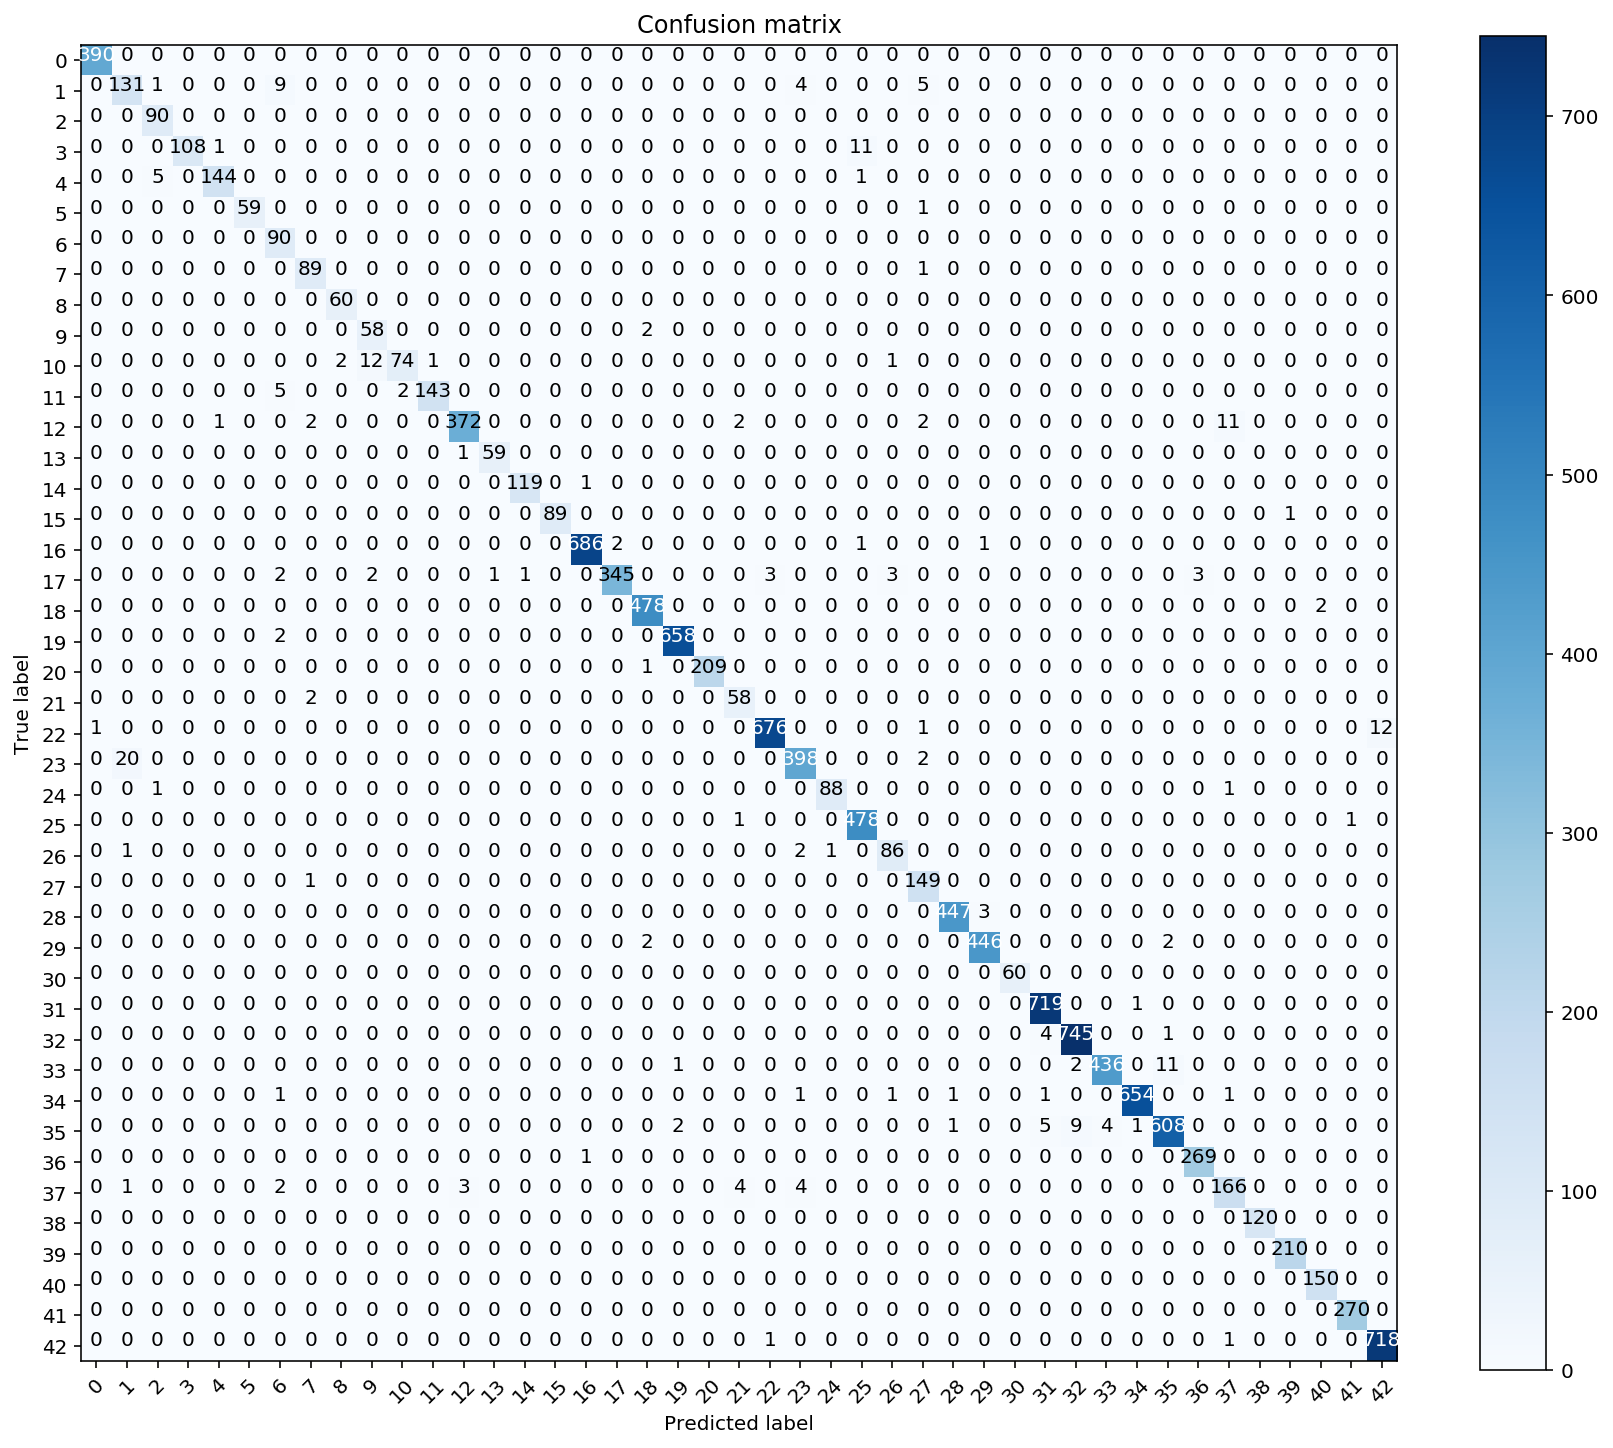

In [7]:
# Credits: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from matplotlib import  pyplot as plt
import numpy as np

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


true_labels = [label_desc[i] for i in true_labels_idx]
predicted_labels = [label_desc[i] for i in predicted_labels_idx]

plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, range(43))

In [8]:
print("Global F1 score for the model: {}".format(f1_score(true_labels_idx, predicted_labels_idx, average="micro")))
print("Class wise F1 score for the model: {}".format(f1_score(true_labels_idx, predicted_labels_idx, average=None)))
print("Mean F1 score for the model: {}".format(f1_score(true_labels_idx, predicted_labels_idx, average="macro")))


Global F1 score for the model: 0.9819477434679335
Class wise F1 score for the model: [1.         0.99240856 0.98937583 0.97977528 0.99392097 0.97124601
 0.97278912 0.99443826 0.99111111 0.99273105 0.99621499 0.960193
 0.98686131 0.99034483 0.99261993 0.99761337 0.99337748 0.97595474
 0.97127937 0.99159664 0.89552239 0.9673913  0.94736842 0.95819936
 0.98324022 0.98455201 0.92222222 0.928      0.97297297 0.96256684
 0.86468647 0.99815157 0.98360656 0.9976247  1.         0.99871959
 0.99166667 0.98333333 0.99564586 0.99441341 0.95027624 0.87878788
 0.89156627]
Mean F1 score for the model: 0.9717294450654682


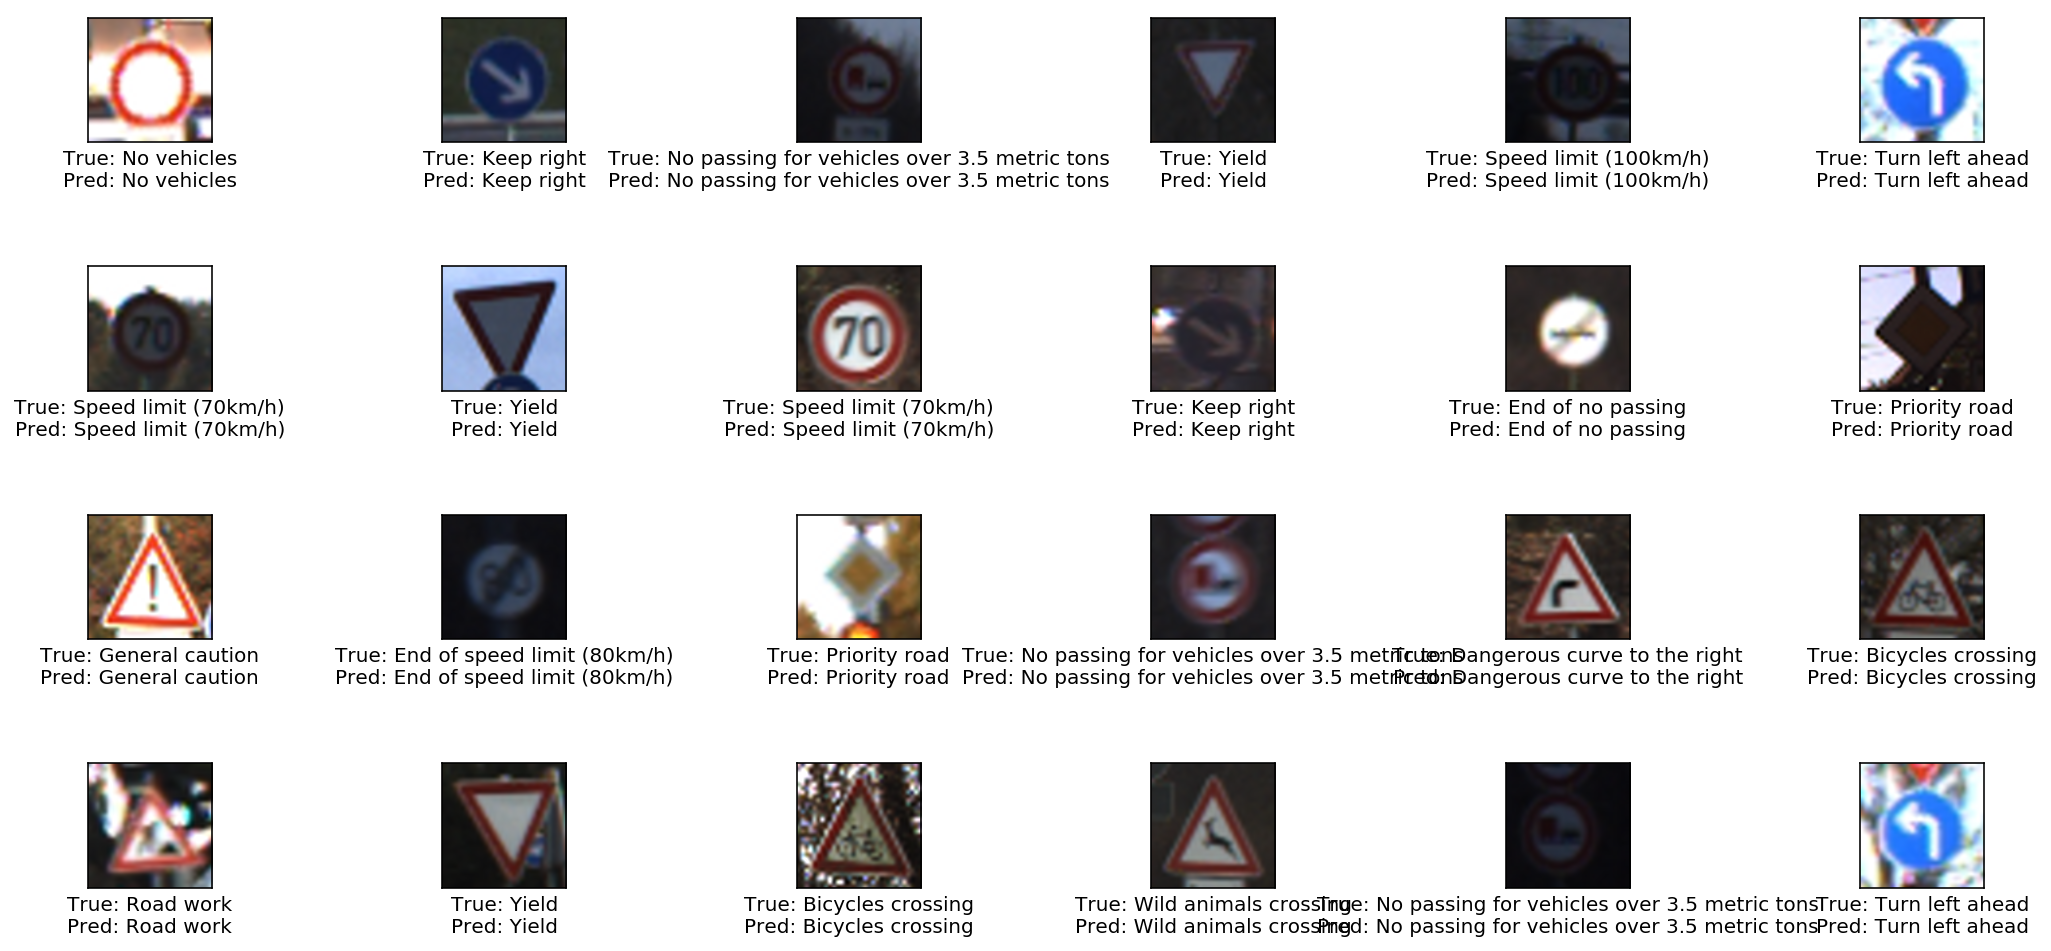

In [7]:
# Display sampled test images with true and predicted outcome.
utils.display_sample_images(test_features, true_labels_idx, label_desc, predictions=predicted_labels_idx)

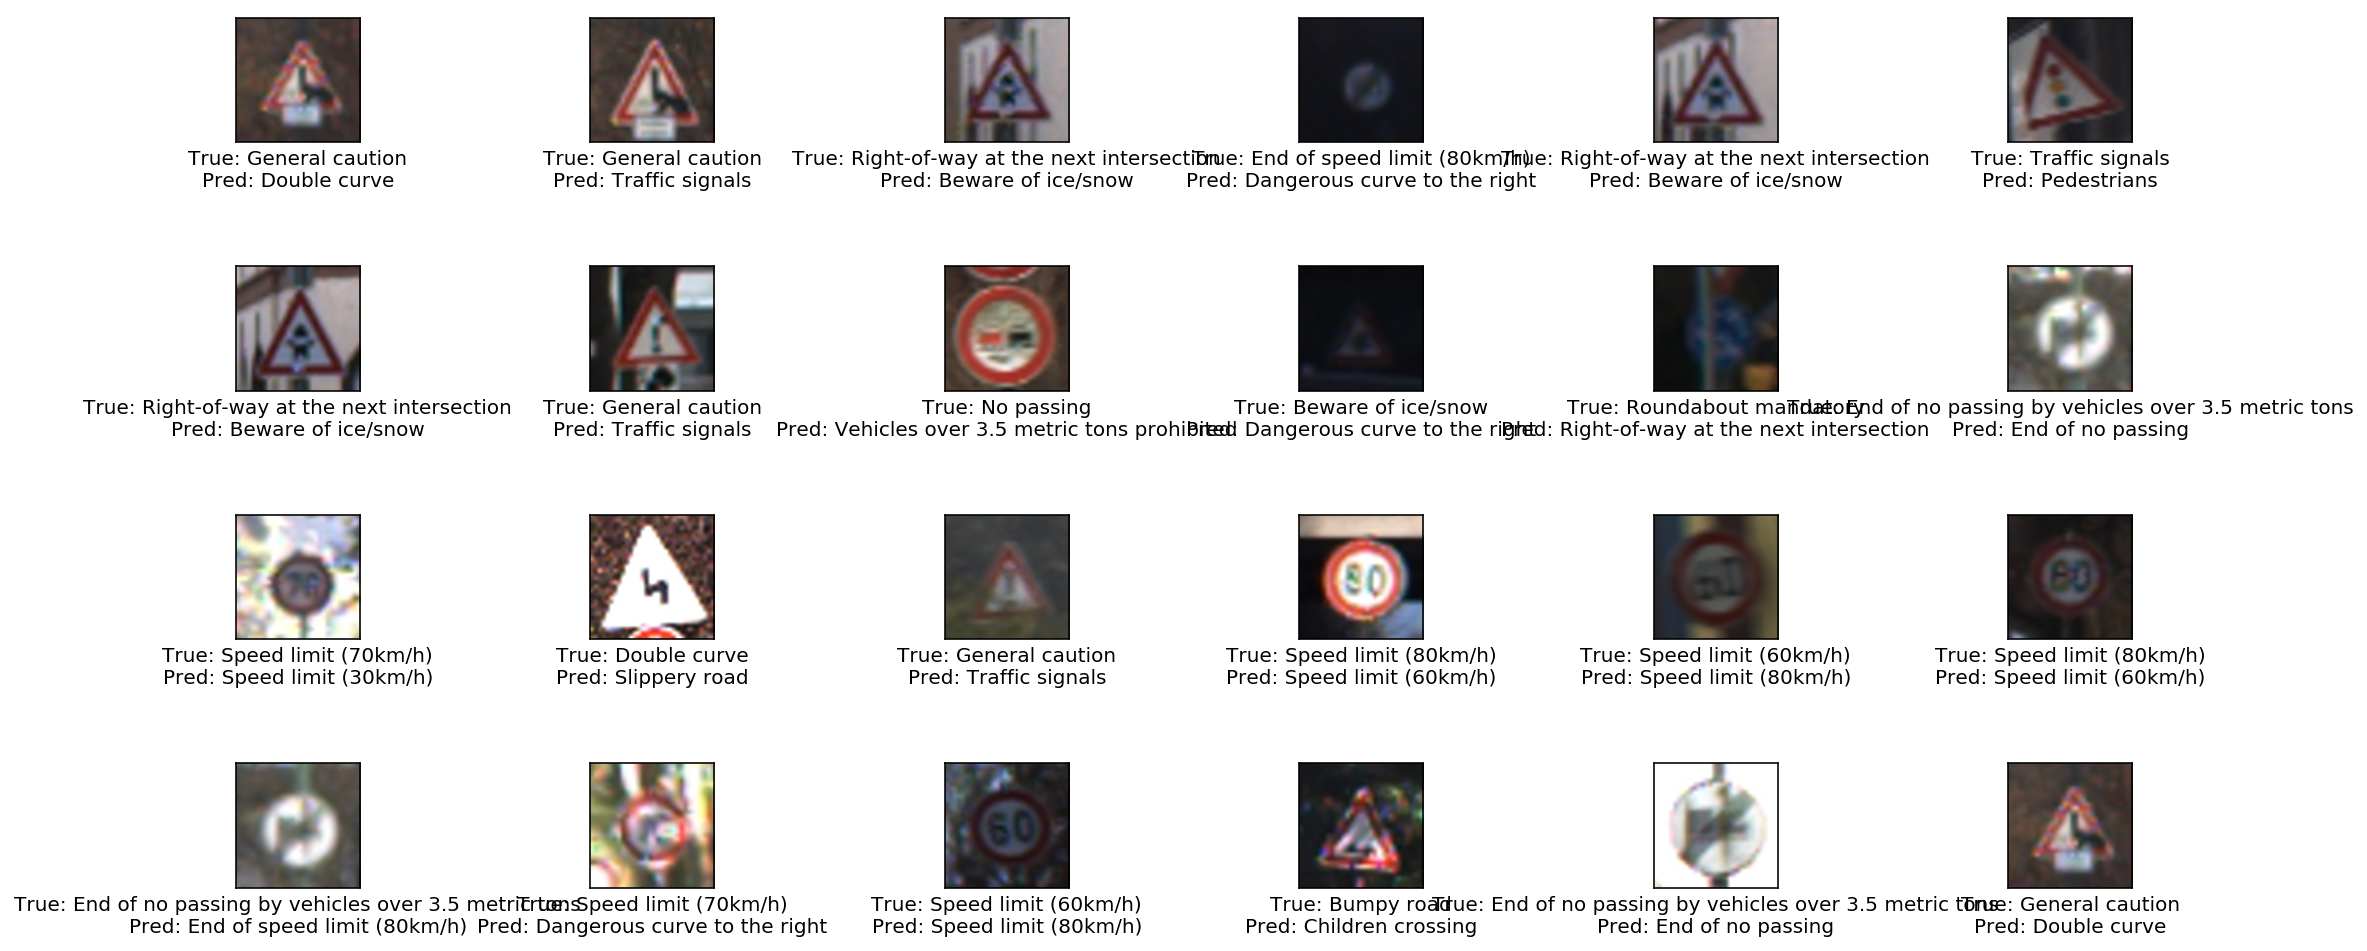

In [19]:
import numpy as np

sampled_idx = np.argwhere(np.equal(true_labels_idx, predicted_labels_idx) == False).flatten()
sampled_test_features = test_features[sampled_idx]
sampled_true_labels = true_labels_idx[sampled_idx]
sampled_predicted_labels = predicted_labels_idx[sampled_idx]

utils.display_sample_images(sampled_test_features, sampled_true_labels, label_desc, sampled_predicted_labels)

Slippery road is classified as Speed limit (30km/h) for 20 times
[  1770   1771   1772 ... 105863 105961 106394]


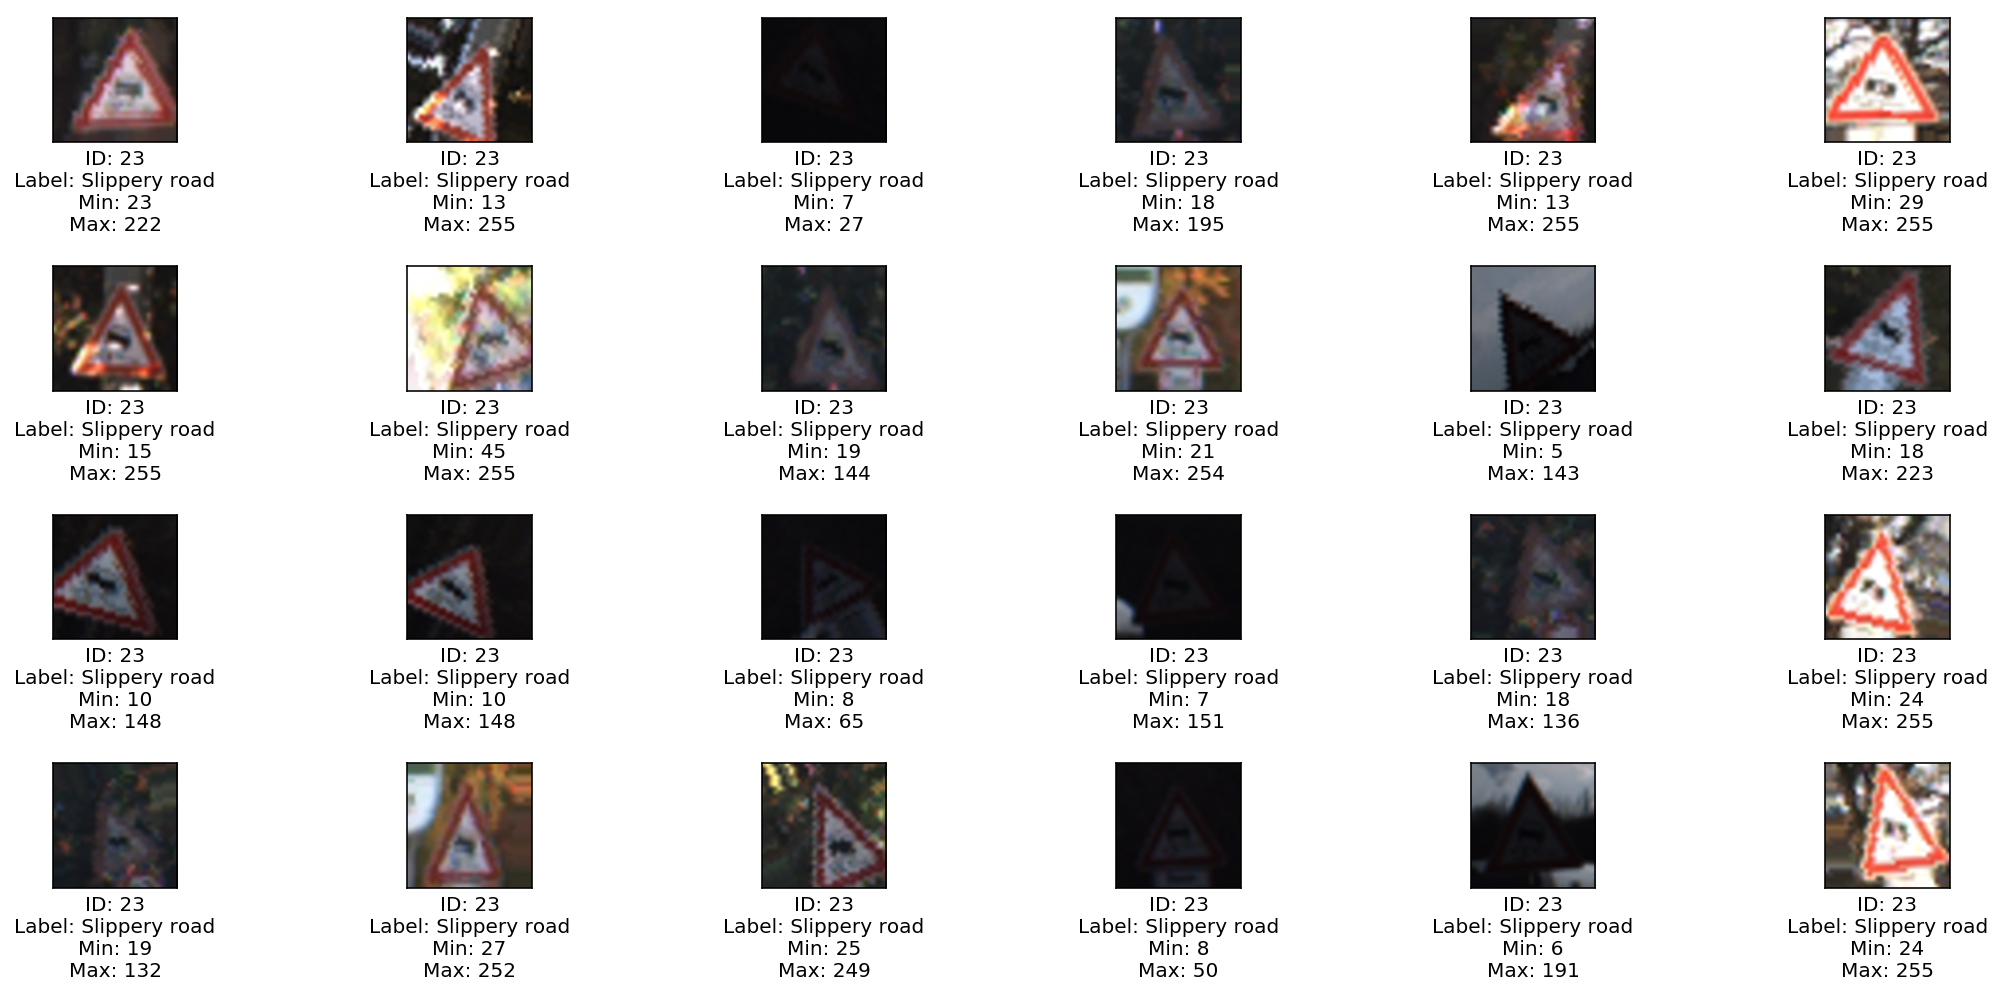

In [94]:
print("{} is classified as {} for 20 times".format(label_desc[23], label_desc[1]))

sampled_labels_idx = np.argwhere(train_labels == 23).flatten()

sampled_images = train_features[sampled_labels_idx]
sampled_labels = train_labels[sampled_labels_idx]

utils.display_sample_images(sampled_images, sampled_labels, label_desc)

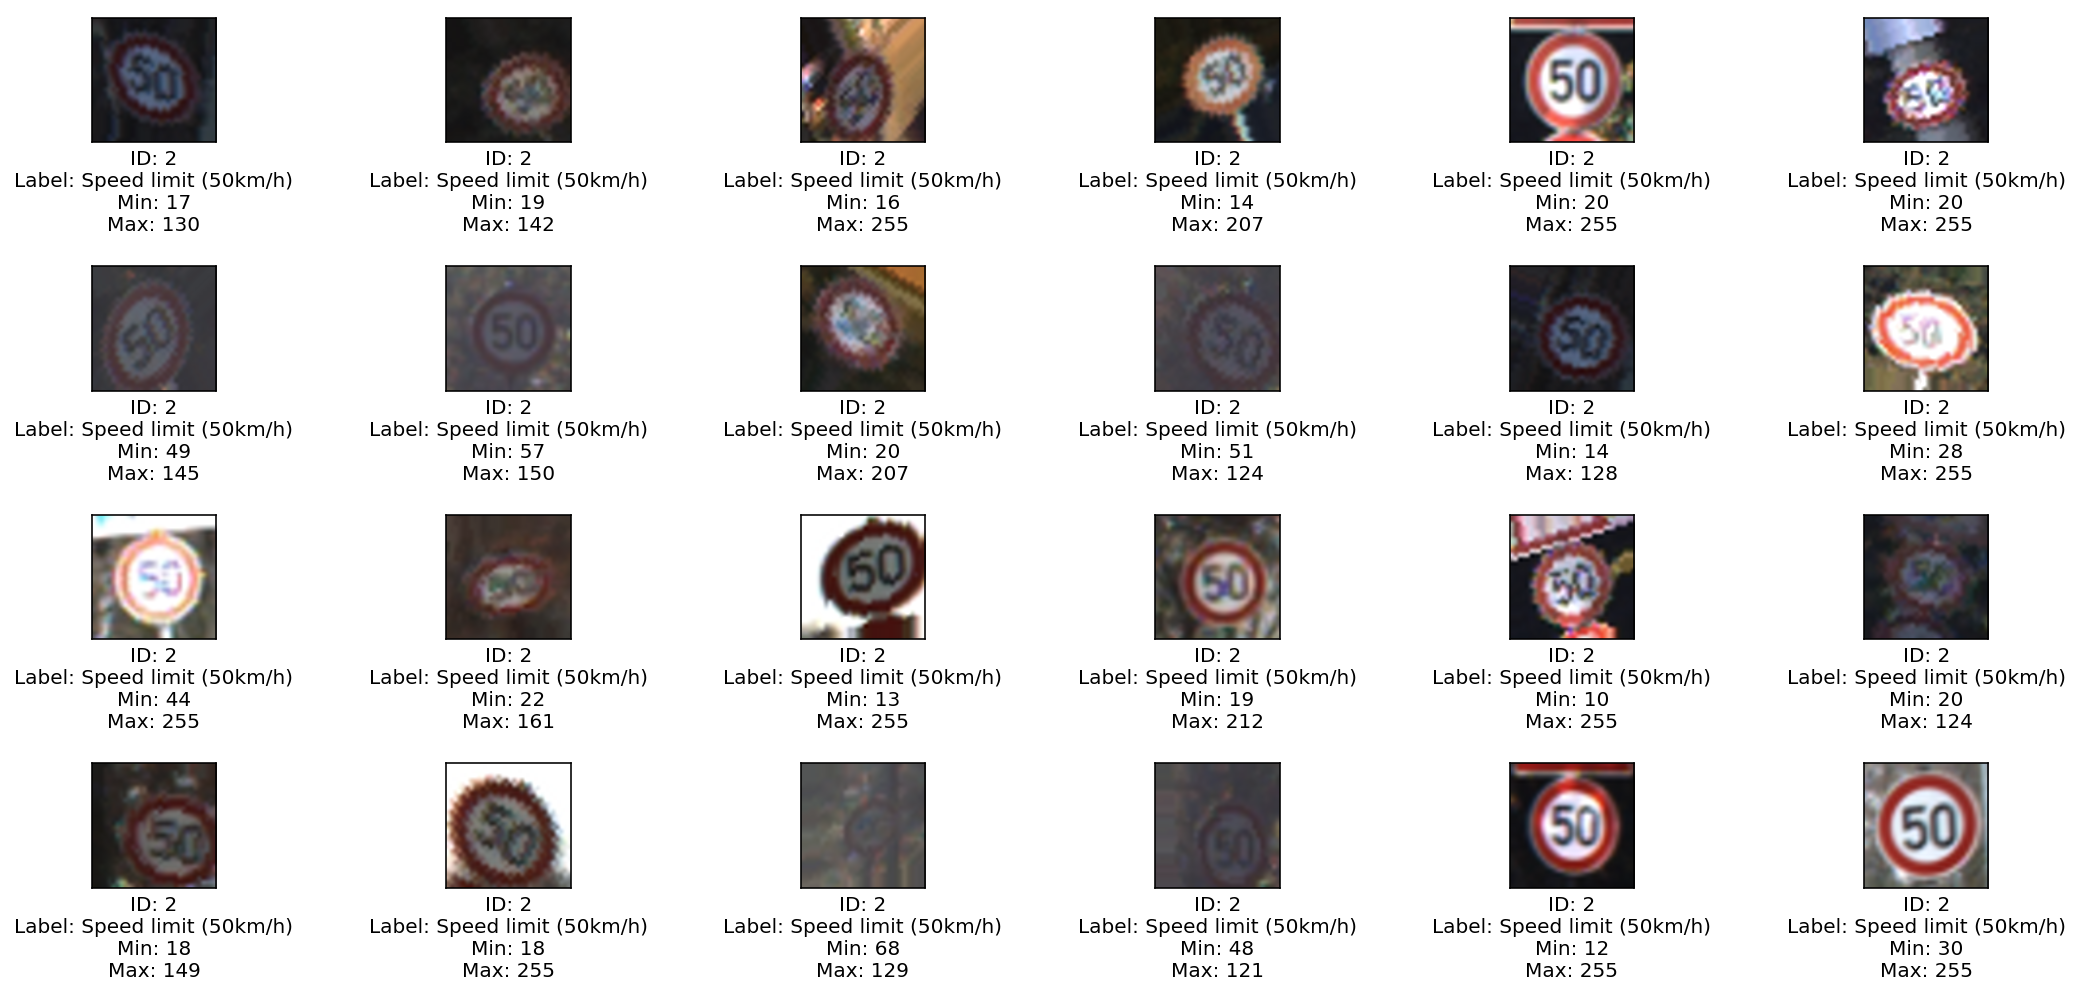

In [95]:
sampled_labels_idx = np.argwhere(train_labels == 2).flatten()

sampled_images = train_features[sampled_labels_idx]
sampled_labels = train_labels[sampled_labels_idx]

utils.display_sample_images(sampled_images, sampled_labels, label_desc)